In [1]:
from hops import hdfs
from tempfile import TemporaryFile
import numpy as np

Starting Spark application


SparkSession available as 'spark'.


In [2]:
%%local
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline 

xlabel_size = 80
ylabel_size = 80
font_size = 60
tick_size = 60
line_width = 20

## Define Parameters

In [3]:
root_path = "hdfs:///Projects/traffic_reginbald/processed_traffic_data/hyperparameter-tuning/"

## Define functions

In [4]:
def read_file(path):
    fs_handle = hdfs.get_fs()
    temp_file = TemporaryFile()

    fd = fs_handle.open_file(path, mode='r')

    temp_file.write(fd.read())
    temp_file.seek(0) # important, set cursor to beginning of file

    np_array = np.load(temp_file)
    return np_array

## Analyze Whole Traffic Network Model Hyperparameter Tuning

In [5]:
all_tuning = [
    ["lstm", [50, 100, 500, 1000, 1500, 2000]],
    ["gru", [50, 100, 500, 1000, 1500, 2000]]
]

losses = []
val_losses = []
training_times = []
labels = []

for t in all_tuning:
    for i in t[1]:
        losses.append(read_file(root_path + "all_sensors-" + t[0] + "_units_" + str(i) + "/loss.npy"))
        val_losses.append(read_file(root_path + "all_sensors-" + t[0] + "_units_" + str(i) + "/val_loss.npy"))
        training_times.append(read_file(root_path + "all_sensors-" + t[0] + "_units_" + str(i) + "/training_time.npy"))
        labels.append(str(i) + " " + t[0] + " units")
        
# Add none if lists are not equal in size
max_length = 0
for loss in losses:
    if len(loss) > max_length:
        max_length = len(loss)
for i in range(len(losses)):
    for p in range(max_length - len(losses[i])):
        losses[i] = np.append(losses[i], None)
        val_losses[i] = np.append(val_losses[i], None)

In [6]:
%%spark -o loss_df

loss_df = spark.createDataFrame(
    sc.parallelize(np.array(losses)[:6].transpose().tolist()), 
    np.array(labels)[:6].tolist()
)

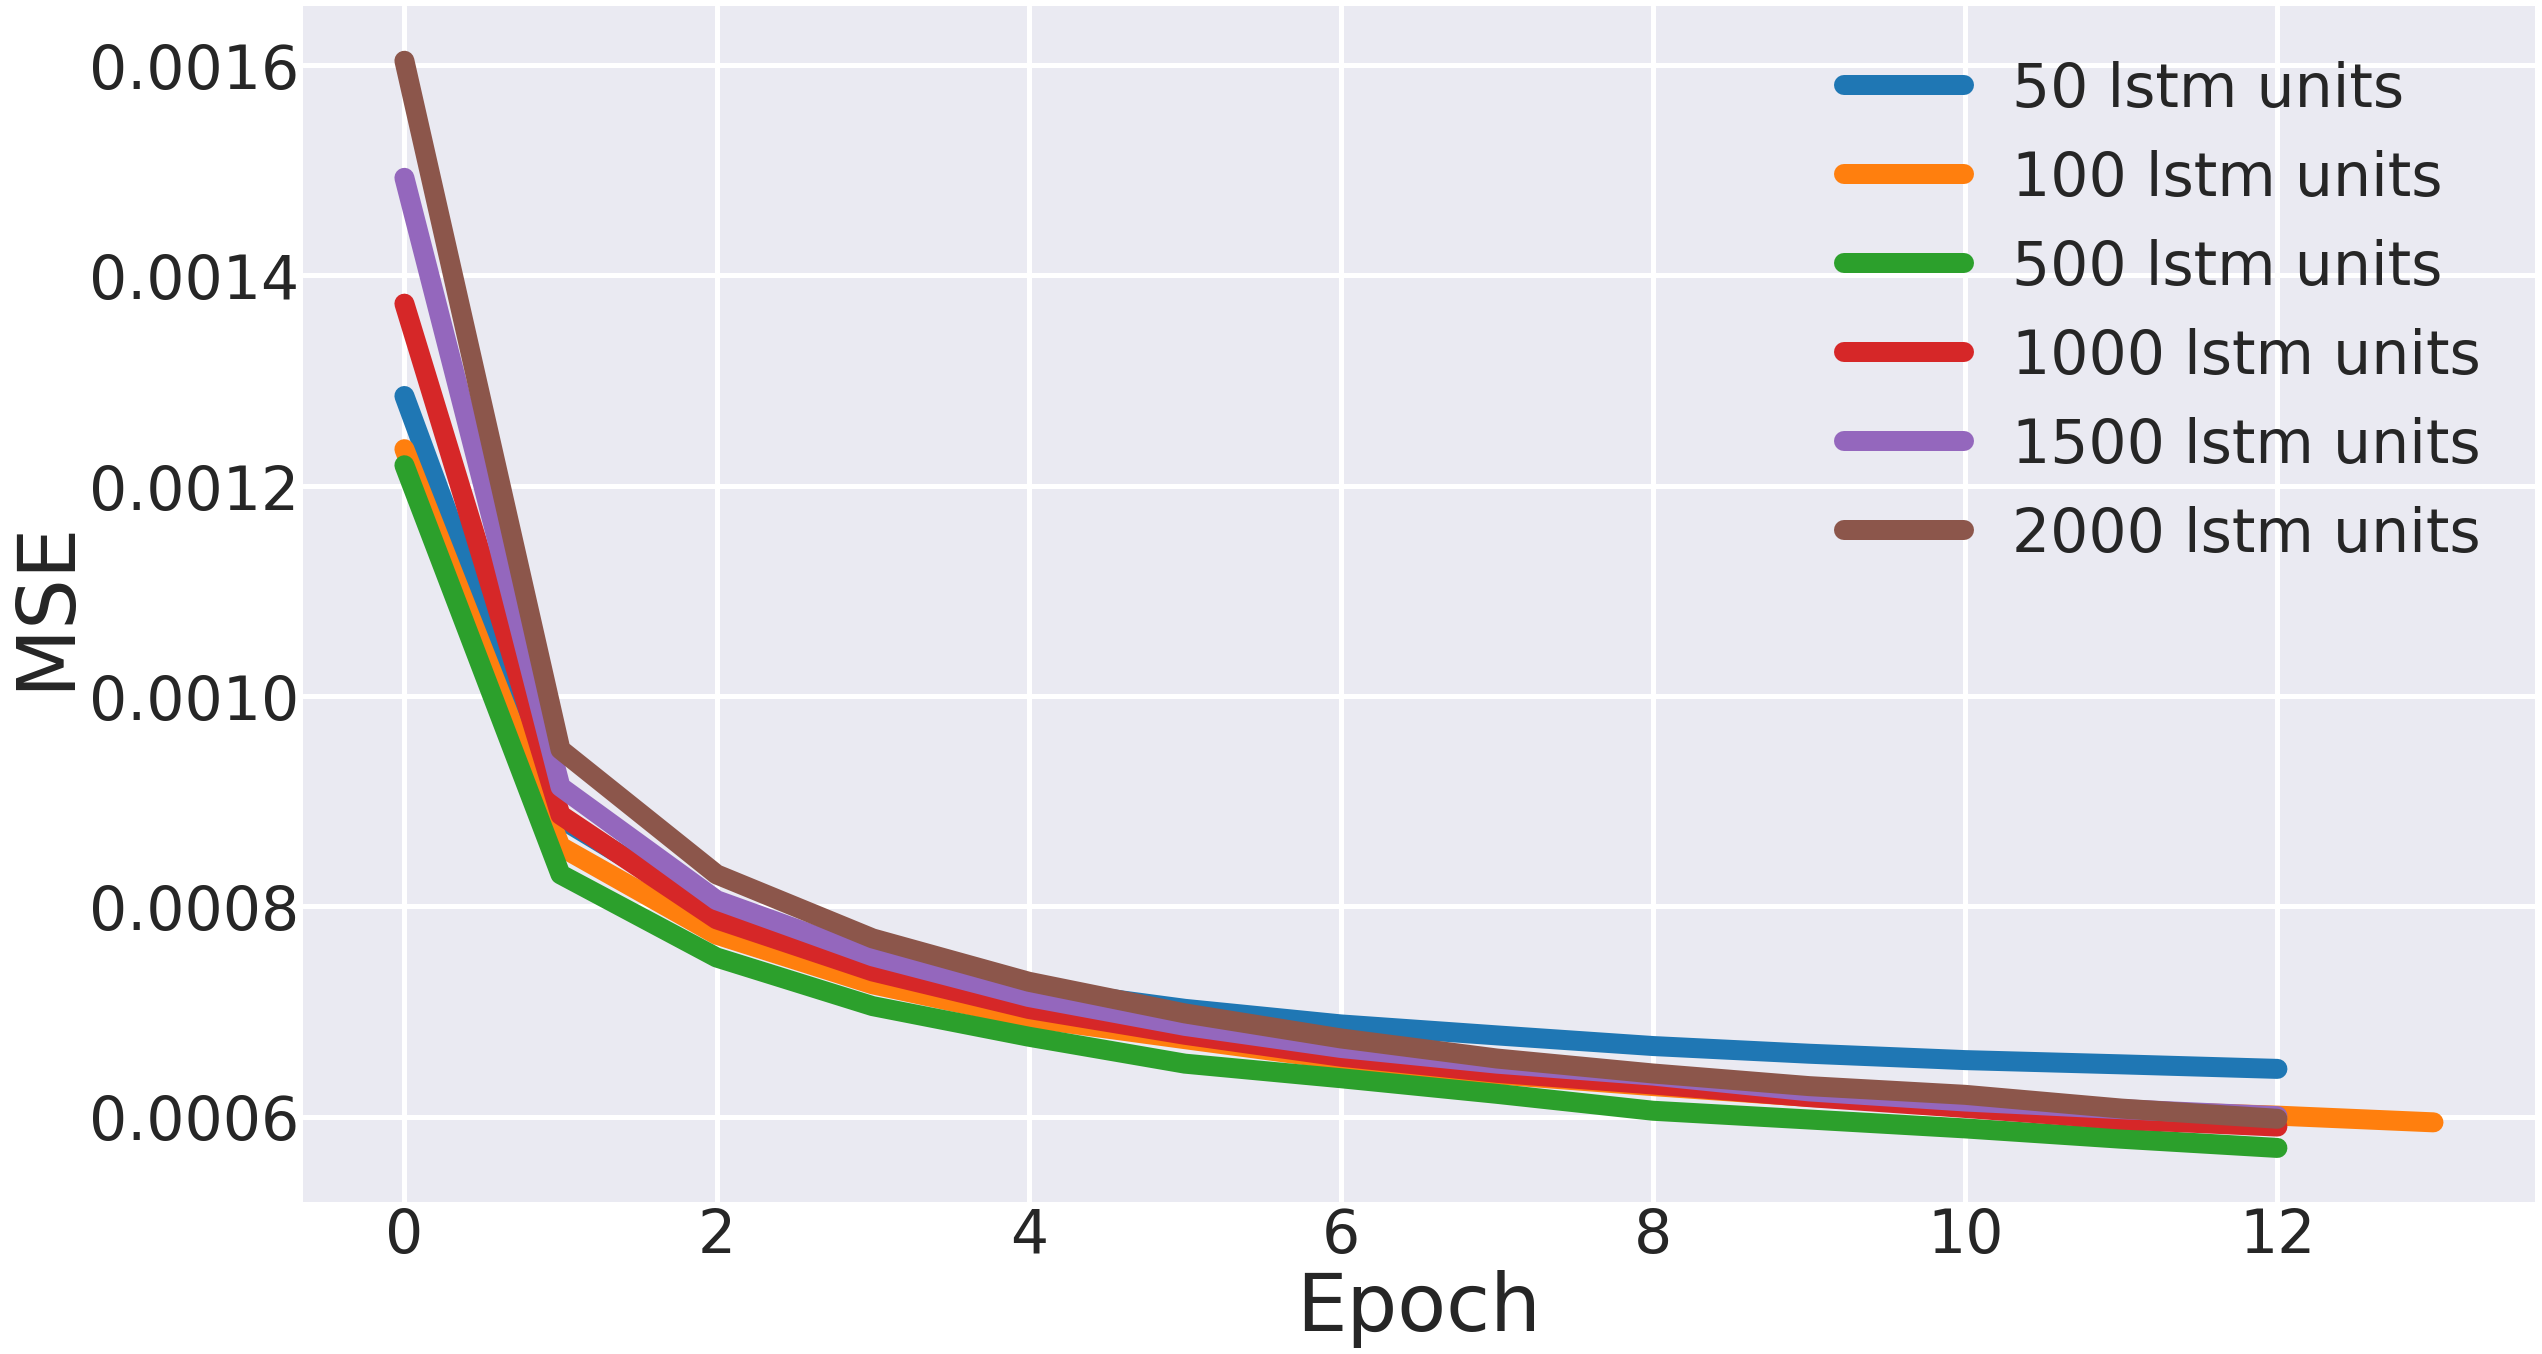

In [7]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
loss_plot = loss_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_plot.grid(linewidth=5)

In [8]:
%%spark -o val_loss_df

val_loss_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses)[:6].transpose().tolist()), 
    np.array(labels)[:6].tolist()
)

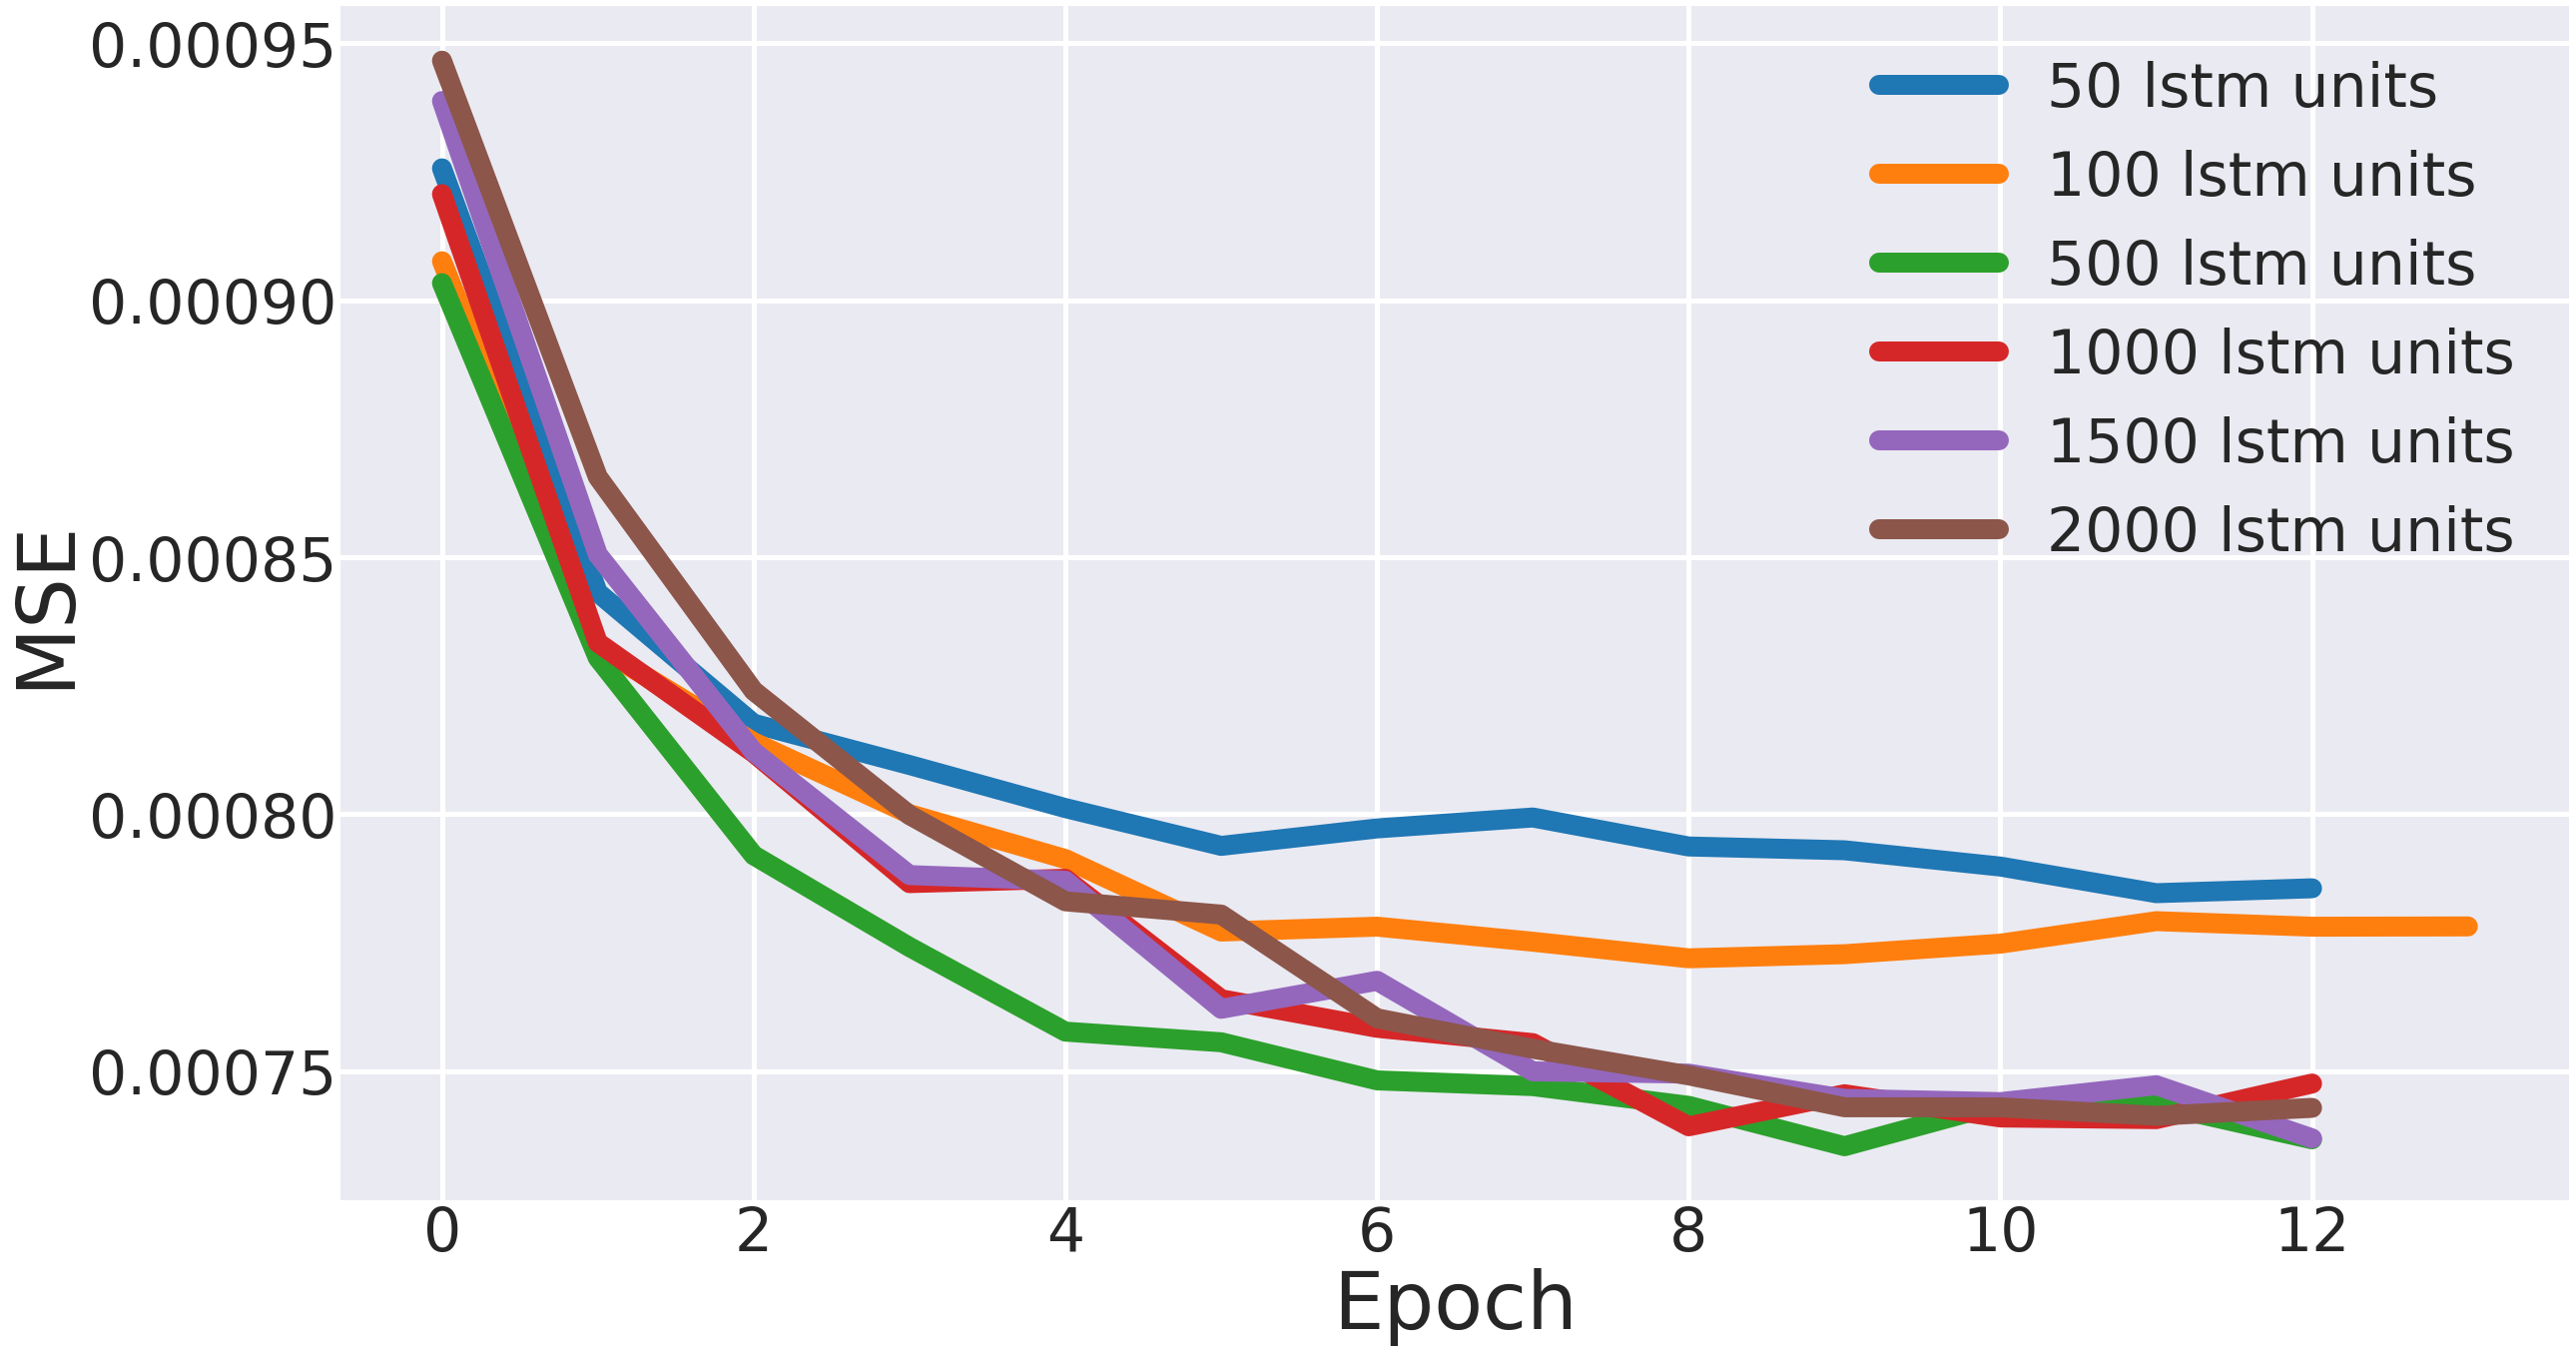

In [9]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
val_loss_plot = val_loss_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
val_loss_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_plot.set_ylabel("MSE", {'size':ylabel_size})
val_loss_plot.grid(linewidth=5)

In [10]:
%%spark -o training_time_df

#training_time_df = spark.createDataFrame(
#    sc.parallelize(zip(
#        [50, 100, 500, 1000, 1500, 2000], 
#        np.array(training_times)[:6].tolist(), 
#        np.array(training_times)[6:].tolist())
#    ),
#    ("index", "LSTM", "GRU")
#)

training_time_df = spark.createDataFrame(
    sc.parallelize(zip(
        [50, 100, 500, 1000, 1500, 2000], 
        np.array(training_times)[:6].tolist())
    ),
    ("index", "LSTM")
)

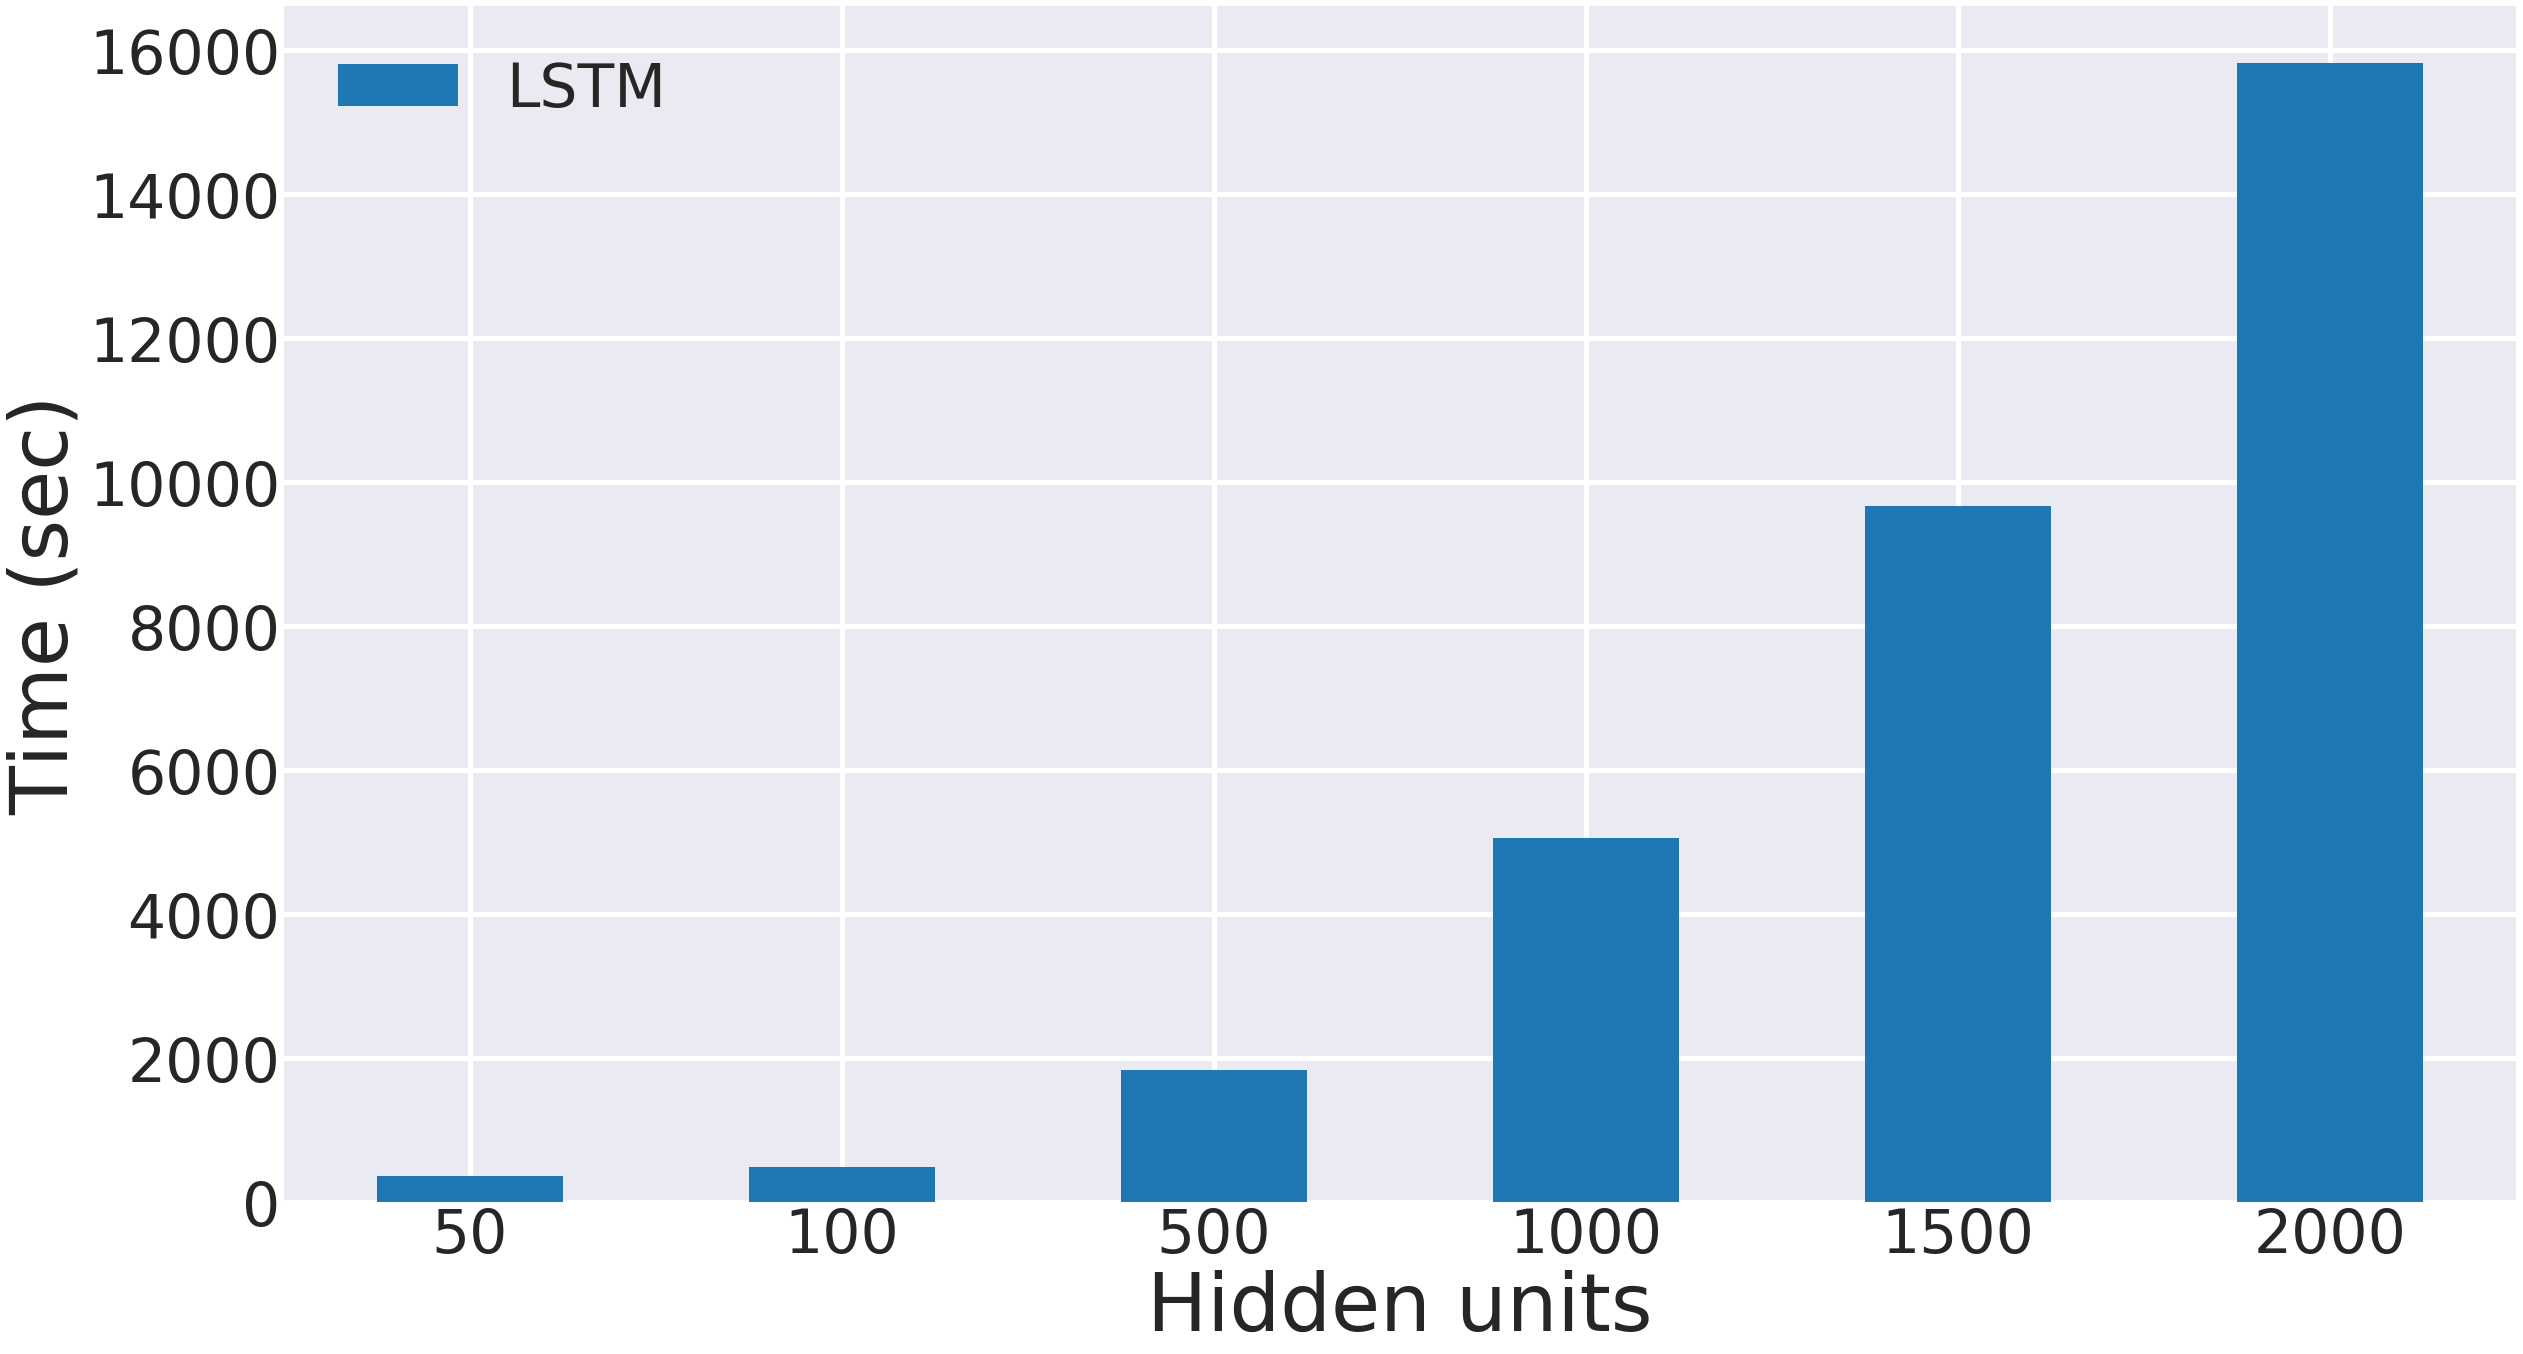

In [11]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_plot = training_time_df.set_index('index').plot.bar(figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0)
 
training_time_plot.set_xlabel("Hidden units", {'size':xlabel_size})
training_time_plot.set_ylabel("Time (sec)", {'size':ylabel_size})
training_time_plot.grid(linewidth=5)

## Analyze Partition Model Hyperparameter Tuning

In [12]:
partition_tuning = [
    ["lstm", 3, [50, 100, 200, 400, 600, 800, 1000]],
    ["lstm", 5, [200, 400, 600, 800, 1000]],
    ["lstm", 10, [200, 400, 600, 800, 1000]],
    ["lstm", 20, [200, 400, 600, 800, 1000]],
    ["lstm", 30, [200, 400, 600, 800, 1000]],
]

losses = []
val_losses = []
training_times = []
labels = []

for t in partition_tuning:
    for units in t[2]:
        losses.append(read_file(root_path + "partition_" + str(t[1]) + "min-" + t[0] + "_units_" + str(units) + "/loss.npy"))
        val_losses.append(read_file(root_path + "partition_" + str(t[1]) + "min-" + t[0] + "_units_" + str(units) + "/val_loss.npy"))
        training_times.append(read_file(root_path + "partition_" + str(t[1]) + "min-" + t[0] + "_units_" + str(units) + "/training_time.npy"))
        labels.append(str(t[1]) + "min partition - " + str(units) + " " + t[0] + " units")
        
# Add none if lists are not equal in size
max_length = 0
for loss in losses:
    if len(loss) > max_length:
        max_length = len(loss)
for i in range(len(losses)):
    for p in range(max_length - len(losses[i])):
        losses[i] = np.append(losses[i], None)
        val_losses[i] = np.append(val_losses[i], None)

### 3 Minute Partitions

In [13]:
%%spark -o loss_3min_df

loss_3min_df = spark.createDataFrame(
    sc.parallelize(np.array(losses[:7]).transpose().tolist()), 
    np.array(labels[:7]).tolist()
)

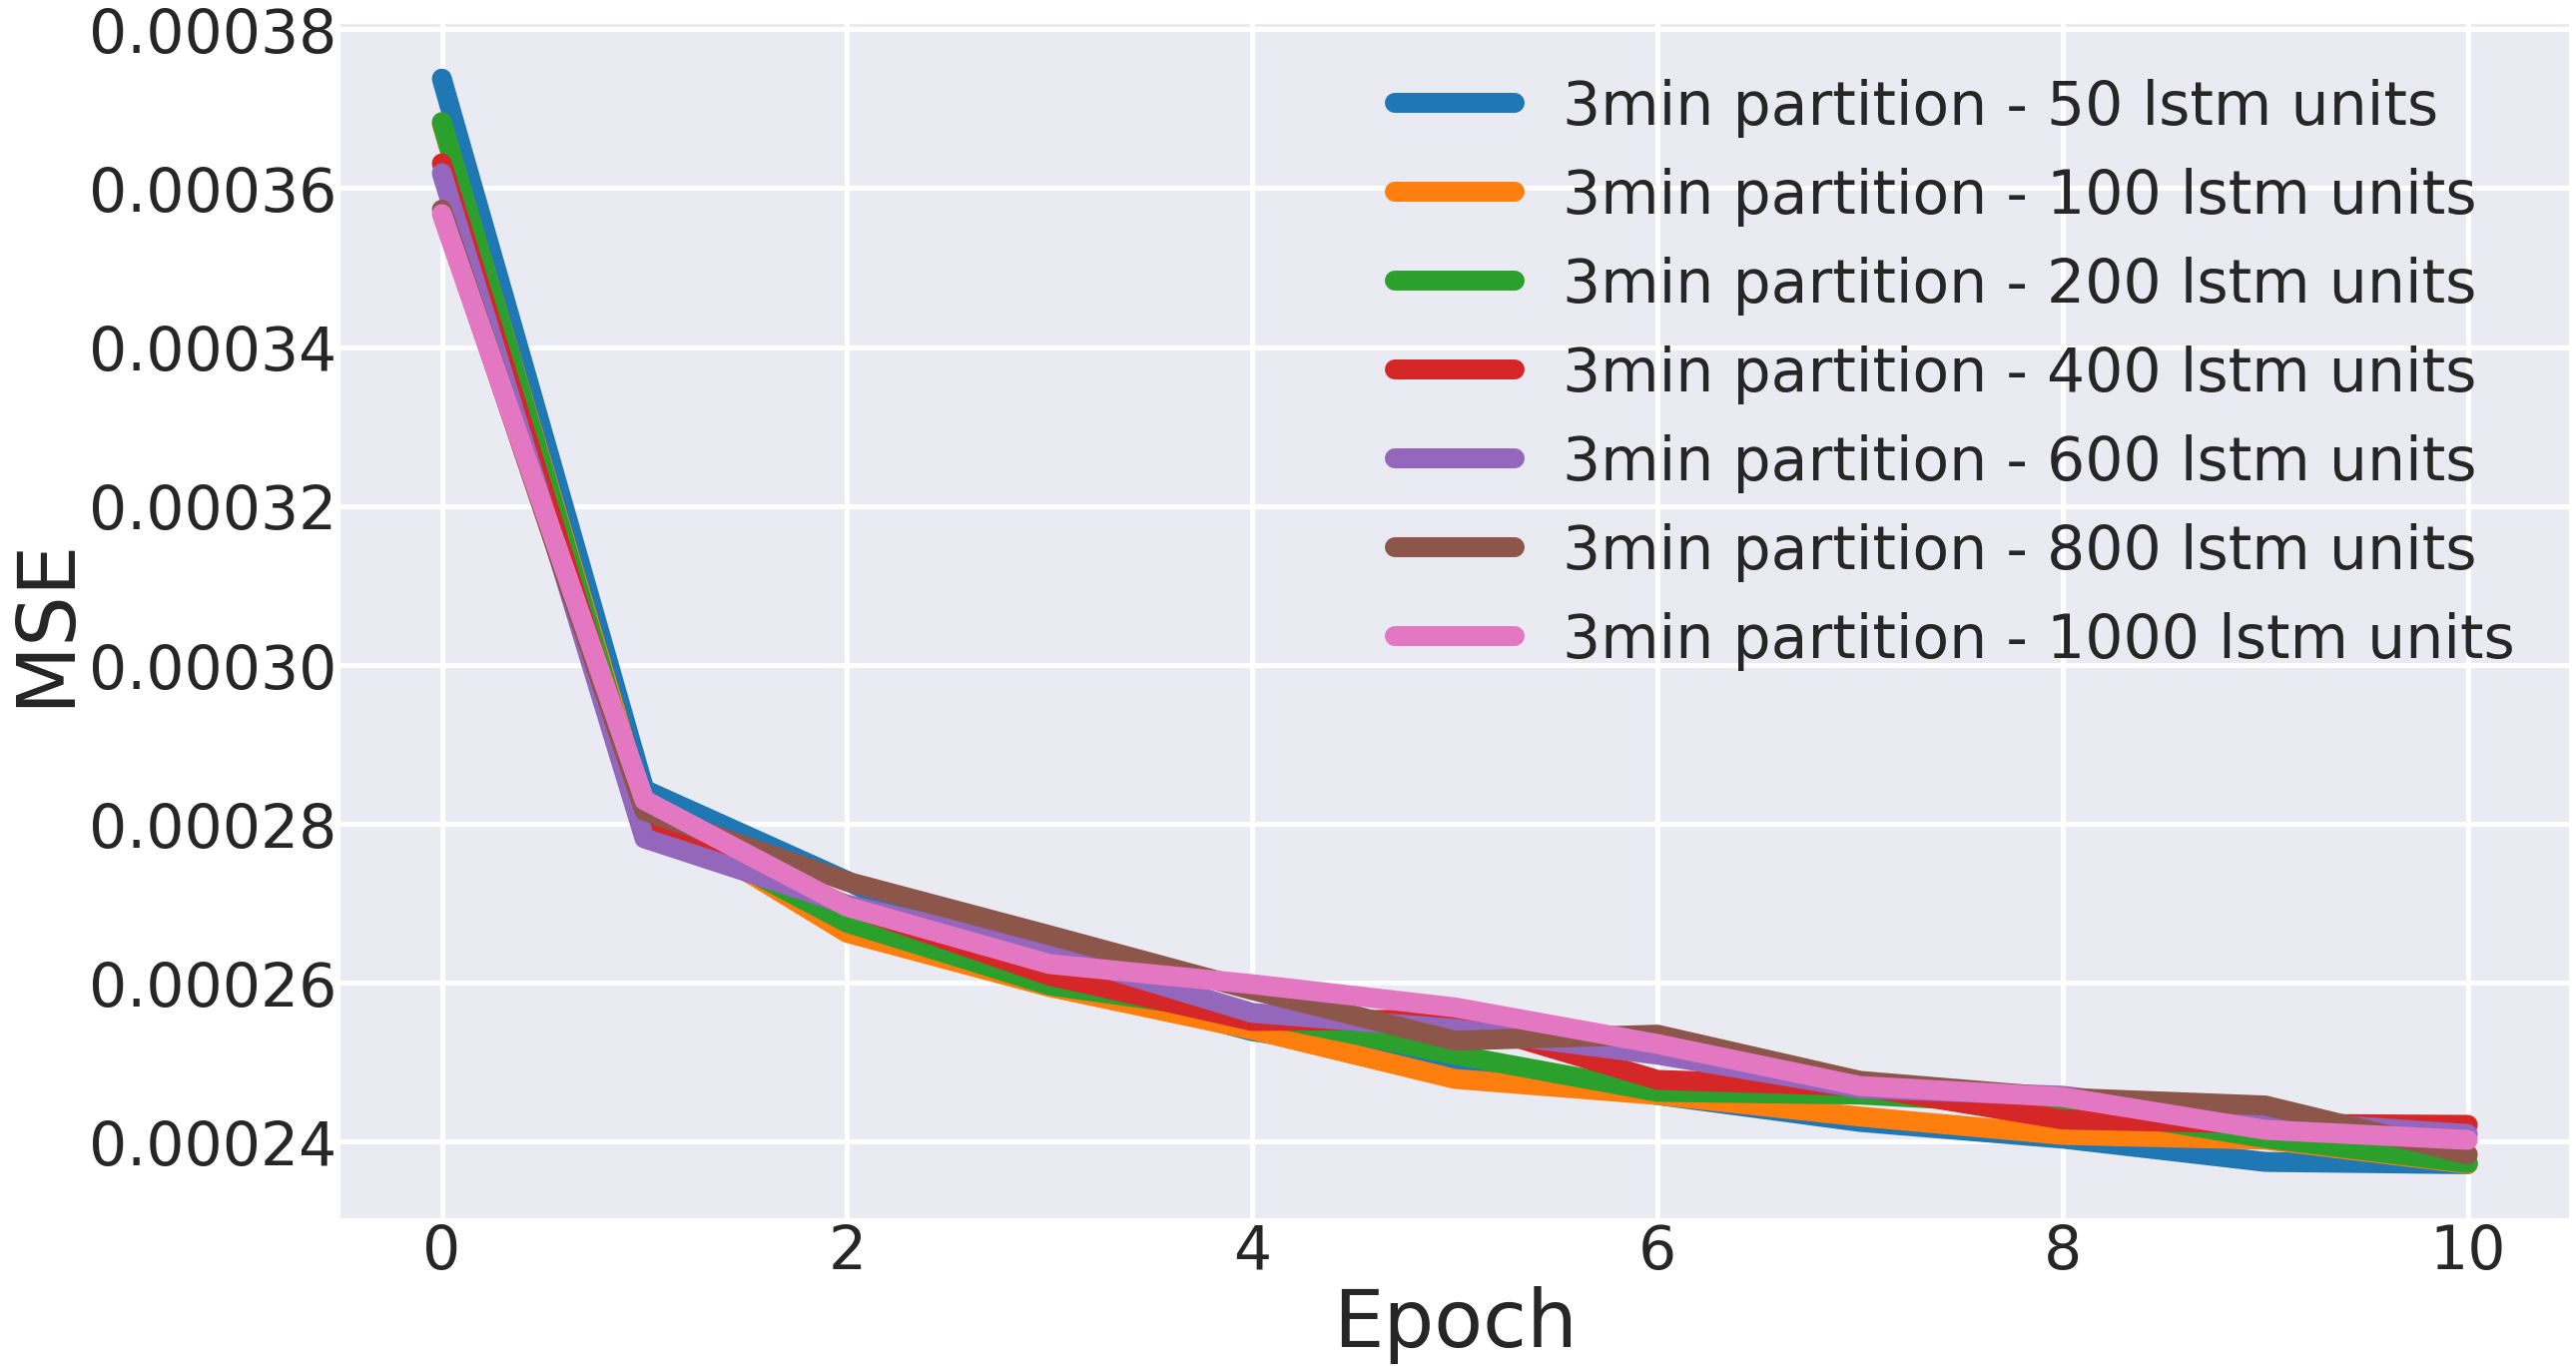

In [14]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
loss_3min_plot = loss_3min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_3min_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_3min_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_3min_plot.grid(linewidth=5)

In [15]:
%%spark -o val_loss_3min_df

val_loss_3min_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses[:7]).transpose().tolist()), 
    np.array(labels[:7]).tolist()
)

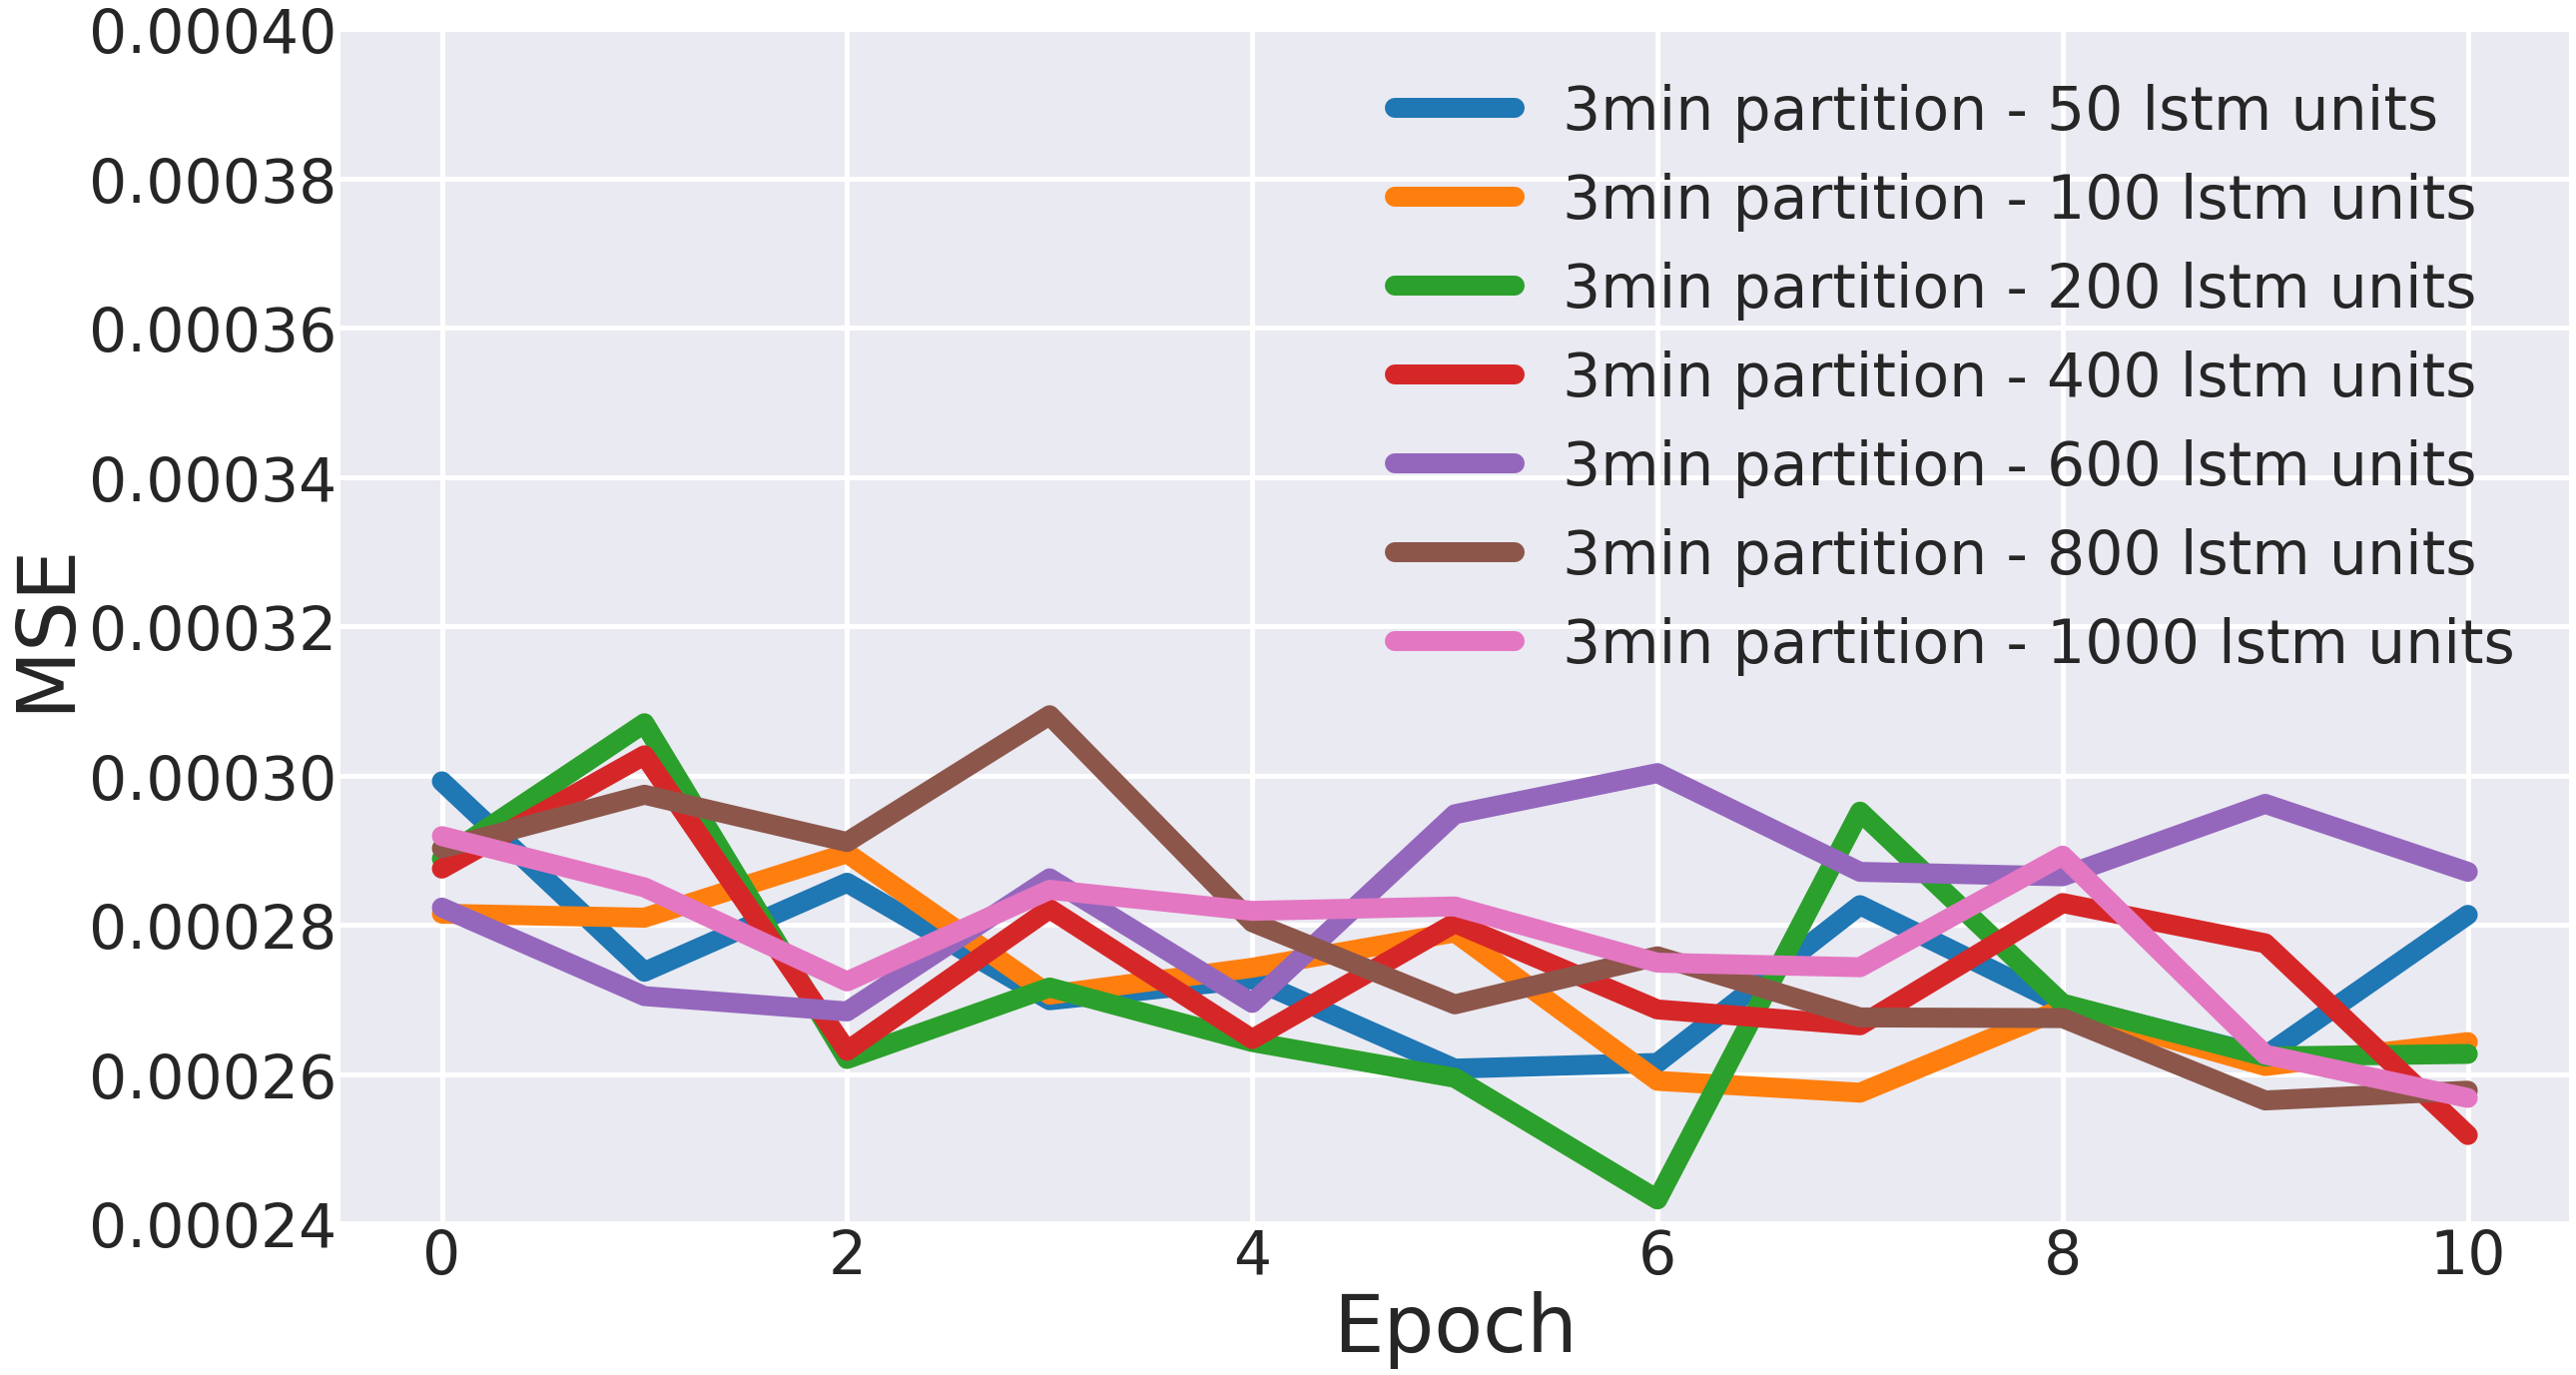

In [16]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
val_loss_3min_plot = val_loss_3min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)

val_loss_3min_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_3min_plot.set_ylabel("MSE", {'size':ylabel_size})
val_loss_3min_plot.set_ylim(0.00024, 0.0004)
val_loss_3min_plot.grid(linewidth=5)

In [17]:
%%spark -o training_time_3min_df

training_time_3min_df = spark.createDataFrame(
    sc.parallelize(zip(
        partition_tuning[0][2], 
        np.array(training_times)[:7].tolist()
    )),
    ("index", "LSTM")
)

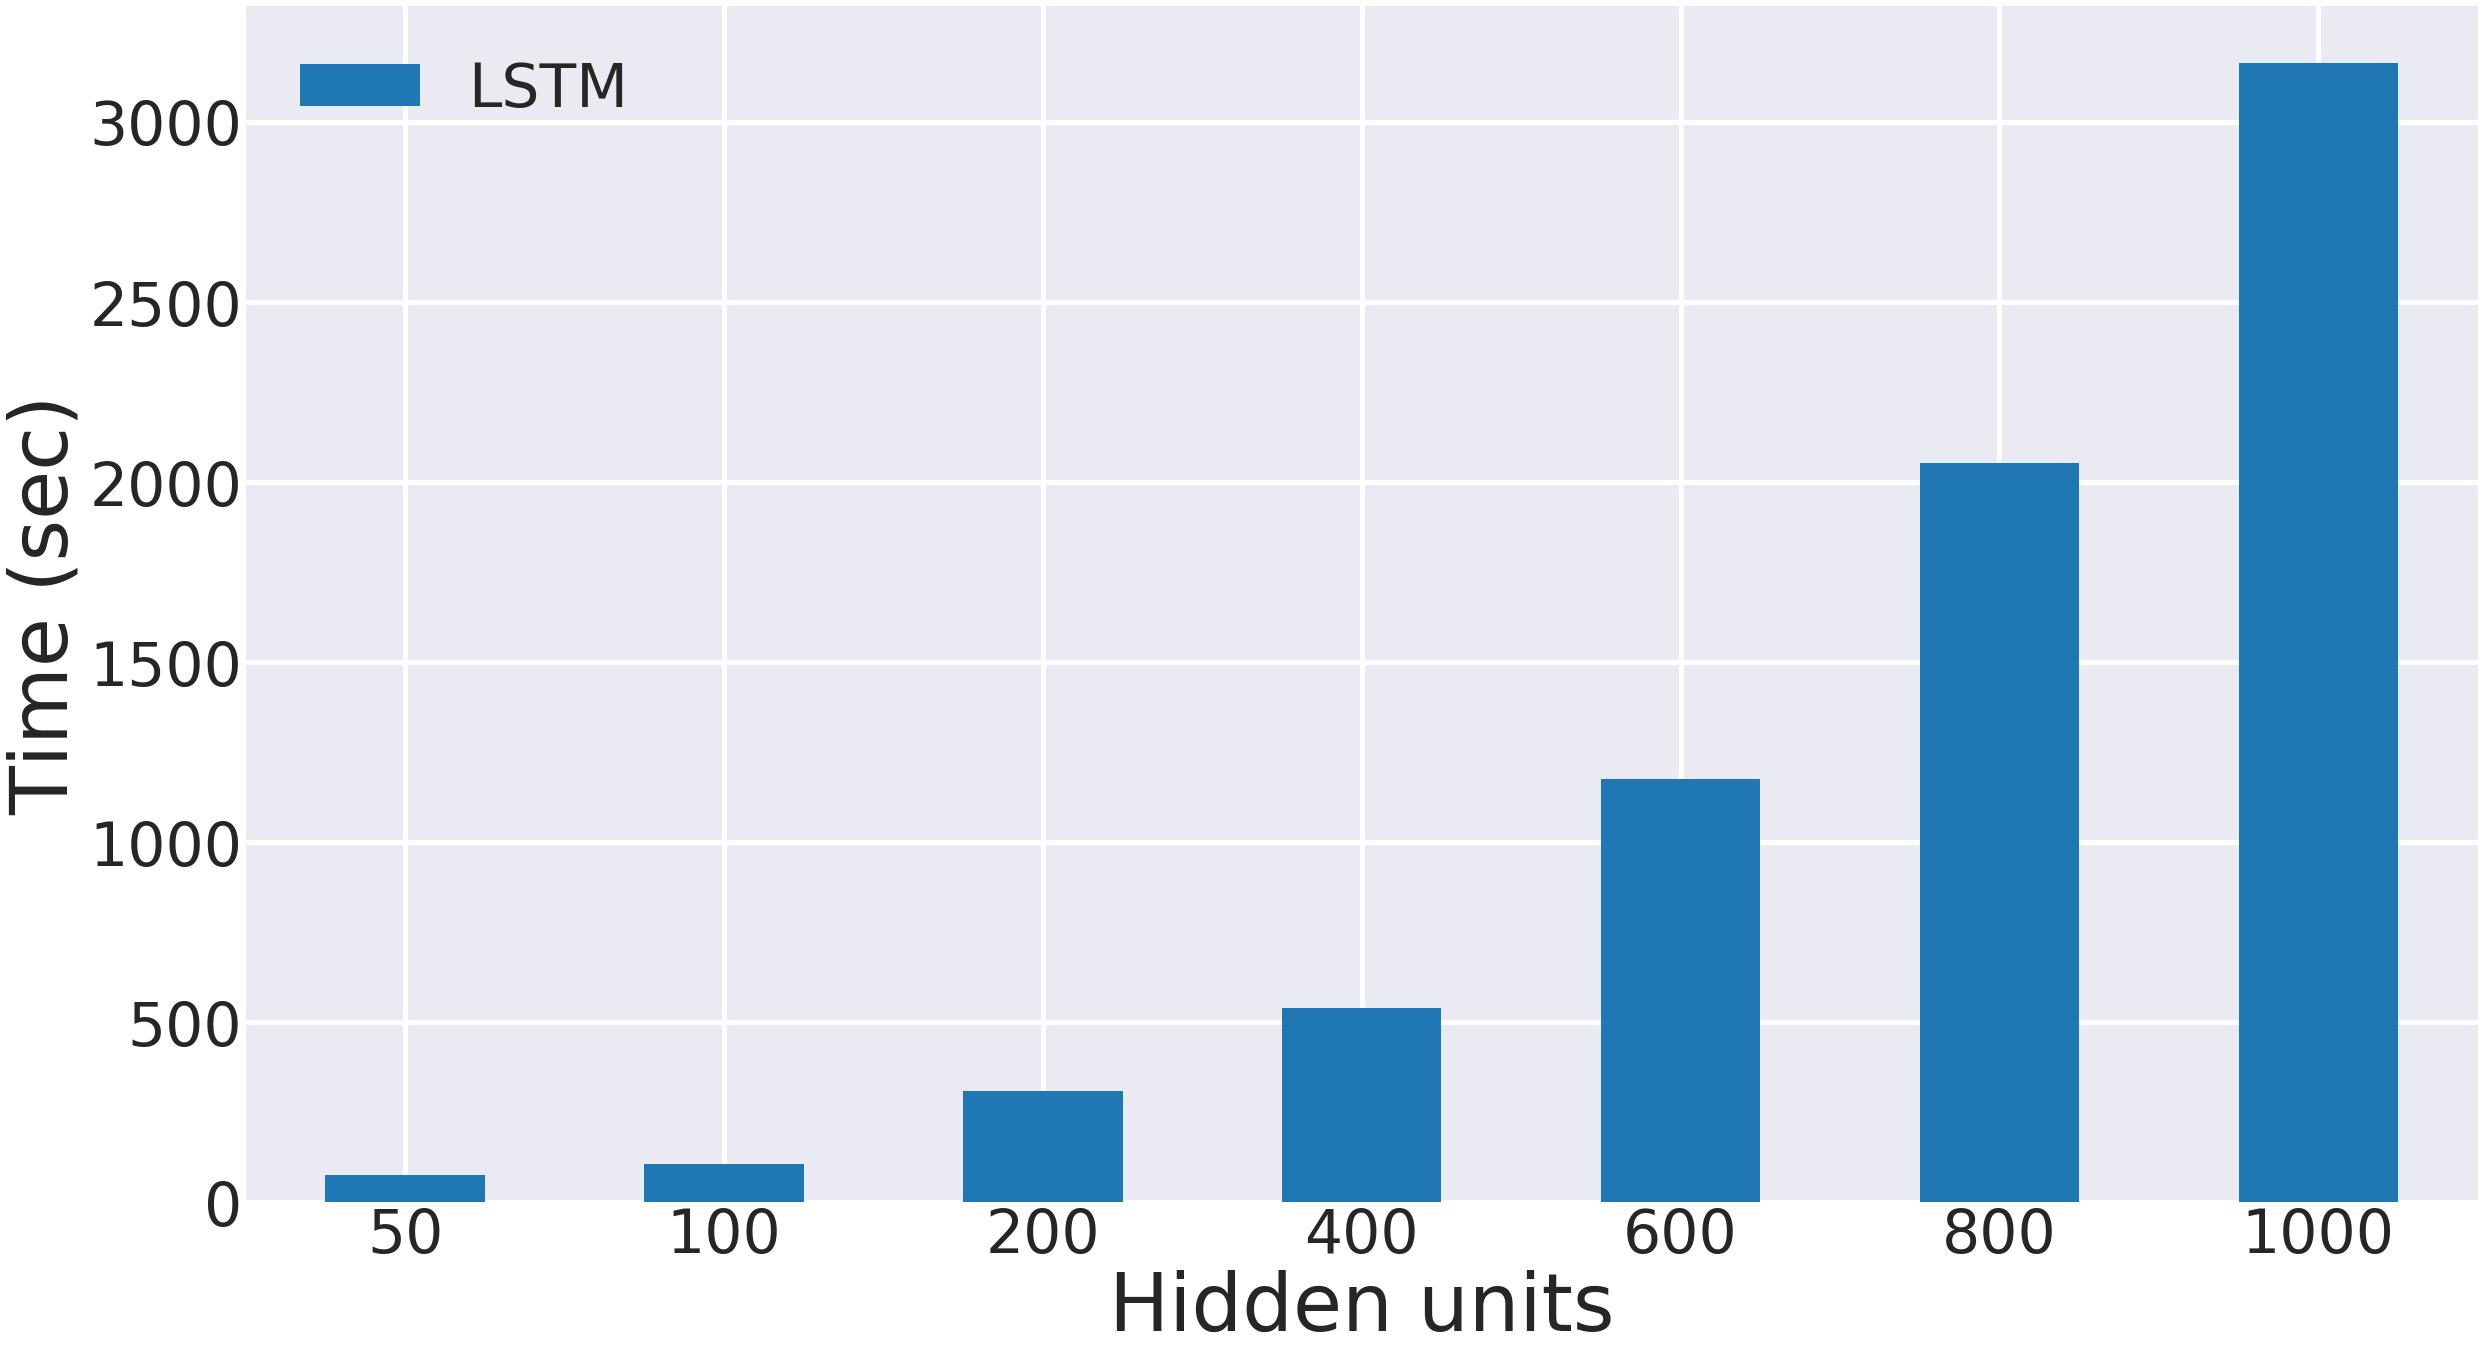

In [18]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_3min_plot = training_time_3min_df.set_index('index').plot.bar(figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0)
 
training_time_3min_plot.set_xlabel("Hidden units", {'size':xlabel_size})
training_time_3min_plot.set_ylabel("Time (sec)", {'size':ylabel_size})
training_time_3min_plot.grid(linewidth=5)

### 5 Minute Partitions

In [19]:
%%spark -o loss_5min_df

loss_5min_df = spark.createDataFrame(
    sc.parallelize(np.array(losses[7:12]).transpose().tolist()), 
    np.array(labels[7:12]).tolist()
)

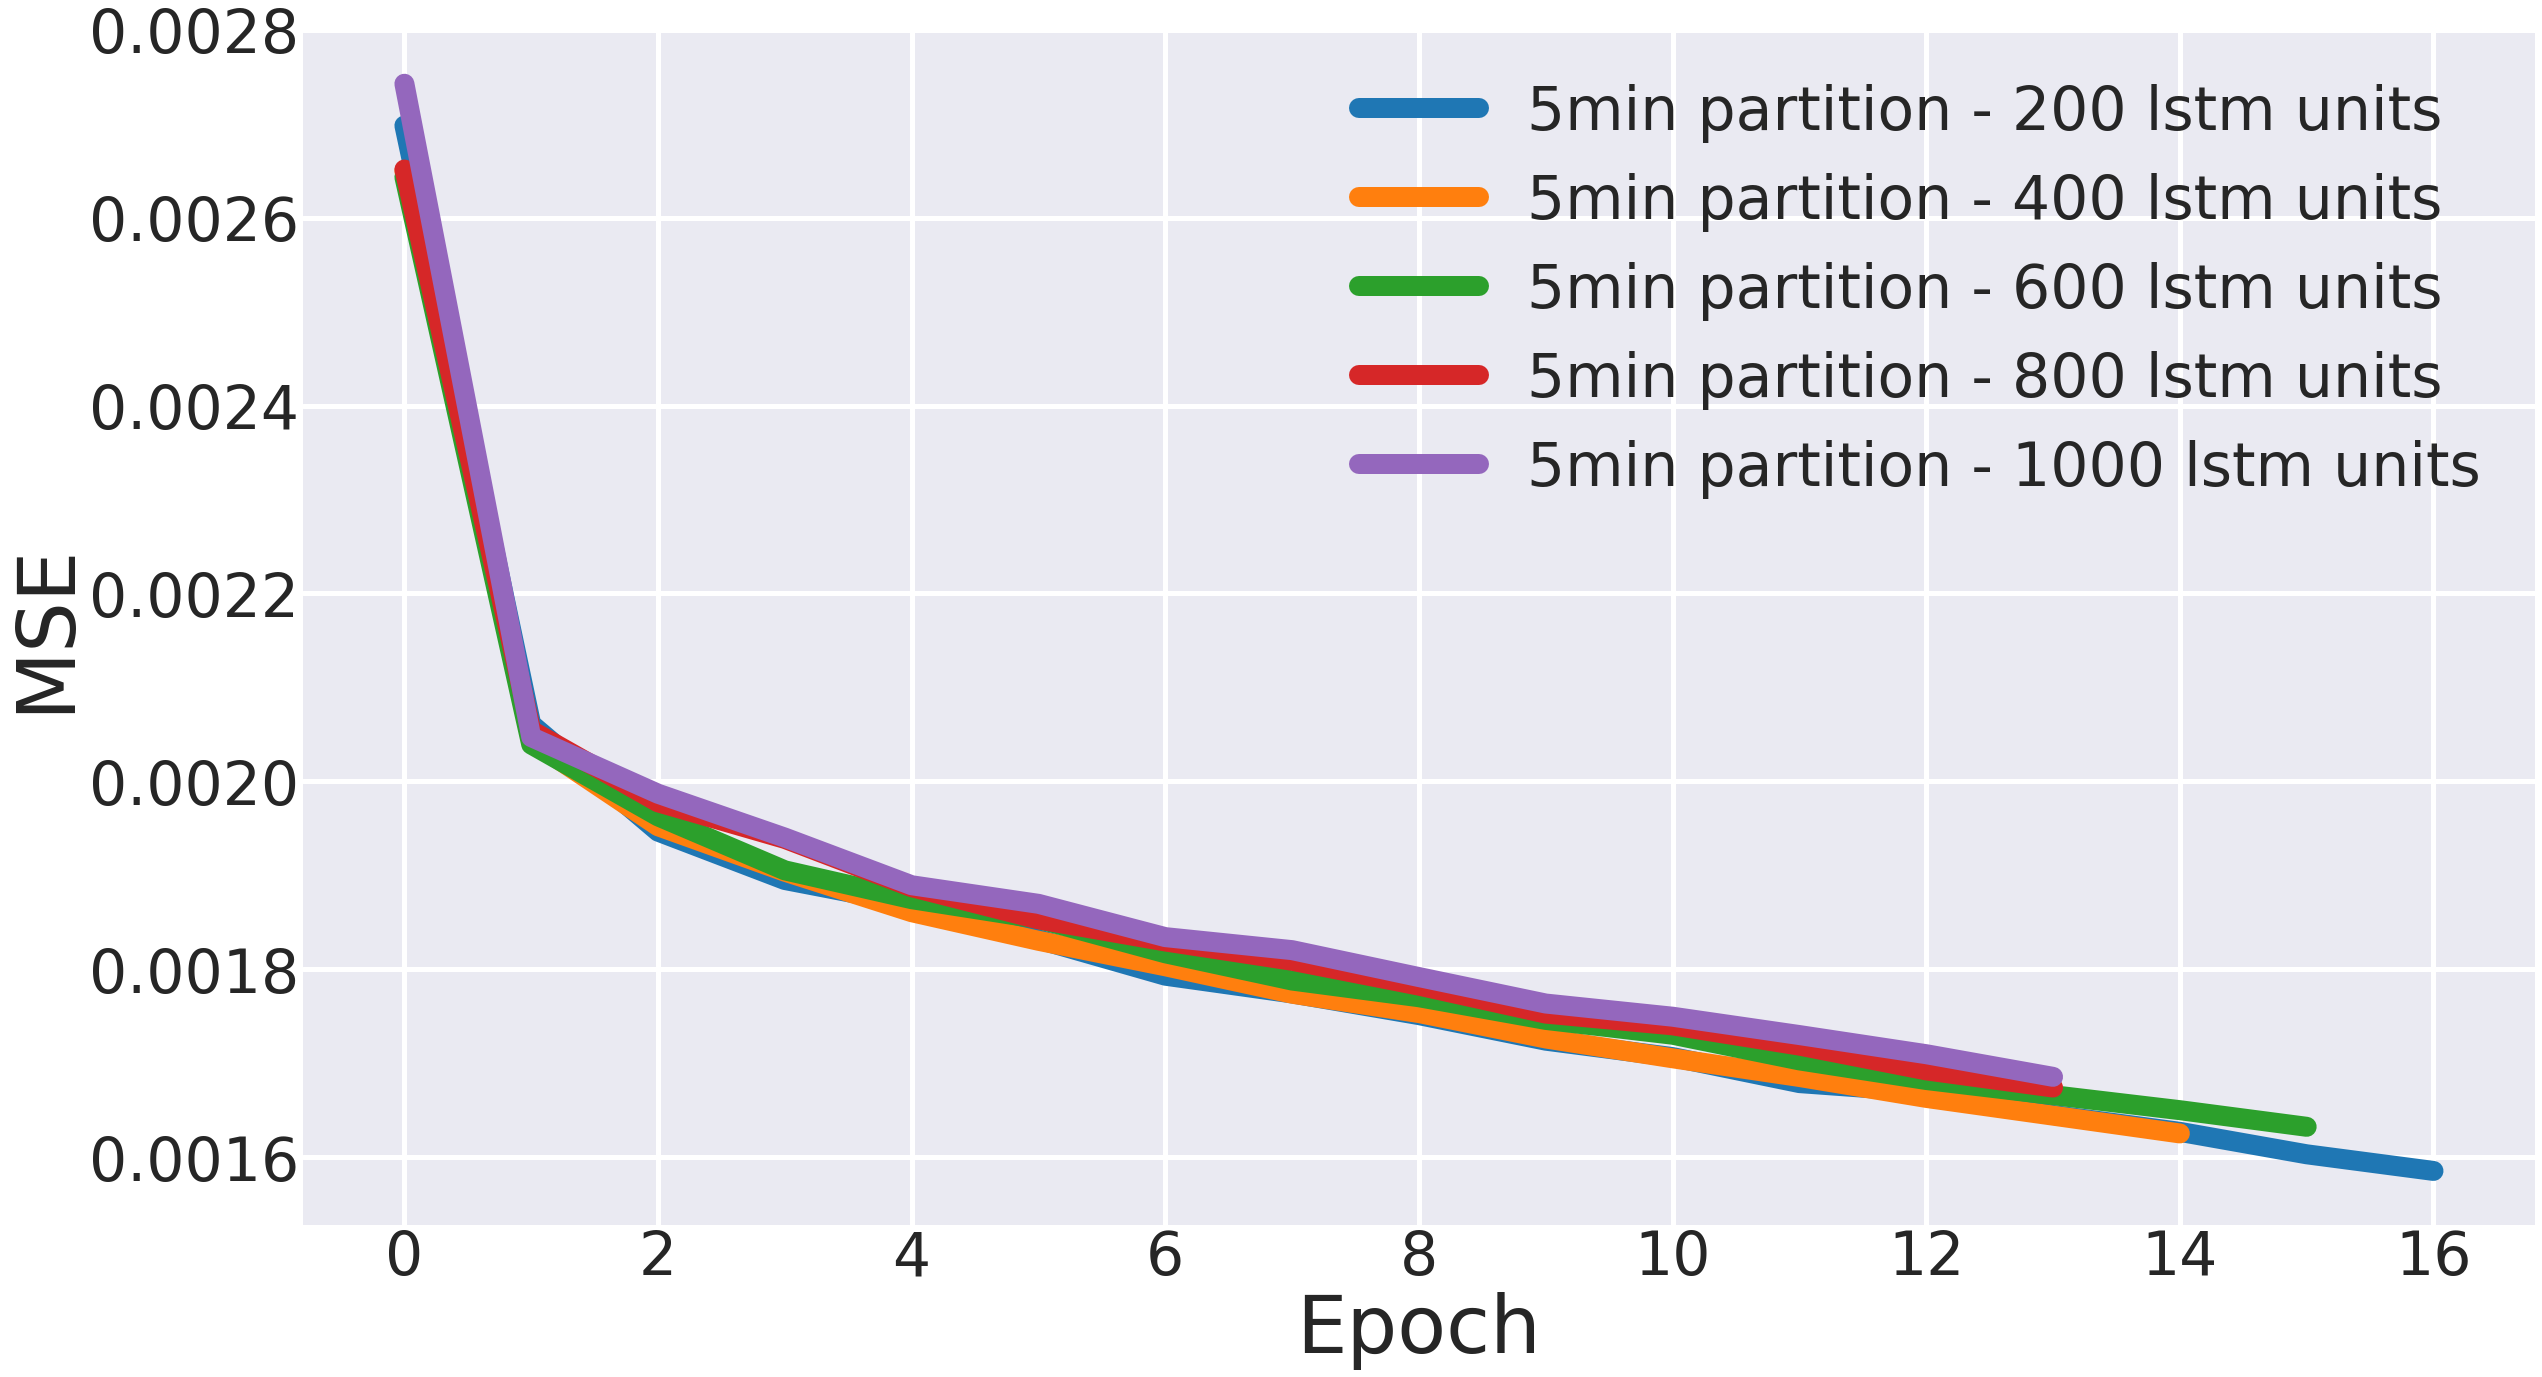

In [20]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
loss_5min_plot = loss_5min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_5min_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_5min_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_5min_plot.grid(linewidth=5)

In [21]:
%%spark -o val_loss_5min_df

val_loss_5min_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses[7:12]).transpose().tolist()), 
    np.array(labels[7:12]).tolist()
)

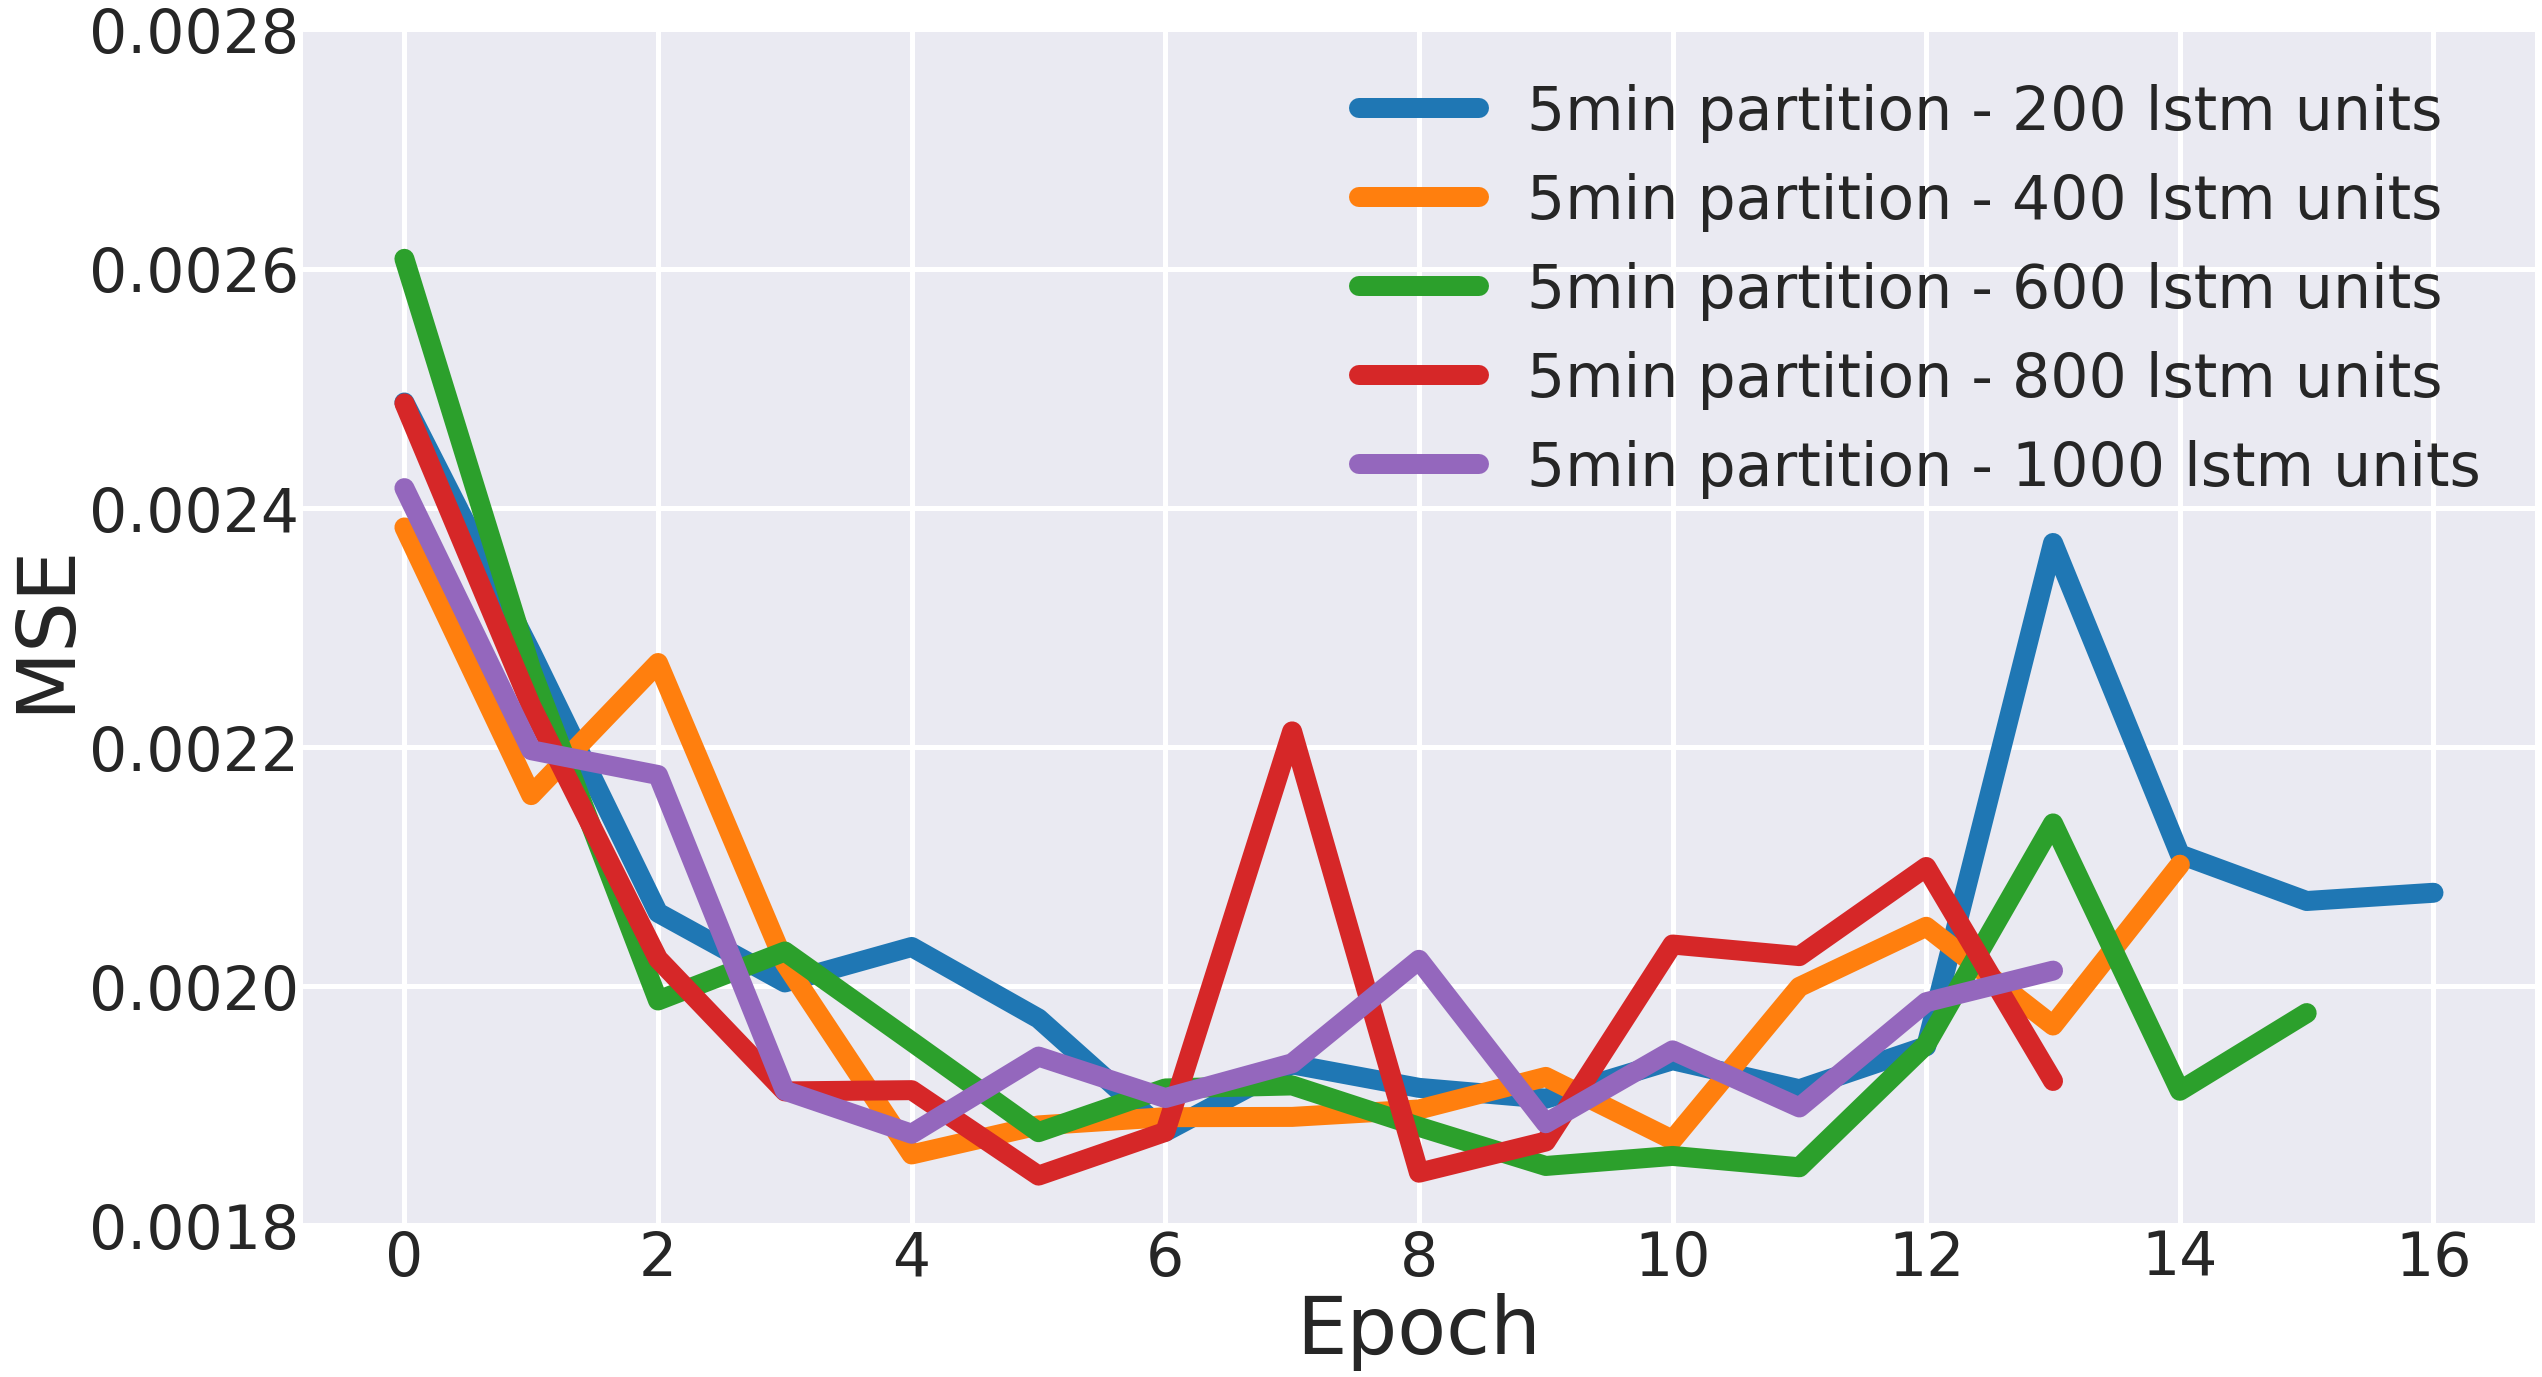

In [22]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
val_loss_5min_plot = val_loss_5min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
val_loss_5min_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_5min_plot.set_ylabel("MSE", {'size':ylabel_size})
val_loss_5min_plot.set_ylim(0.0018, 0.0028)
val_loss_5min_plot.grid(linewidth=5)

In [23]:
%%spark -o training_time_5min_df

training_time_5min_df = spark.createDataFrame(
    sc.parallelize(zip(
        partition_tuning[1][2], 
        np.array(training_times)[7:12].tolist()
    )),
    ("index", "LSTM")
)

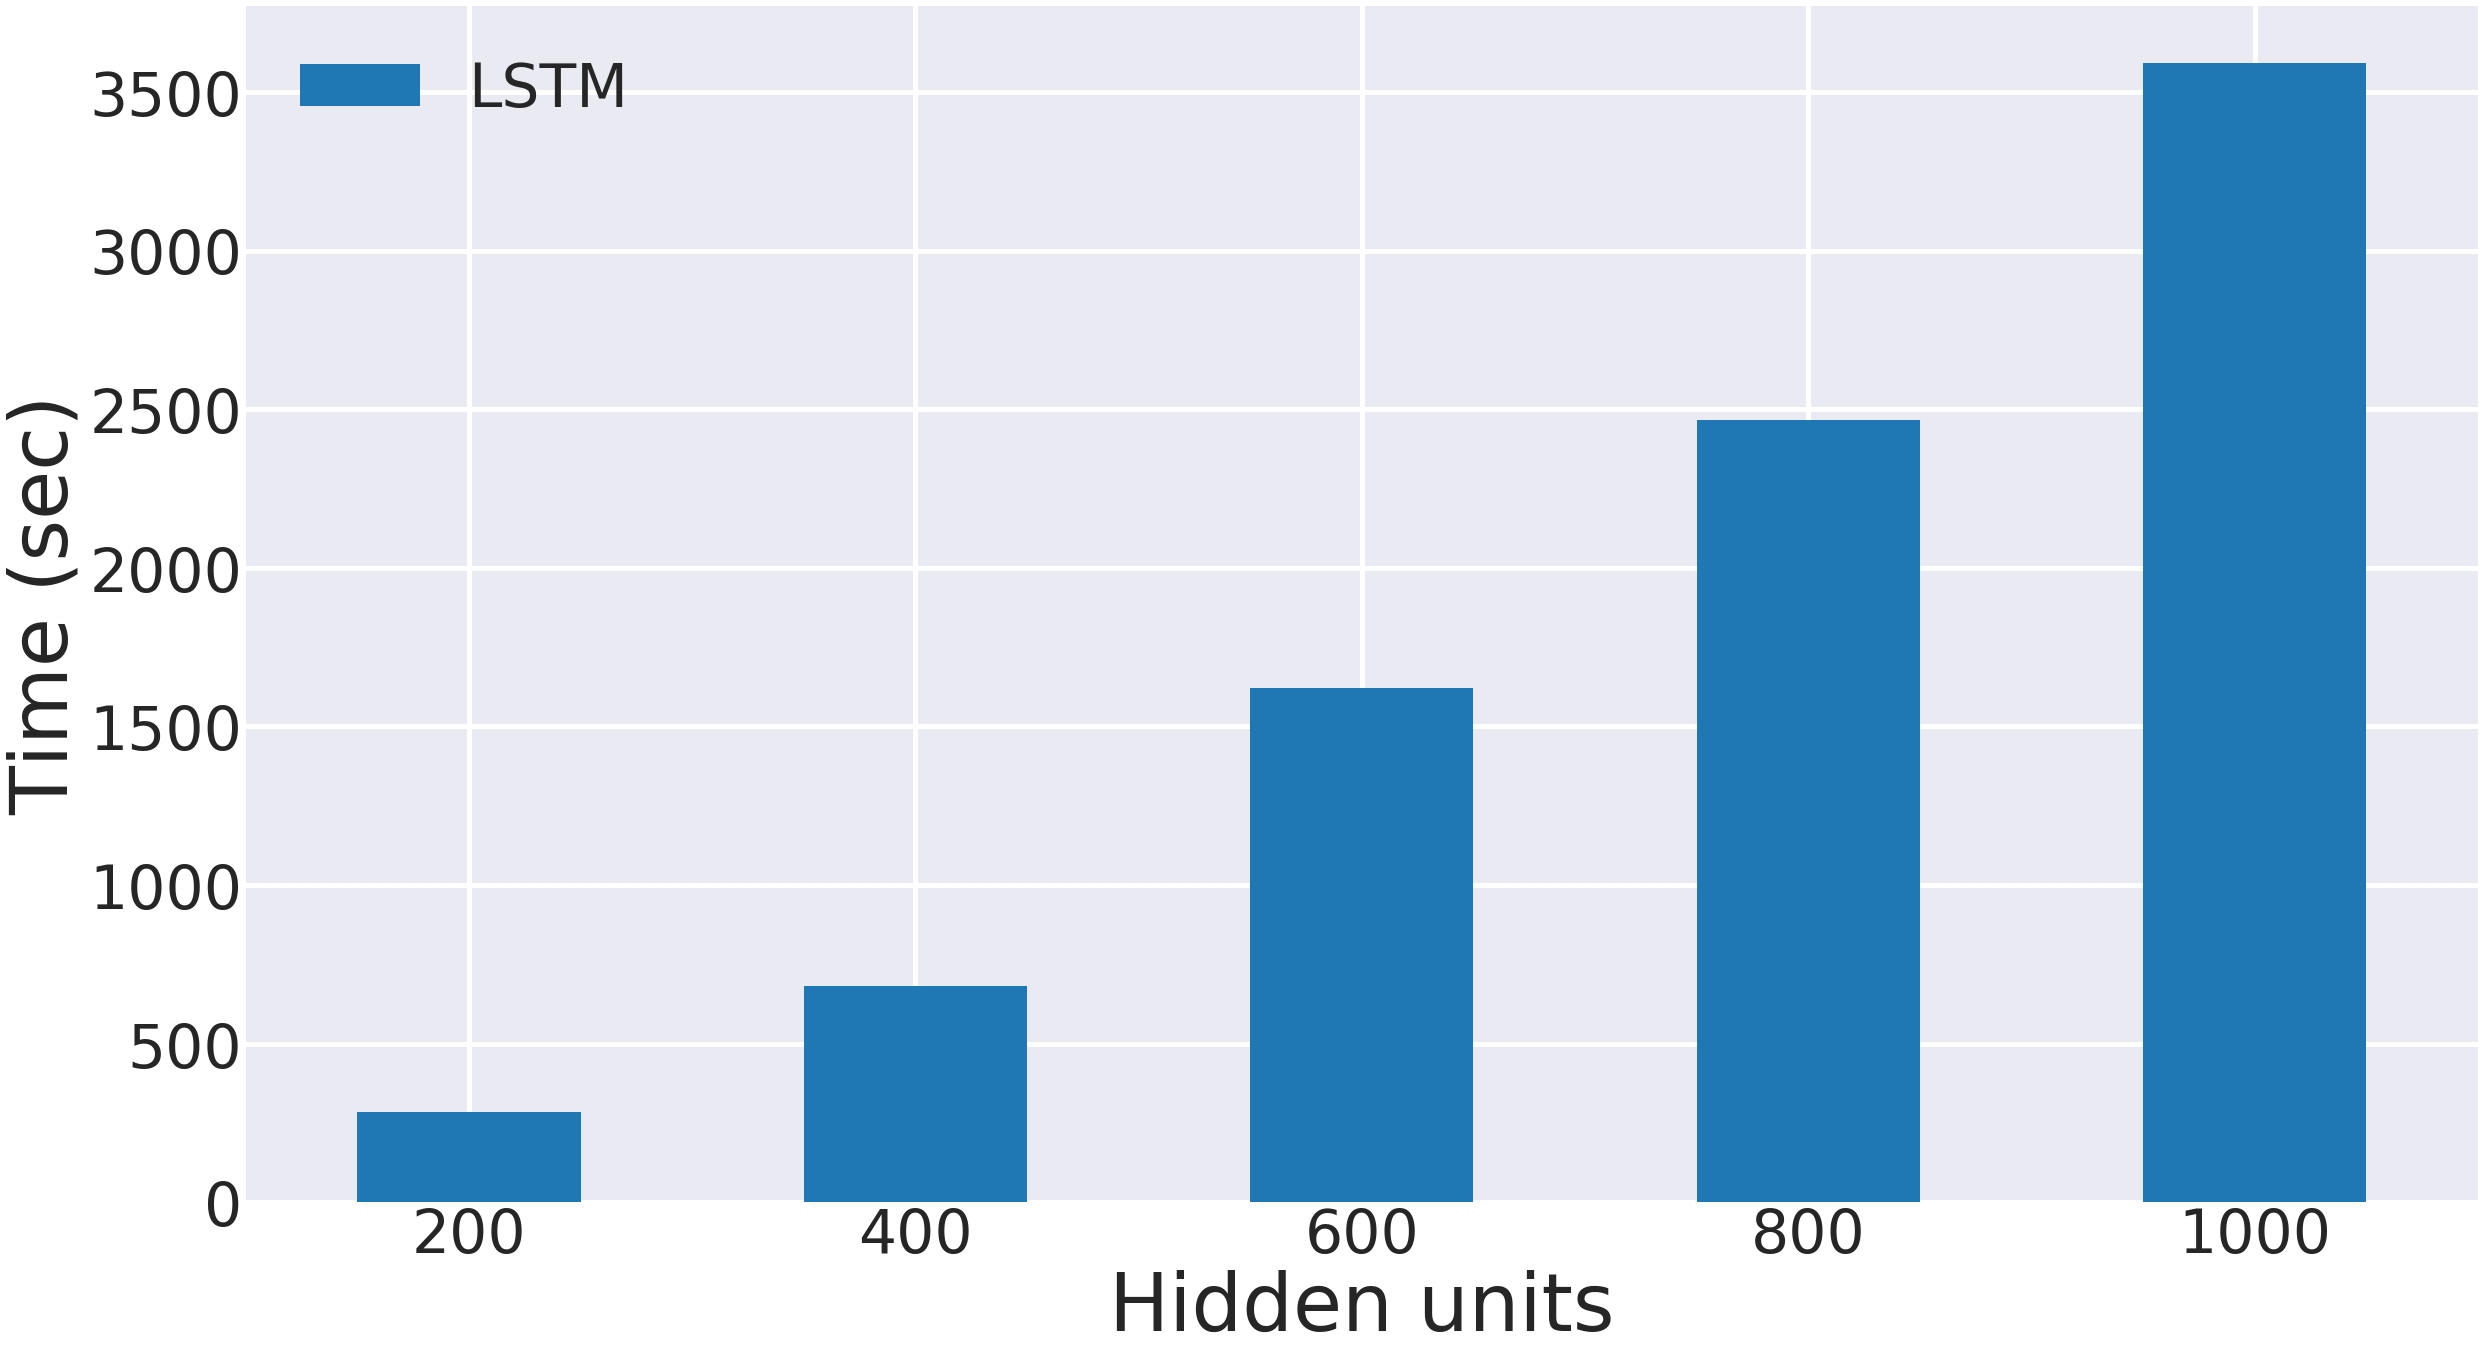

In [24]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_5min_plot = training_time_5min_df.set_index('index').plot.bar(figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0)
 
training_time_5min_plot.set_xlabel("Hidden units", {'size':xlabel_size})
training_time_5min_plot.set_ylabel("Time (sec)", {'size':ylabel_size})
training_time_5min_plot.grid(linewidth=5)

### 10 Minute Partitions

In [25]:
%%spark -o loss_10min_df

loss_10min_df = spark.createDataFrame(
    sc.parallelize(np.array(losses[12:17]).transpose().tolist()), 
    np.array(labels[12:17]).tolist()
)

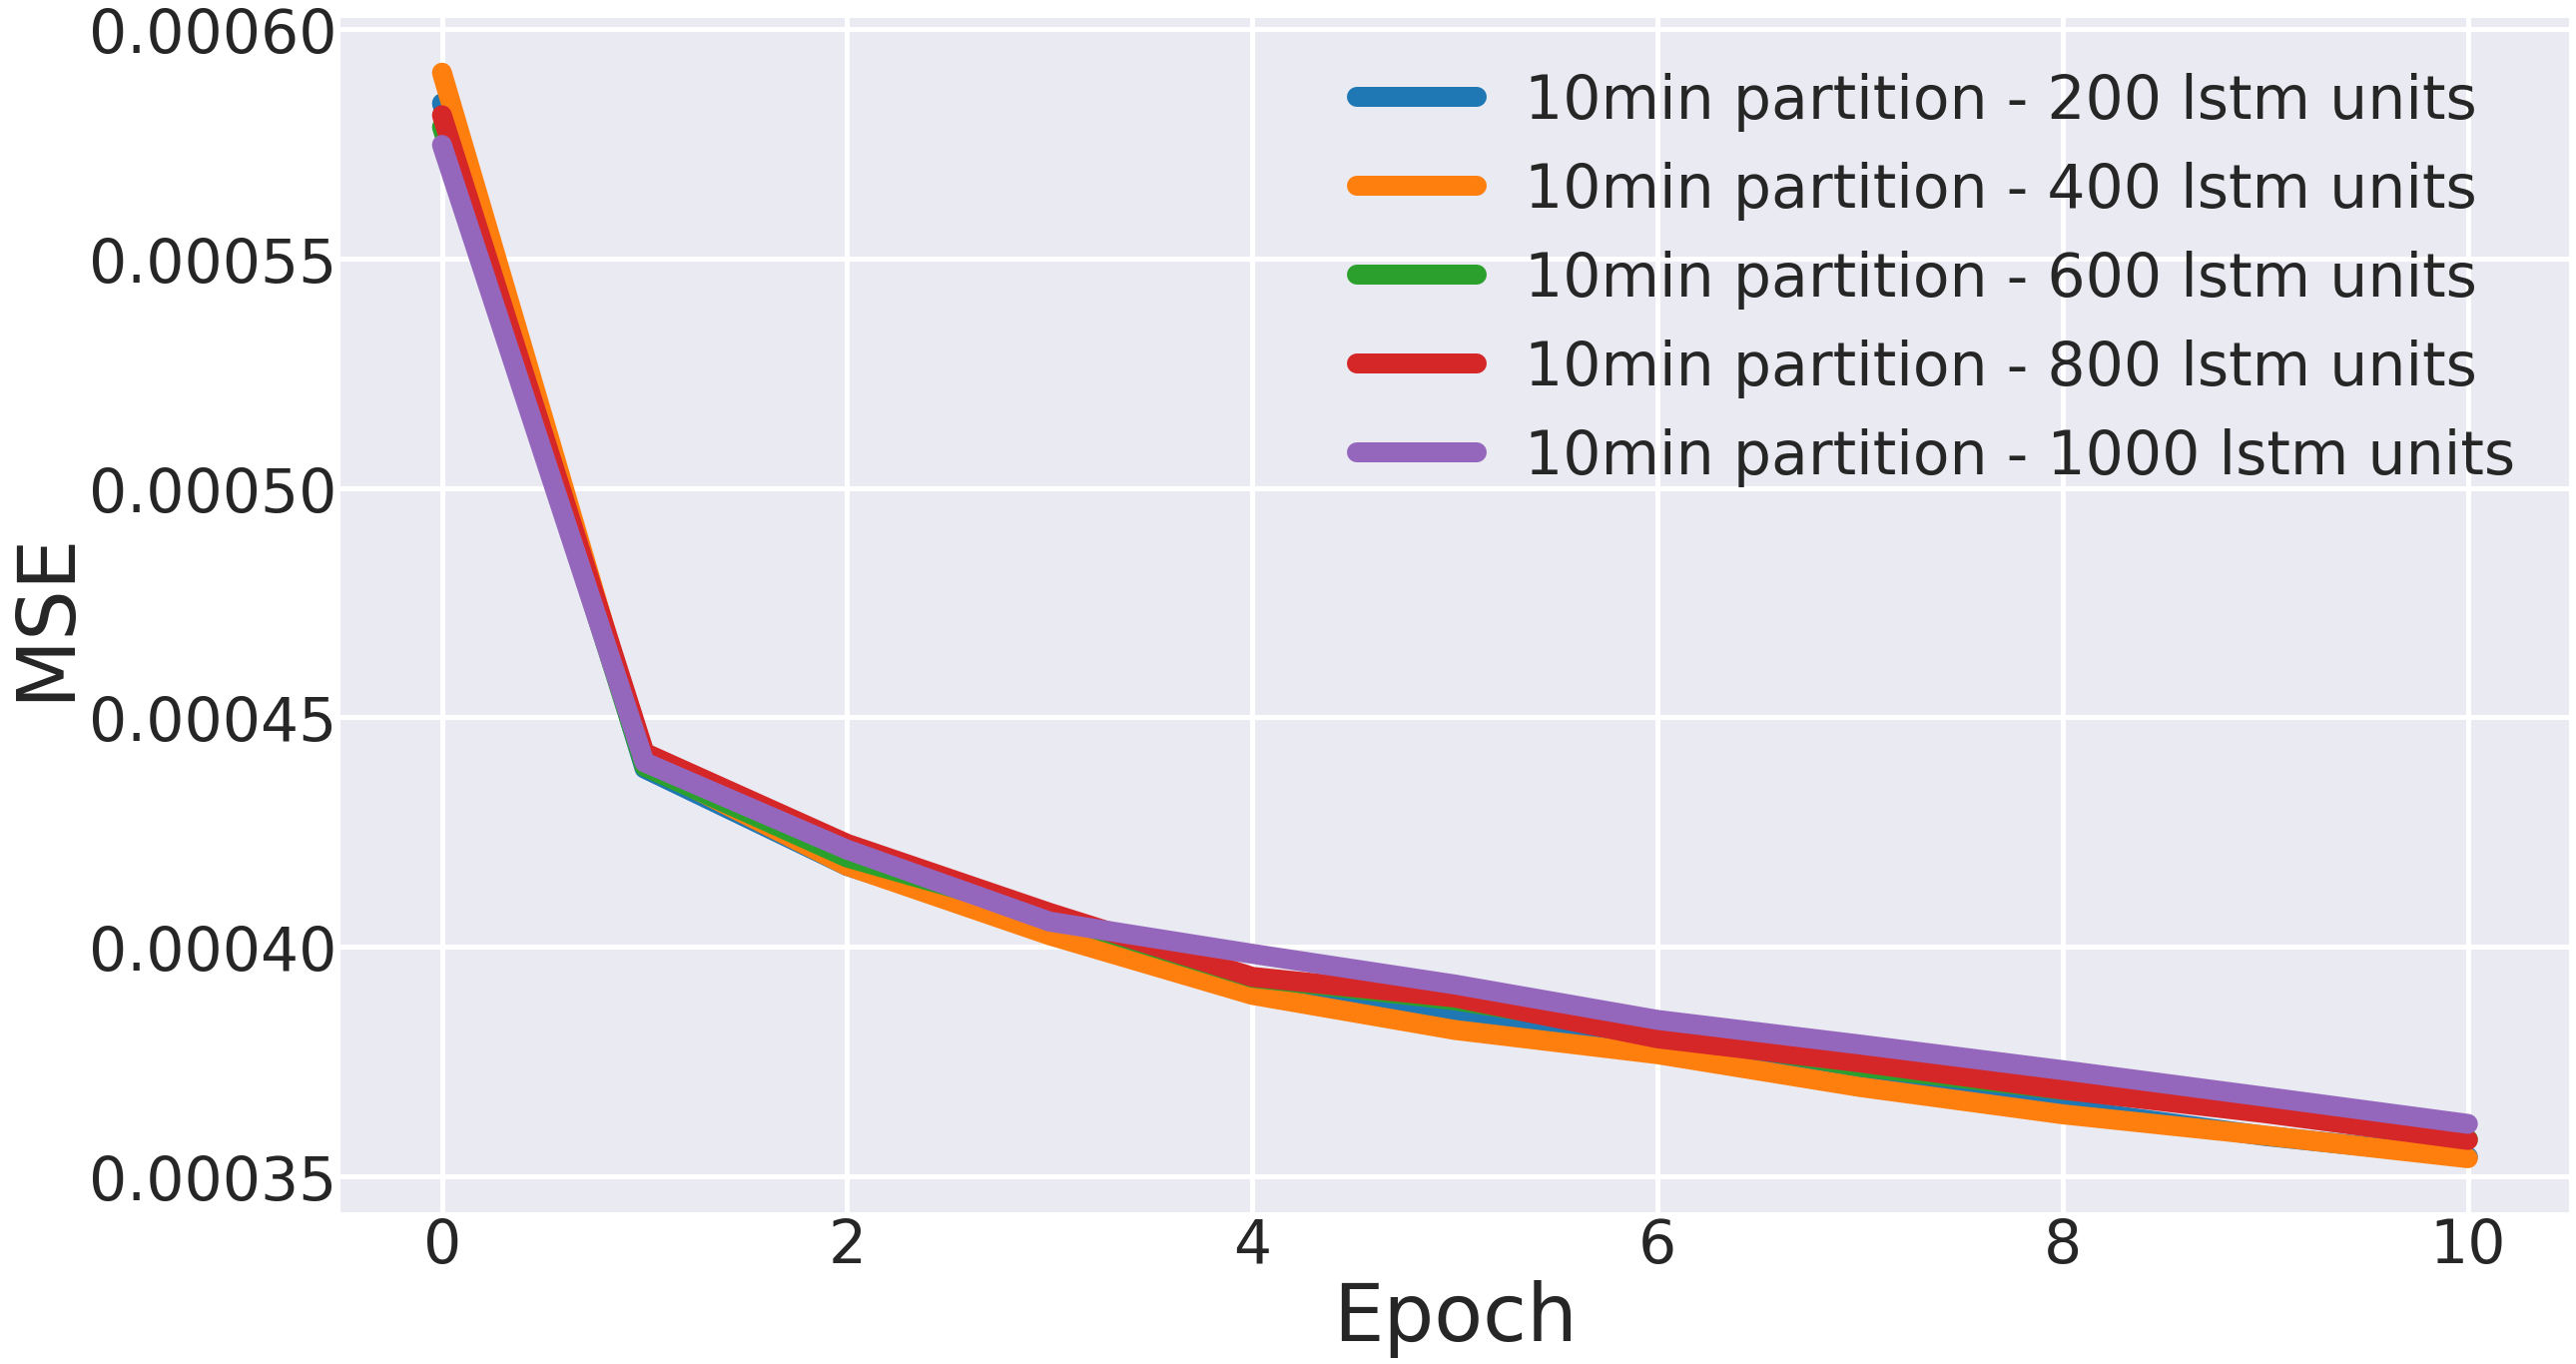

In [26]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
loss_10min_plot = loss_10min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_10min_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_10min_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_10min_plot.grid(linewidth=5)

In [27]:
%%spark -o val_loss_10min_df

val_loss_10min_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses[12:17]).transpose().tolist()), 
    np.array(labels[12:17]).tolist()
)

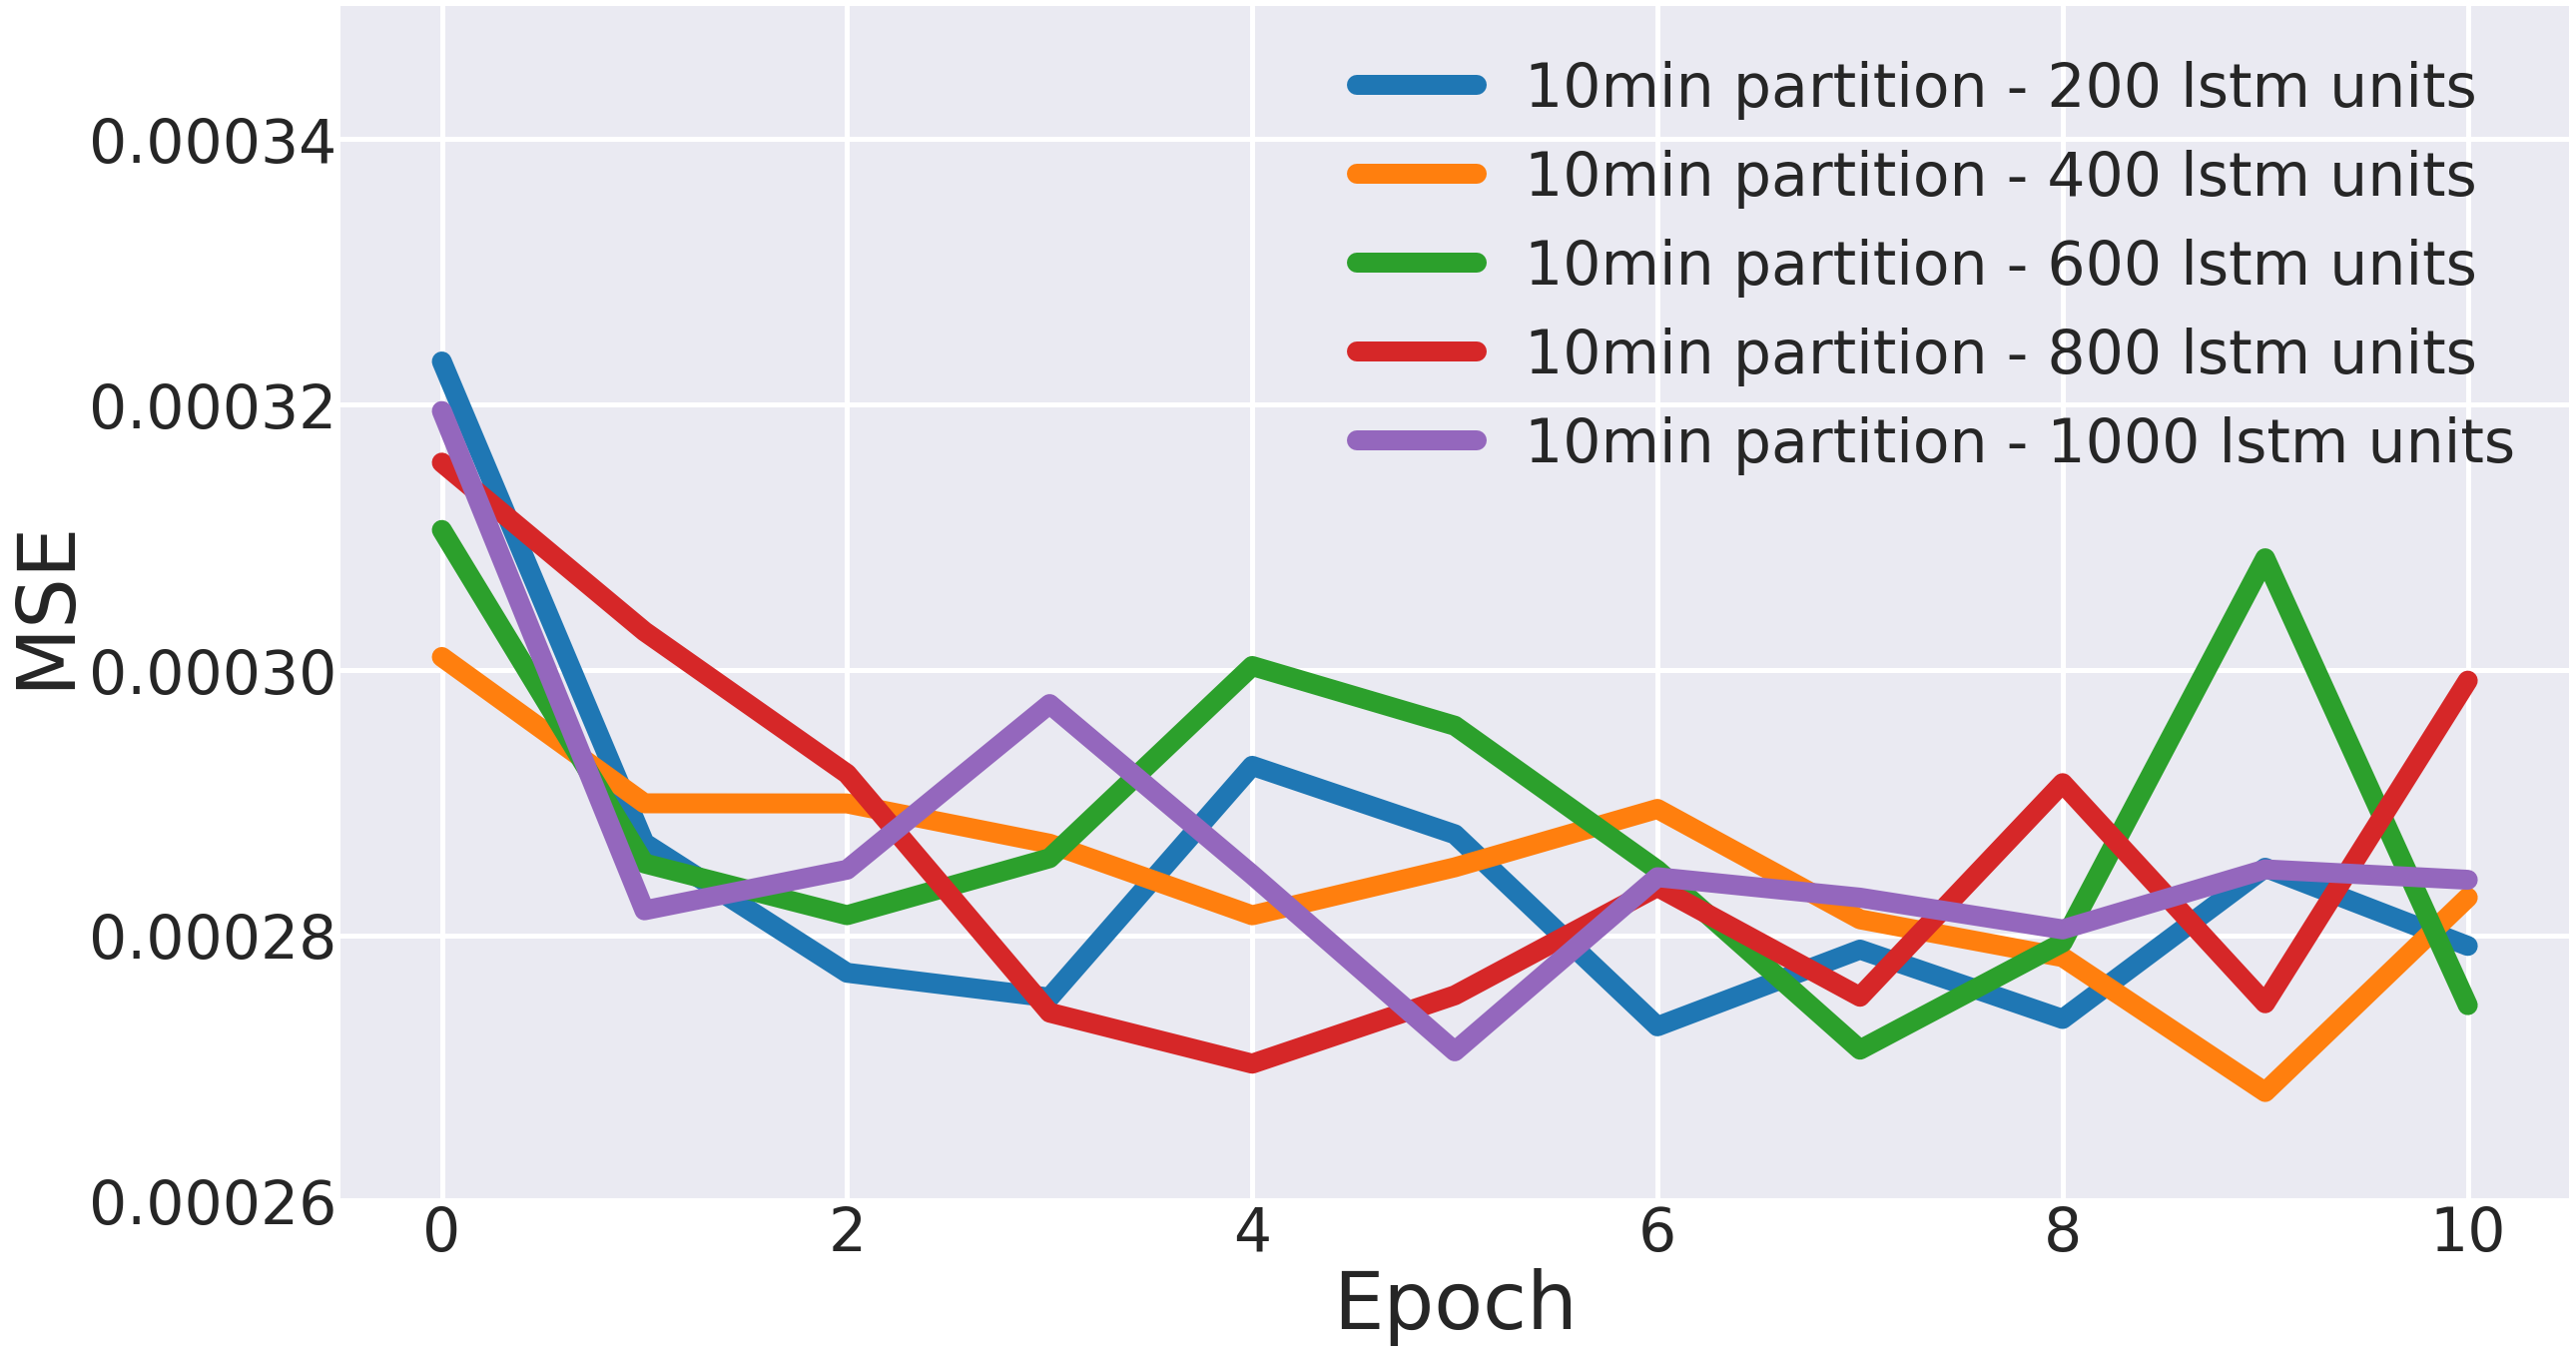

In [28]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
val_loss_10min_plot = val_loss_10min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
val_loss_10min_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_10min_plot.set_ylabel("MSE", {'size':ylabel_size})
val_loss_10min_plot.set_ylim(0.00026, 0.00035)
val_loss_10min_plot.grid(linewidth=5)

In [29]:
%%spark -o training_time_10min_df

training_time_10min_df = spark.createDataFrame(
    sc.parallelize(zip(
        partition_tuning[2][2], 
        np.array(training_times)[12:17].tolist()
    )),
    ("index", "LSTM")
)

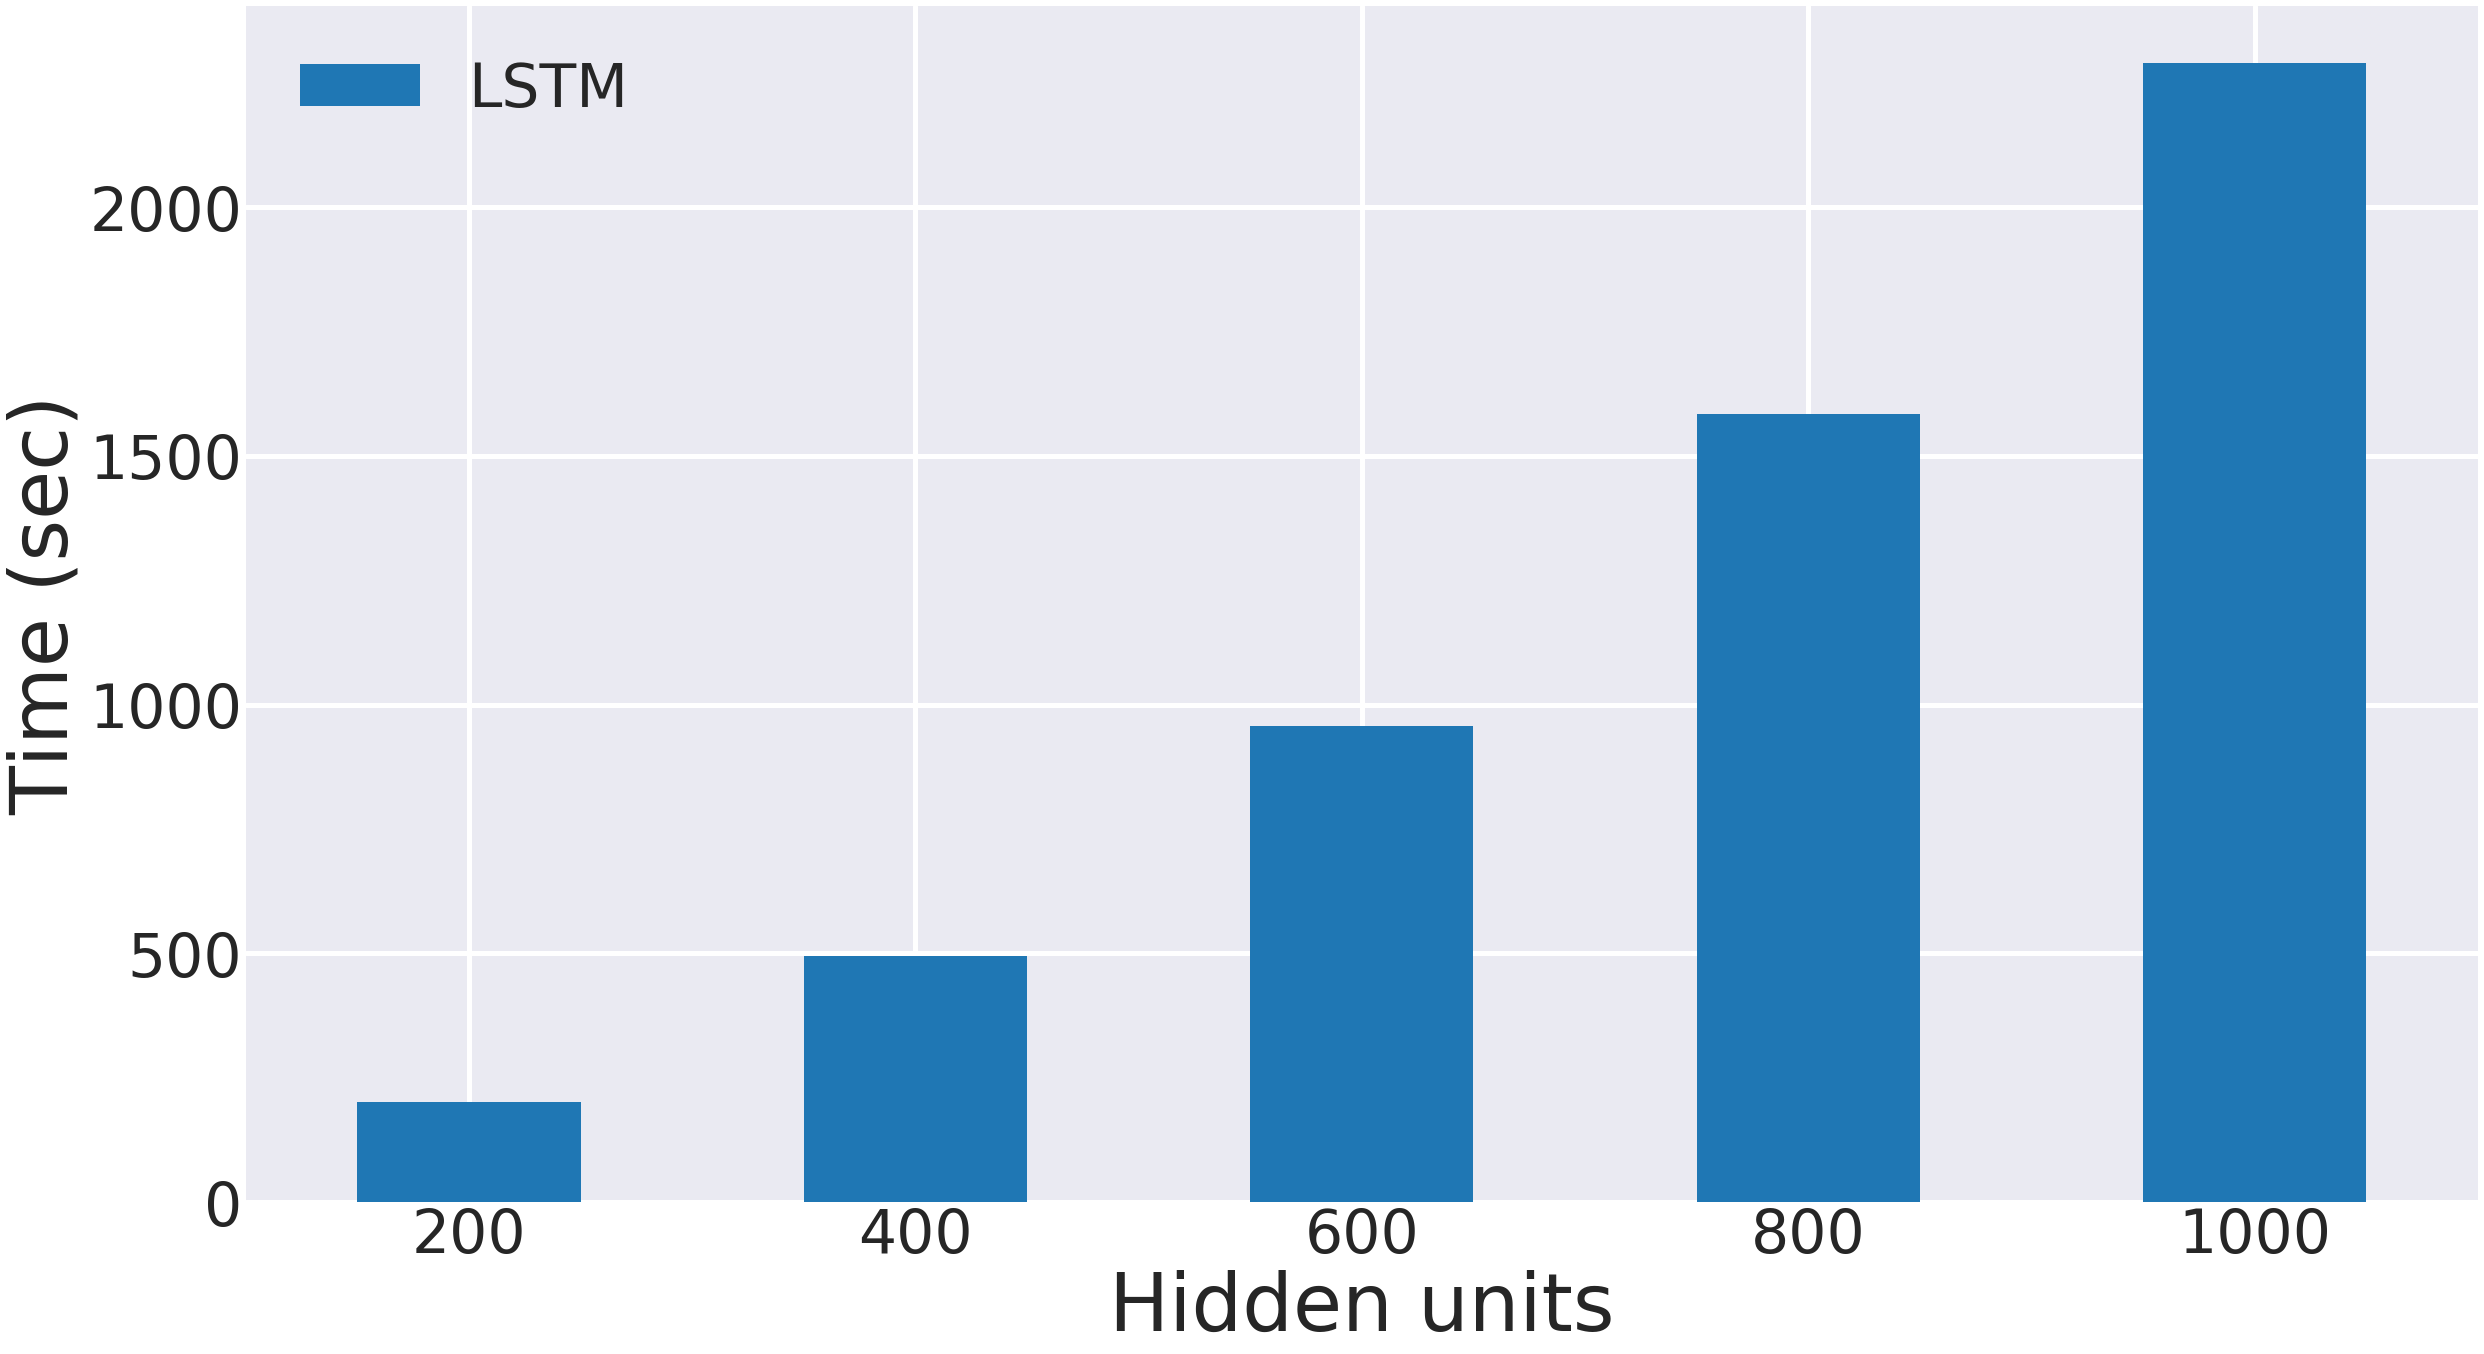

In [30]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_10min_plot = training_time_10min_df.set_index('index').plot.bar(figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0)
 
training_time_10min_plot.set_xlabel("Hidden units", {'size':xlabel_size})
training_time_10min_plot.set_ylabel("Time (sec)", {'size':ylabel_size})
training_time_10min_plot.grid(linewidth=5)

### 20 Minute Partitions

In [31]:
%%spark -o loss_20min_df

loss_20min_df = spark.createDataFrame(
    sc.parallelize(np.array(losses[17:22]).transpose().tolist()), 
    np.array(labels[17:22]).tolist()
)

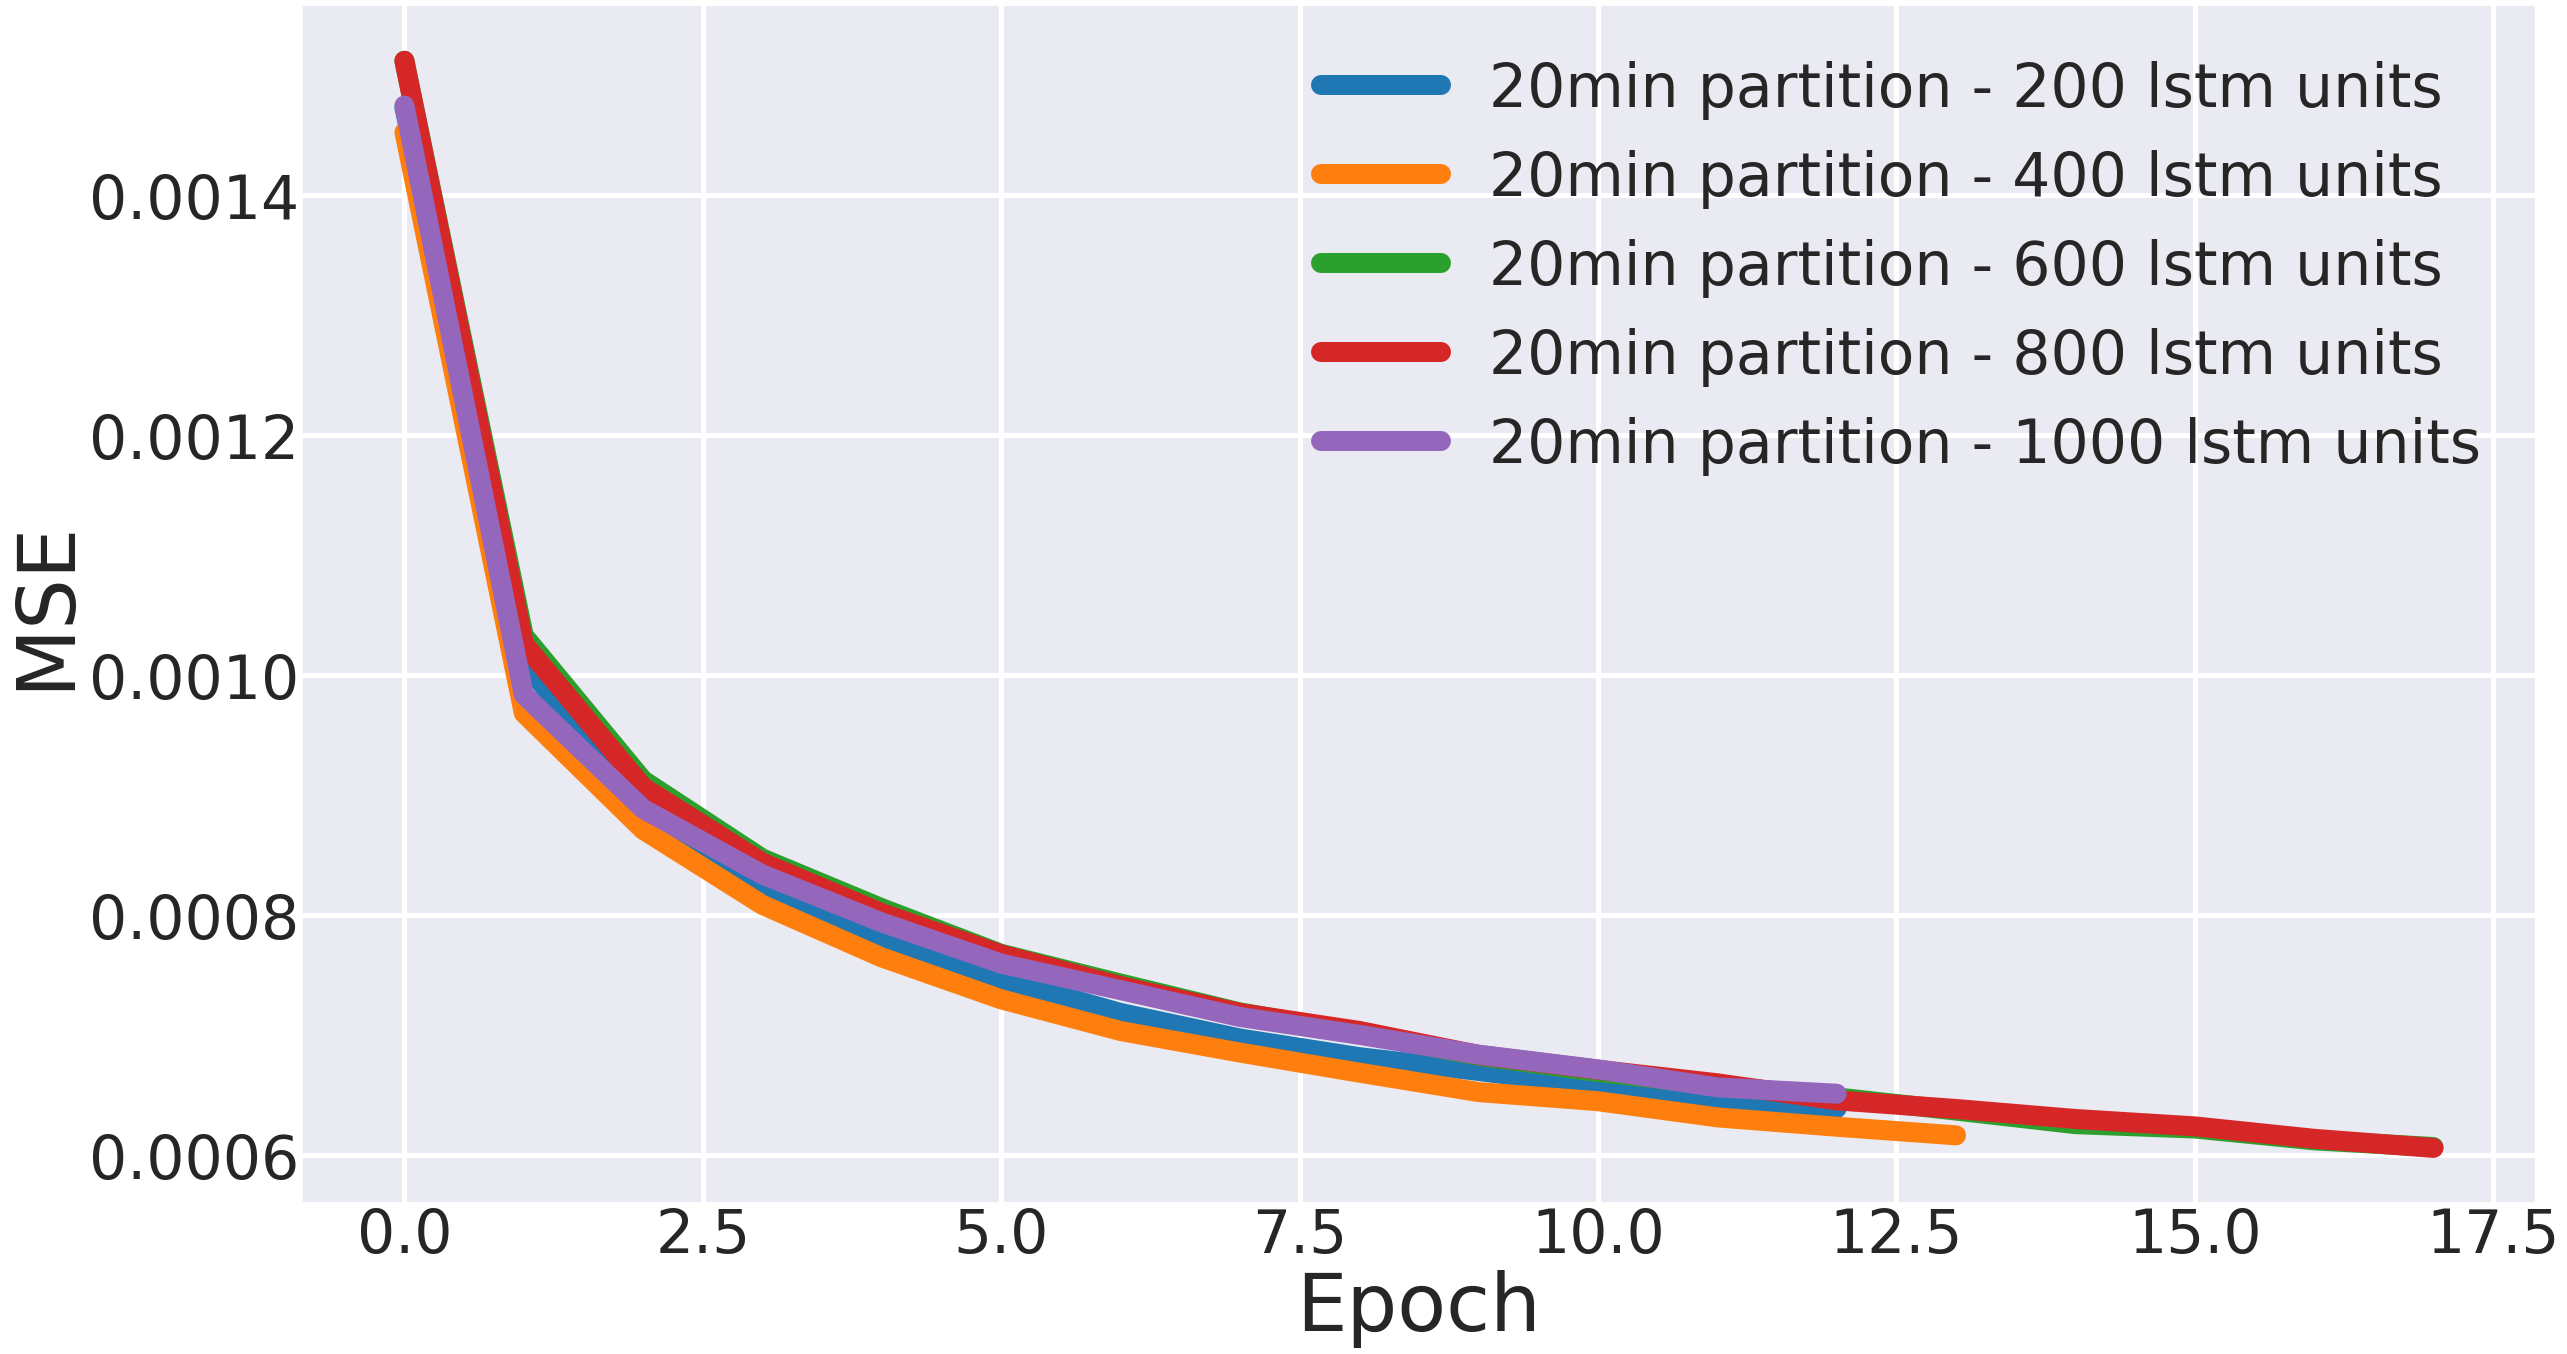

In [32]:
%%local
plt.rc('font', **{'weight' : 'normal','size' : font_size})
loss_20min_plot = loss_20min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_20min_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_20min_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_20min_plot.grid(linewidth=5)

In [33]:
%%spark -o val_loss_20min_df

val_loss_20min_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses[17:22]).transpose().tolist()), 
    np.array(labels[17:22]).tolist()
)

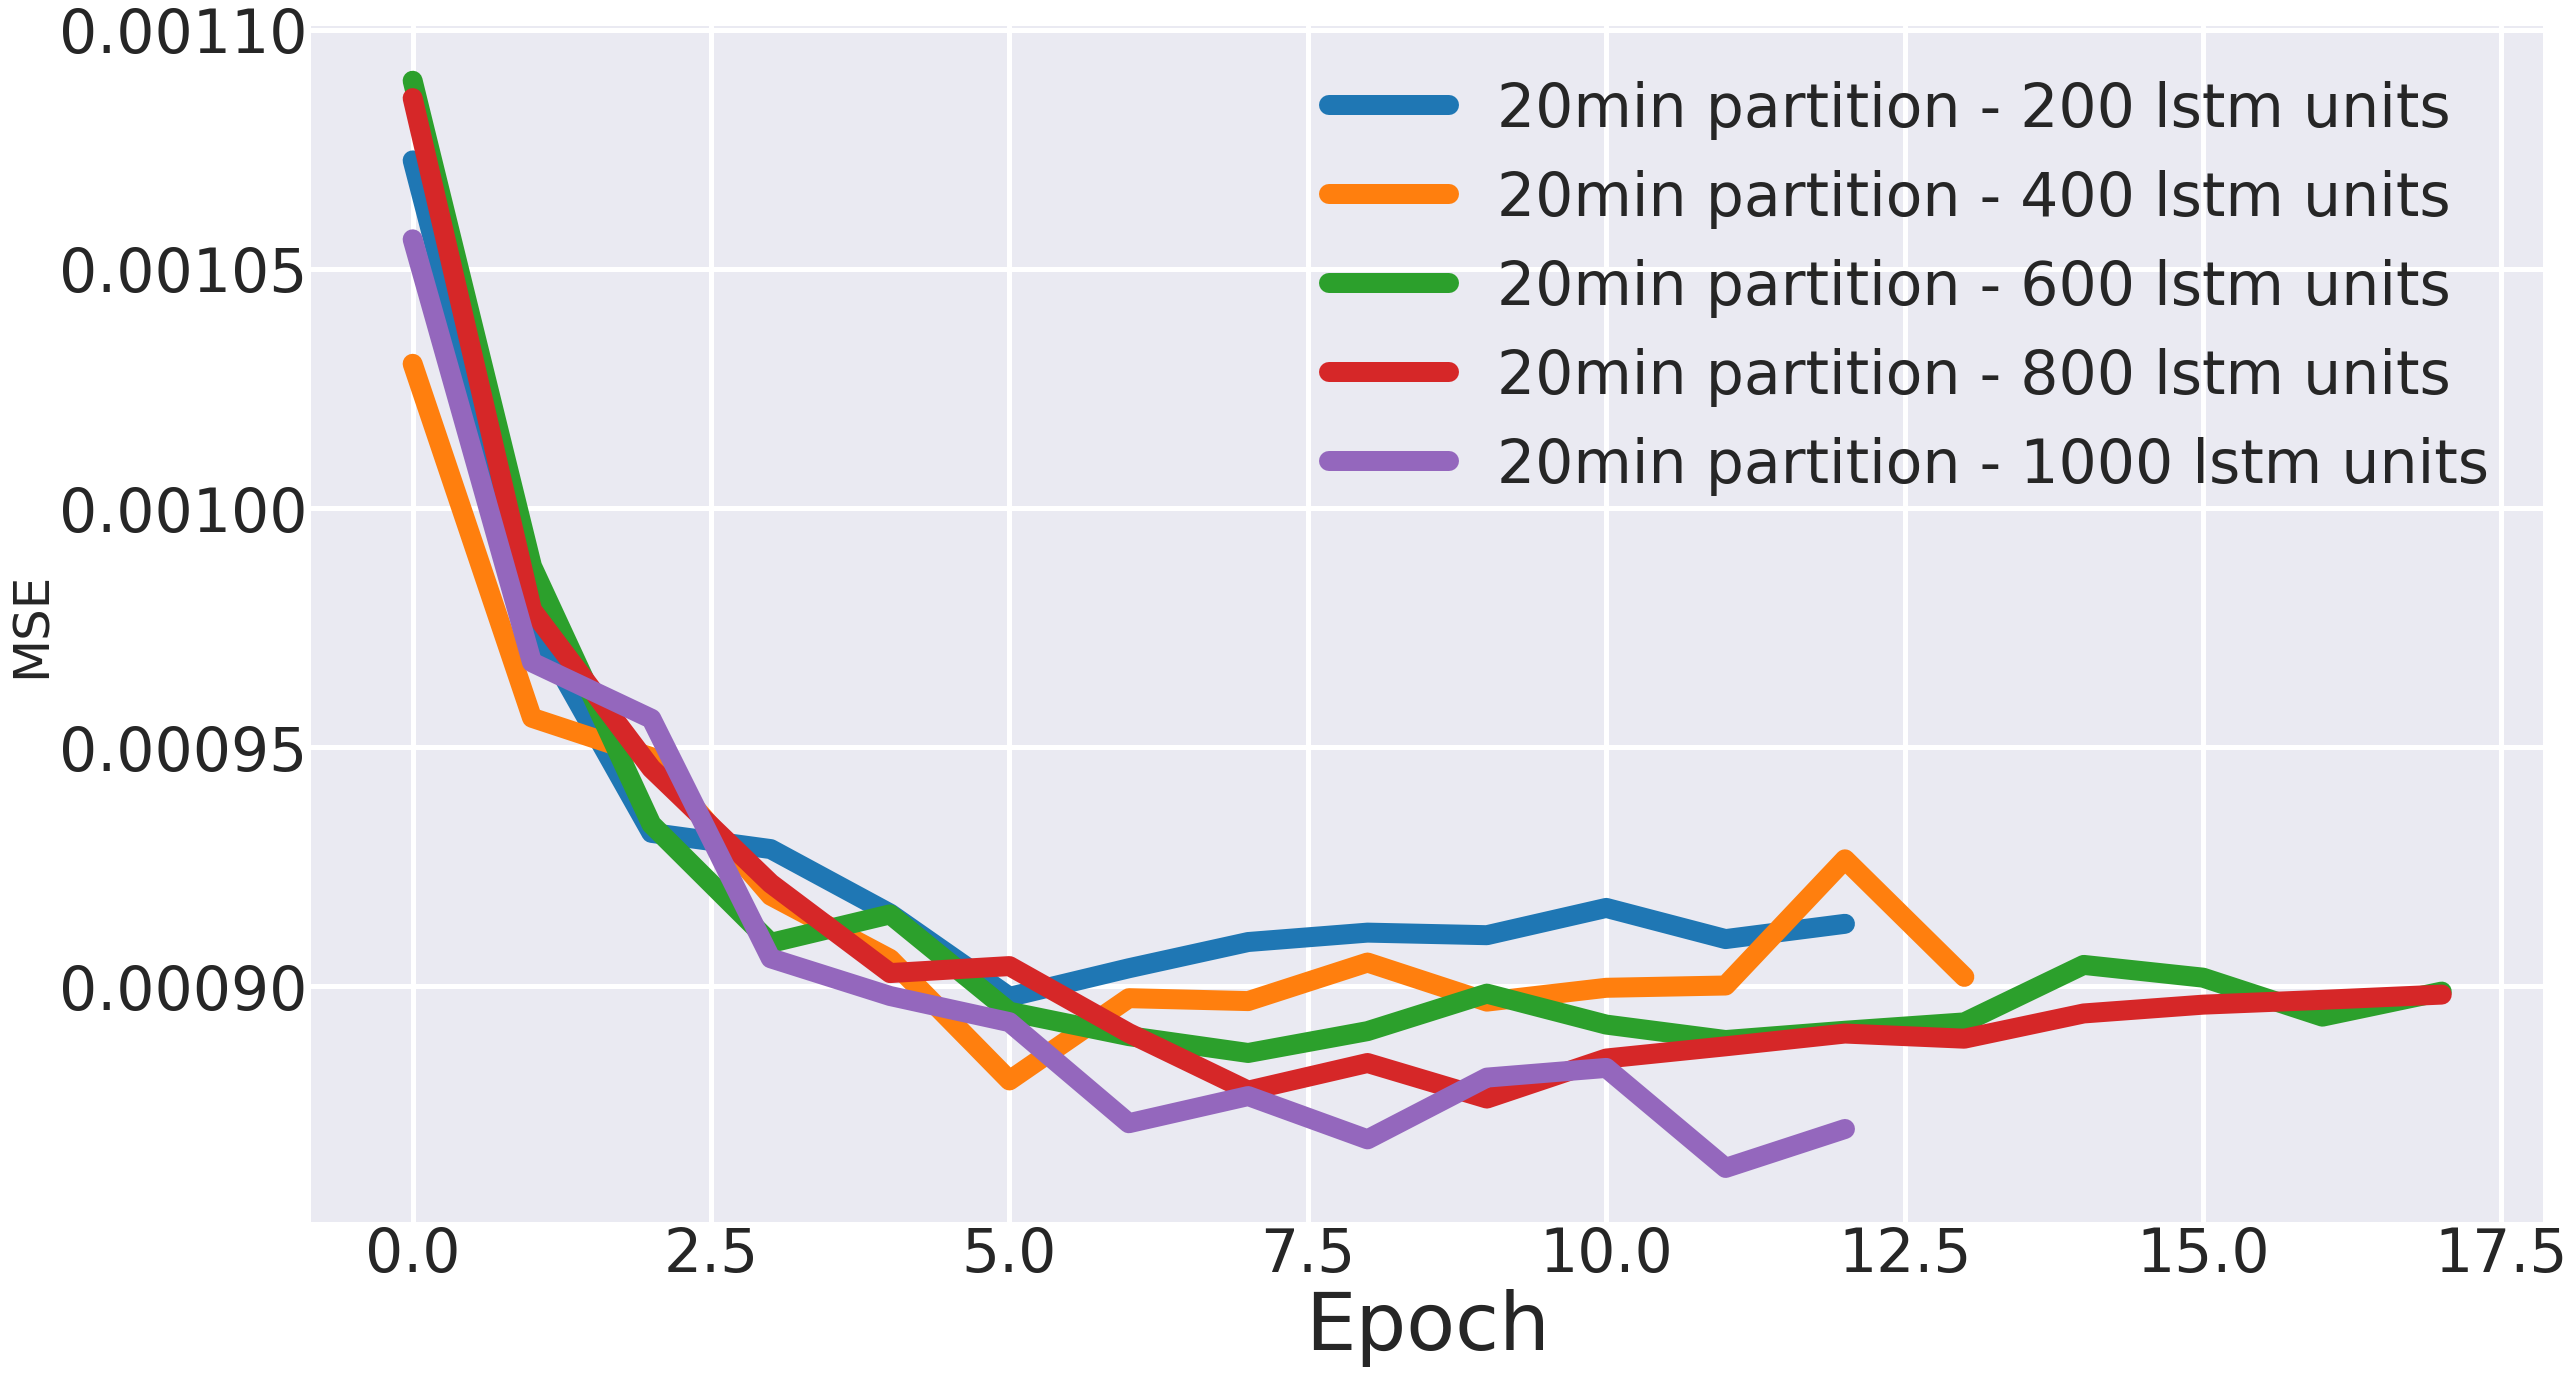

In [34]:
%%local
plt.rc('font', **{'weight' : 'normal','size' : font_size})
val_loss_20min_plot = val_loss_20min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
val_loss_20min_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_20min_plot.set_ylabel("MSE", {'size':50})
val_loss_20min_plot.grid(linewidth=5)

In [35]:
%%spark -o training_time_20min_df

training_time_20min_df = spark.createDataFrame(
    sc.parallelize(zip(
        partition_tuning[3][2], 
        np.array(training_times)[17:22].tolist()
    )),
    ("index", "LSTM")
)

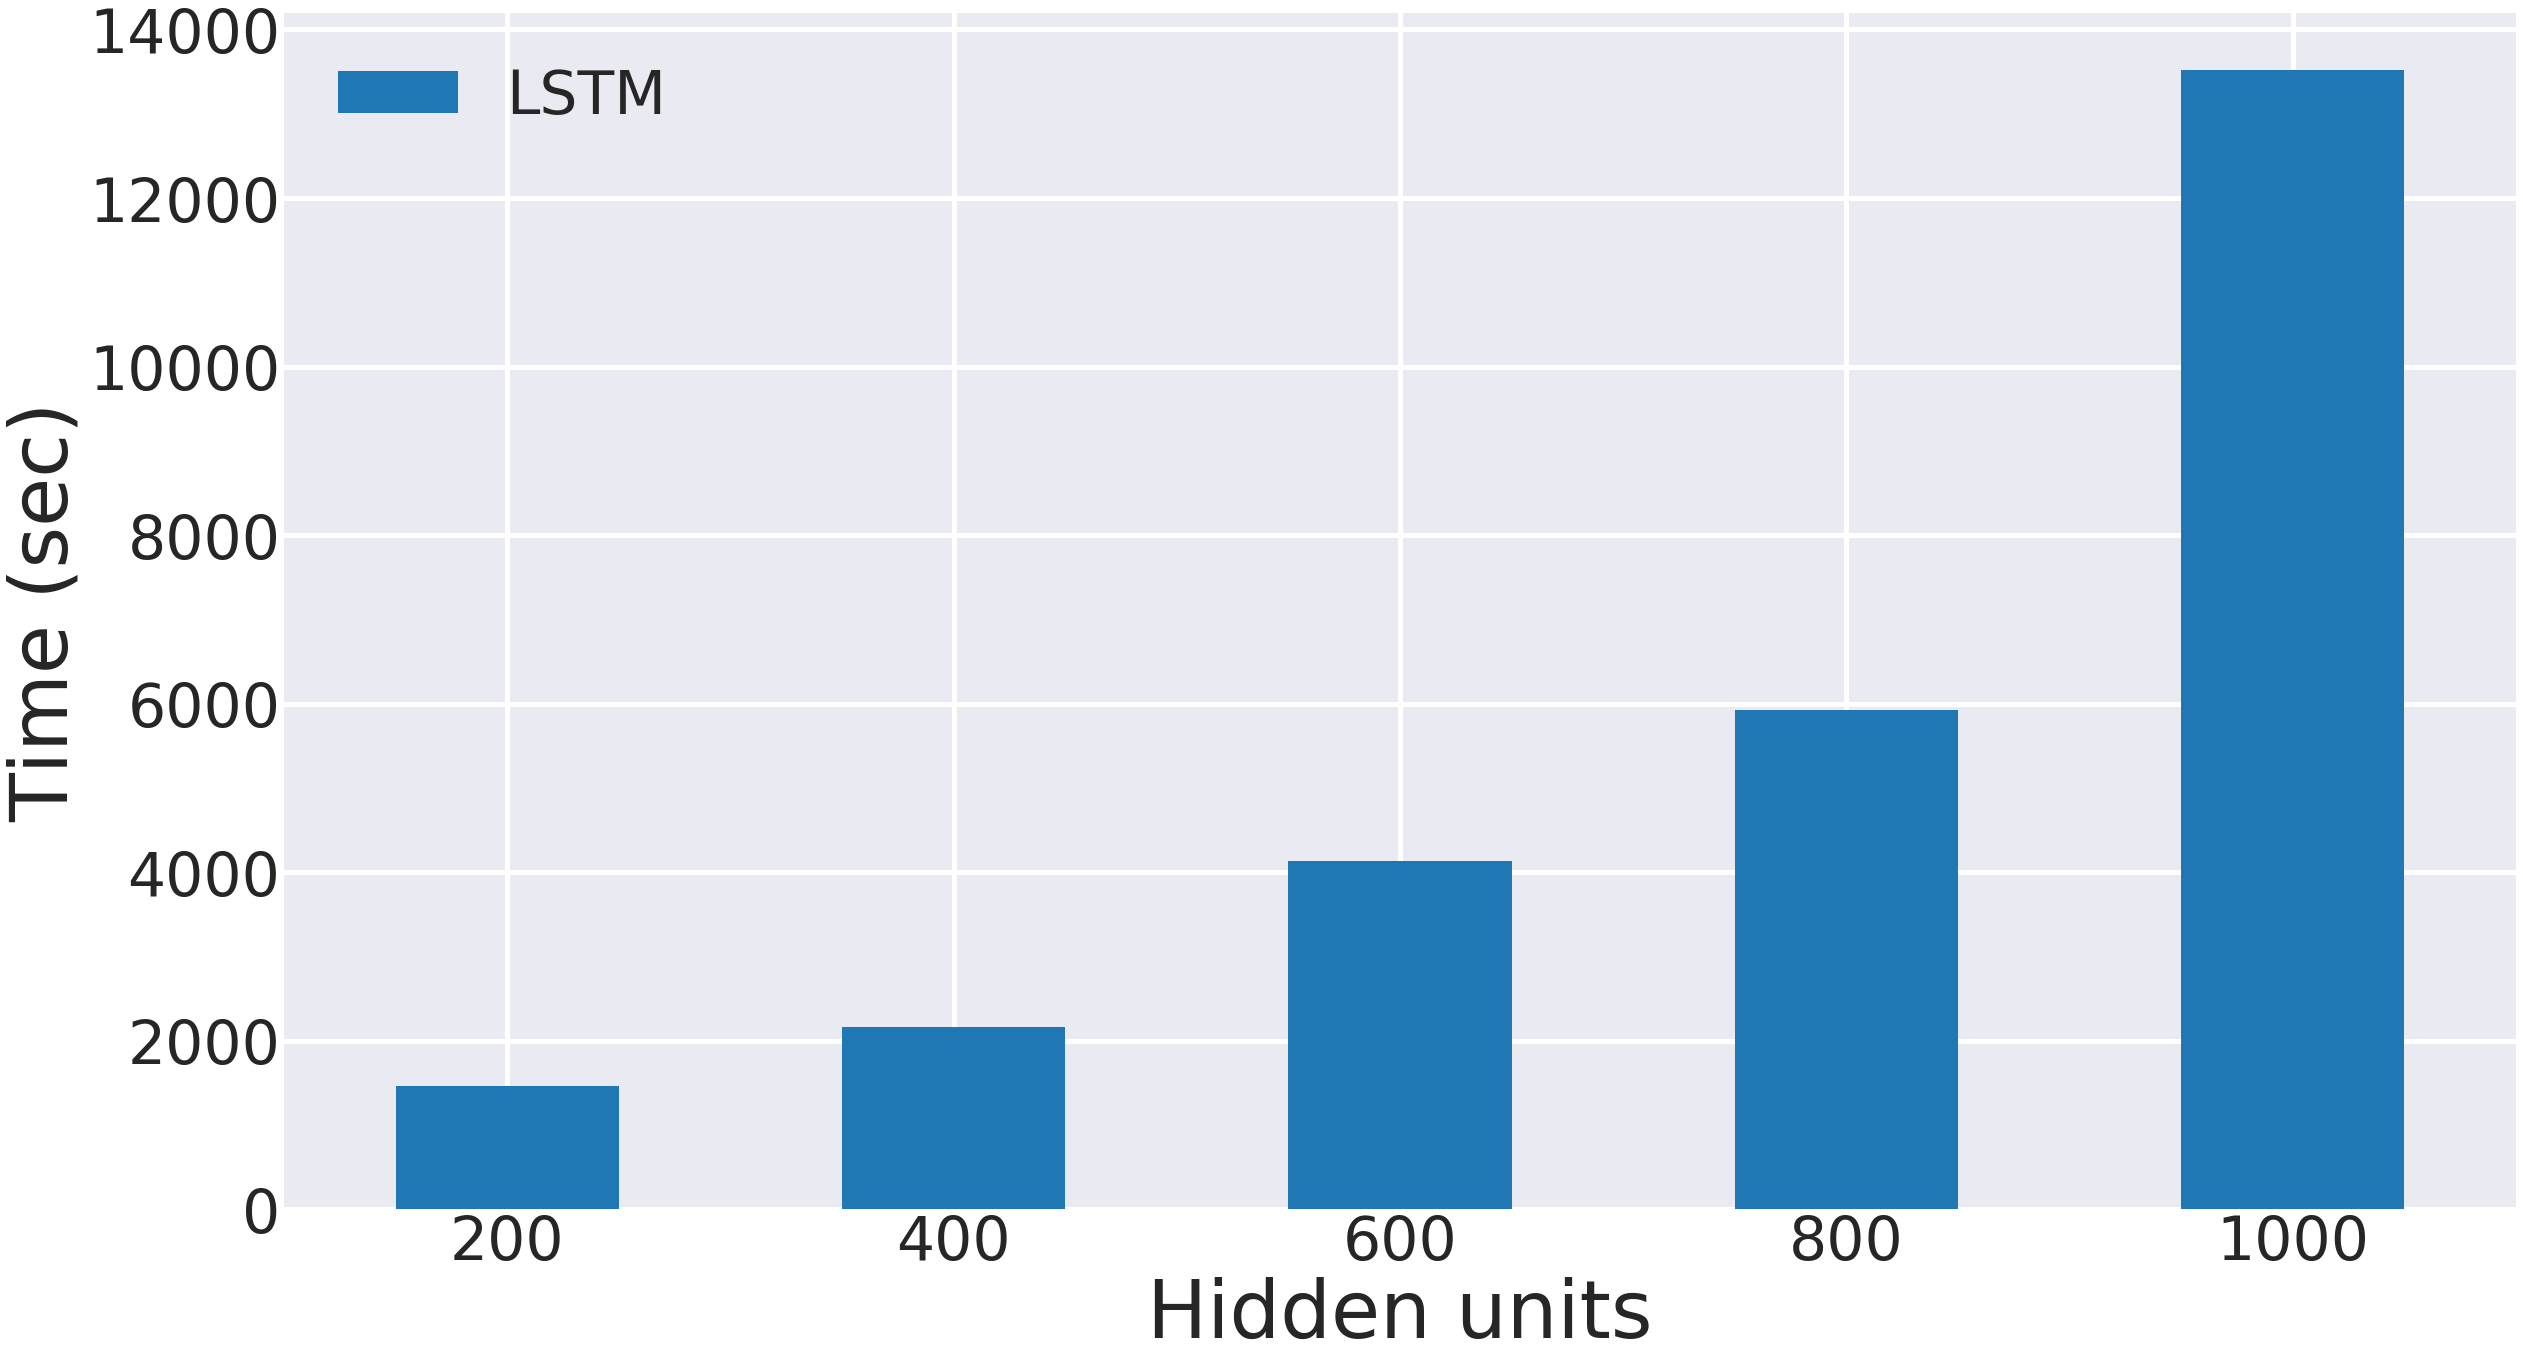

In [36]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_20min_plot = training_time_20min_df.set_index('index').plot.bar(figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0)
 
training_time_20min_plot.set_xlabel("Hidden units", {'size':xlabel_size})
training_time_20min_plot.set_ylabel("Time (sec)", {'size':ylabel_size})
training_time_20min_plot.grid(linewidth=5)

### 30 Minute Partitions

In [37]:
%%spark -o loss_30min_df

loss_30min_df = spark.createDataFrame(
    sc.parallelize(np.array(losses[22:27]).transpose().tolist()), 
    np.array(labels[22:27]).tolist()
)

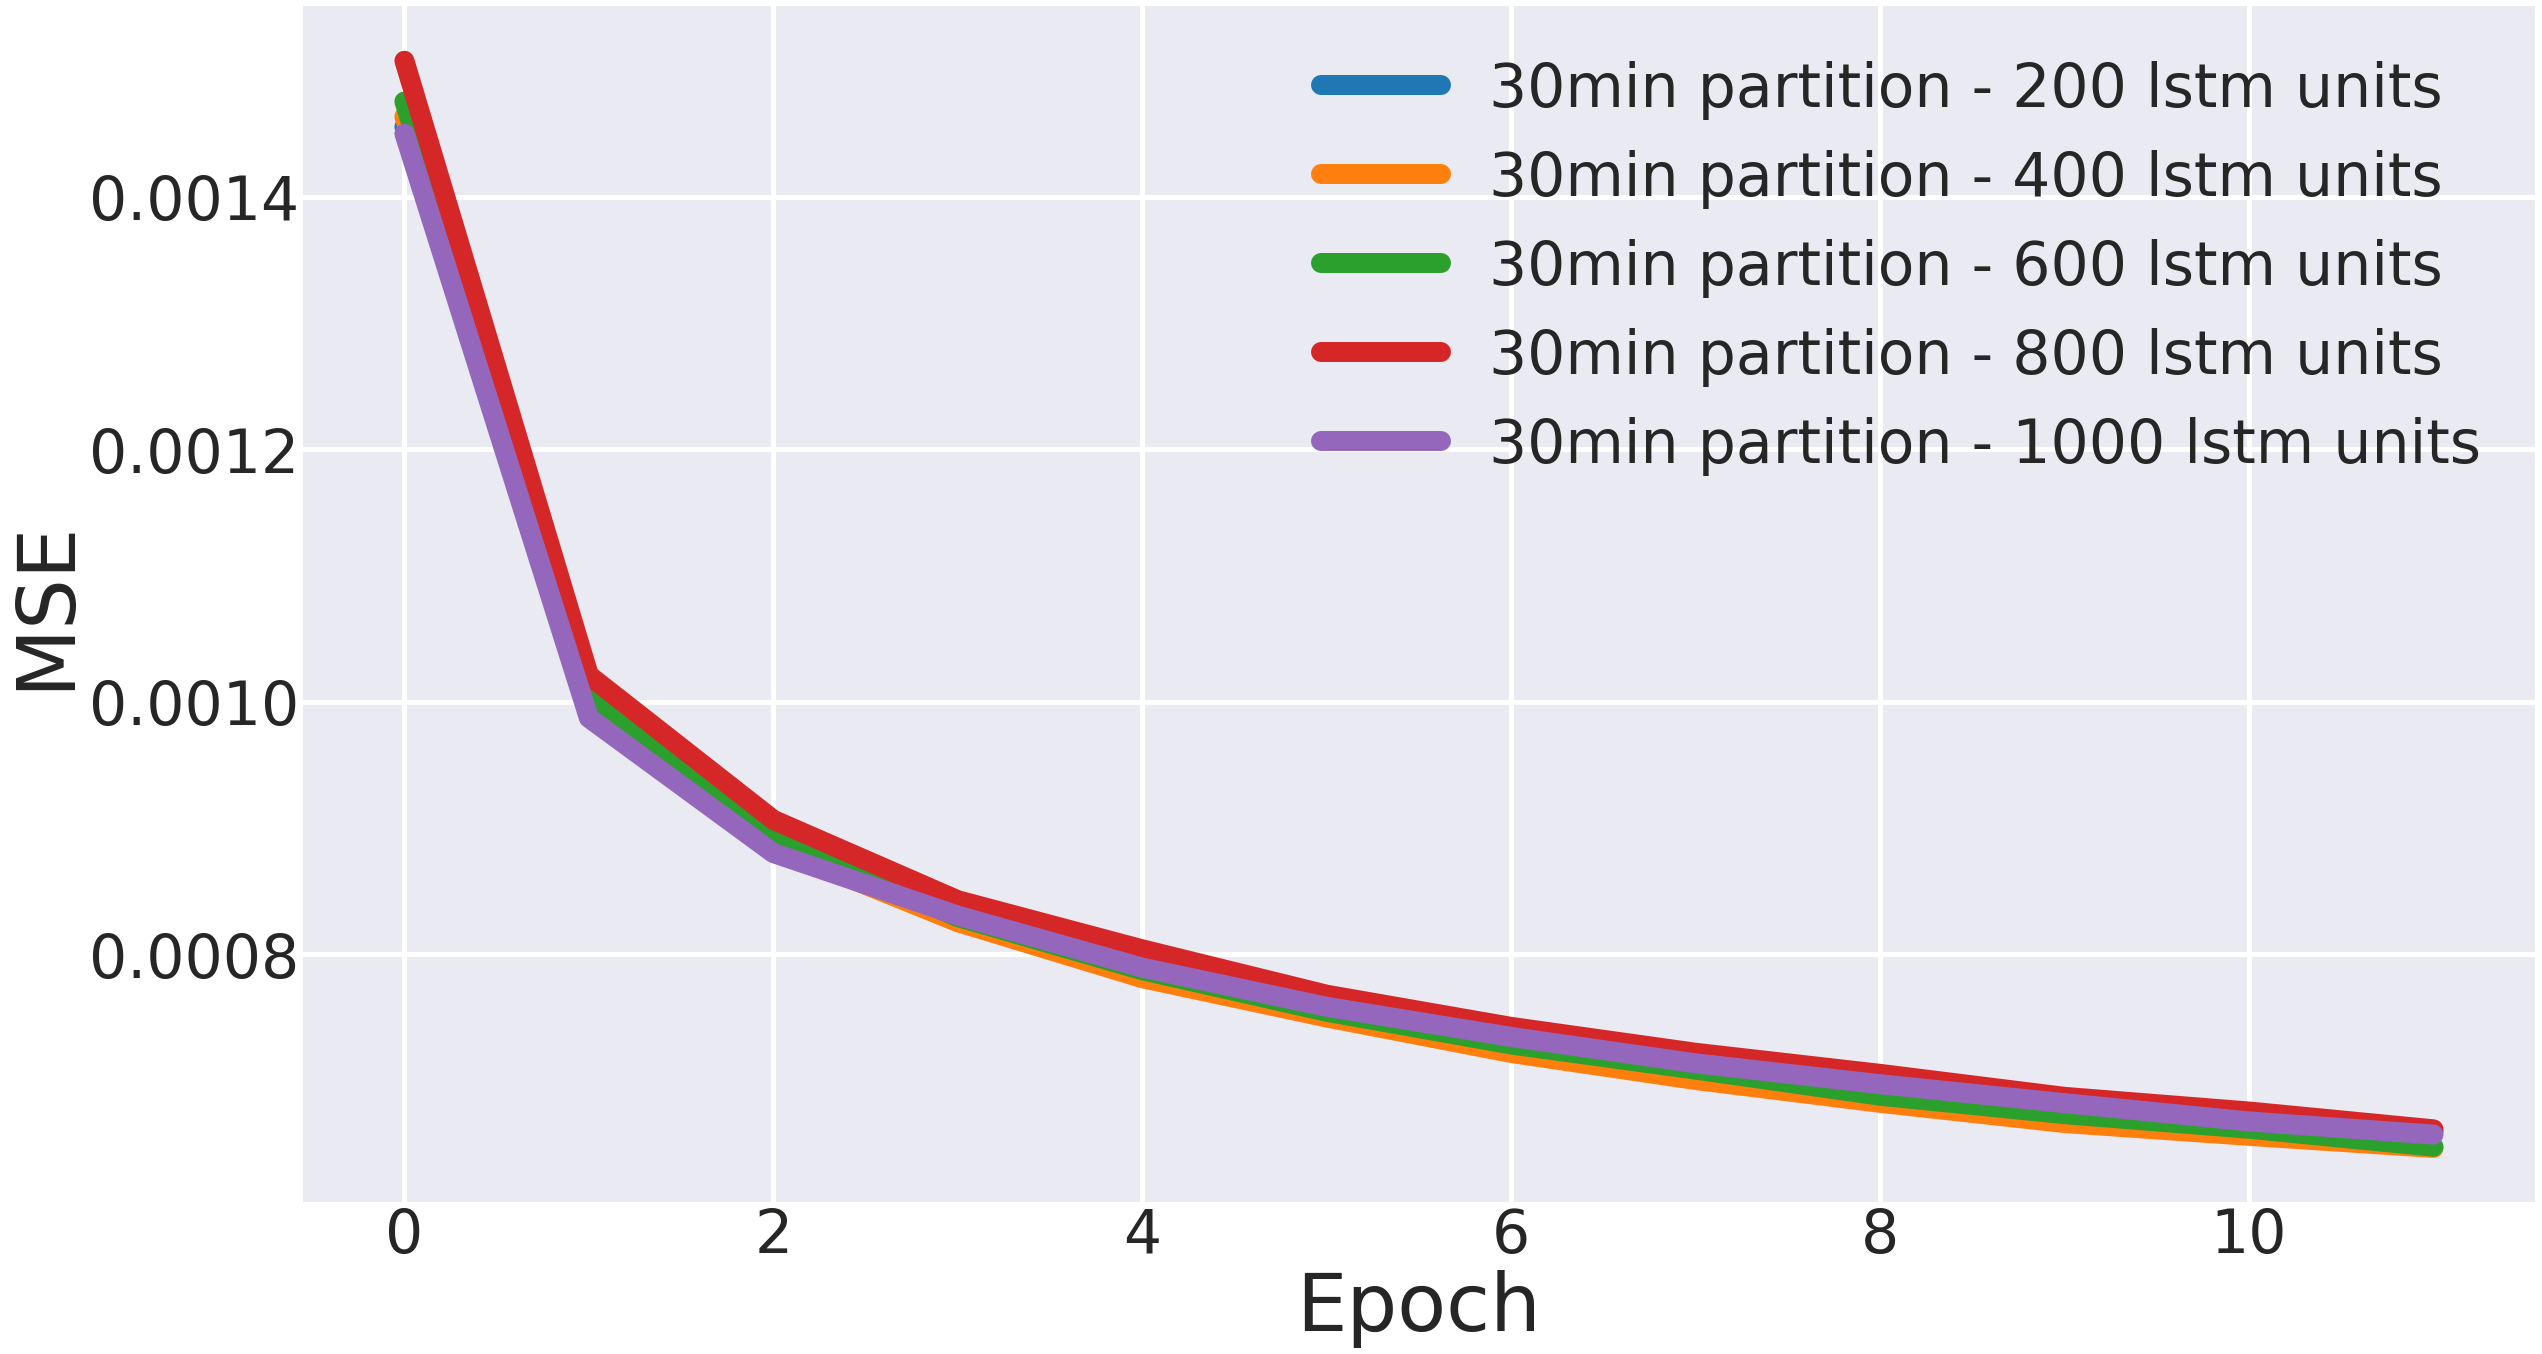

In [38]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
loss_30min_plot = loss_30min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_30min_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_30min_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_30min_plot.grid(linewidth=5)

In [39]:
%%spark -o val_loss_30min_df

val_loss_30min_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses[22:27]).transpose().tolist()), 
    np.array(labels[22:27]).tolist()
)

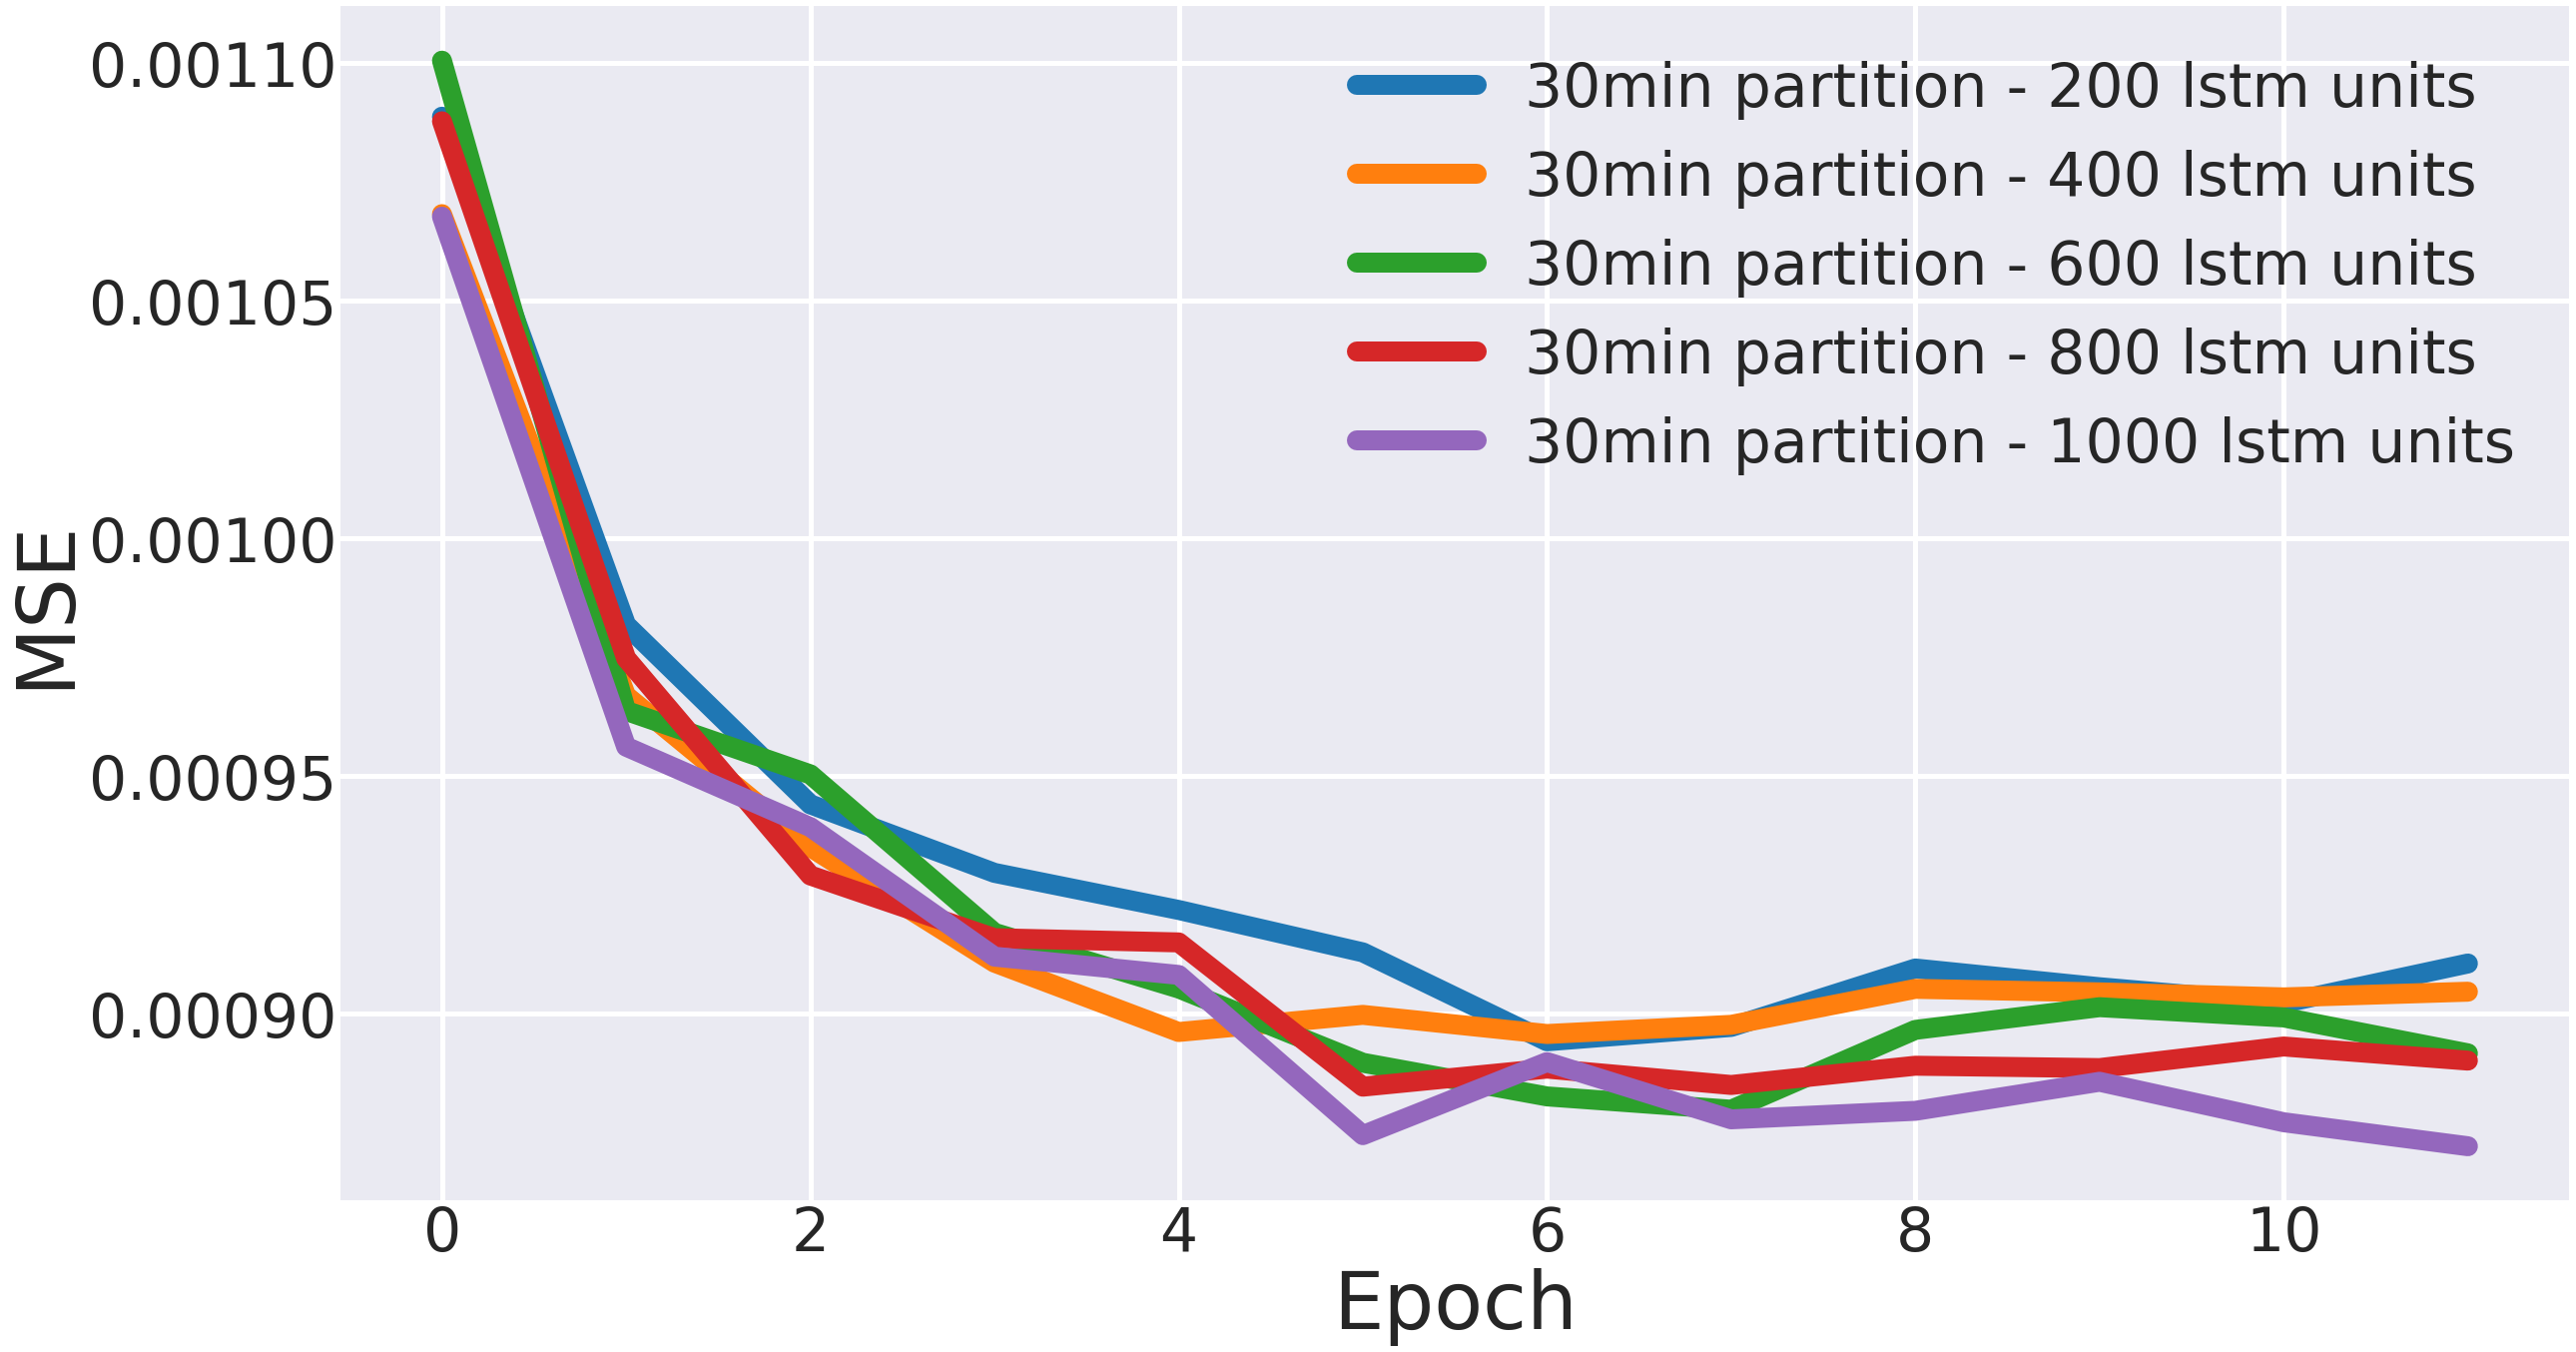

In [40]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
val_loss_30min_plot = val_loss_30min_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
val_loss_30min_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_30min_plot.set_ylabel("MSE", {'size':ylabel_size})
val_loss_30min_plot.grid(linewidth=5)

In [41]:
%%spark -o training_time_30min_df

training_time_30min_df = spark.createDataFrame(
    sc.parallelize(zip(
        partition_tuning[4][2], 
        np.array(training_times)[22:27].tolist()
    )),
    ("index", "LSTM")
)

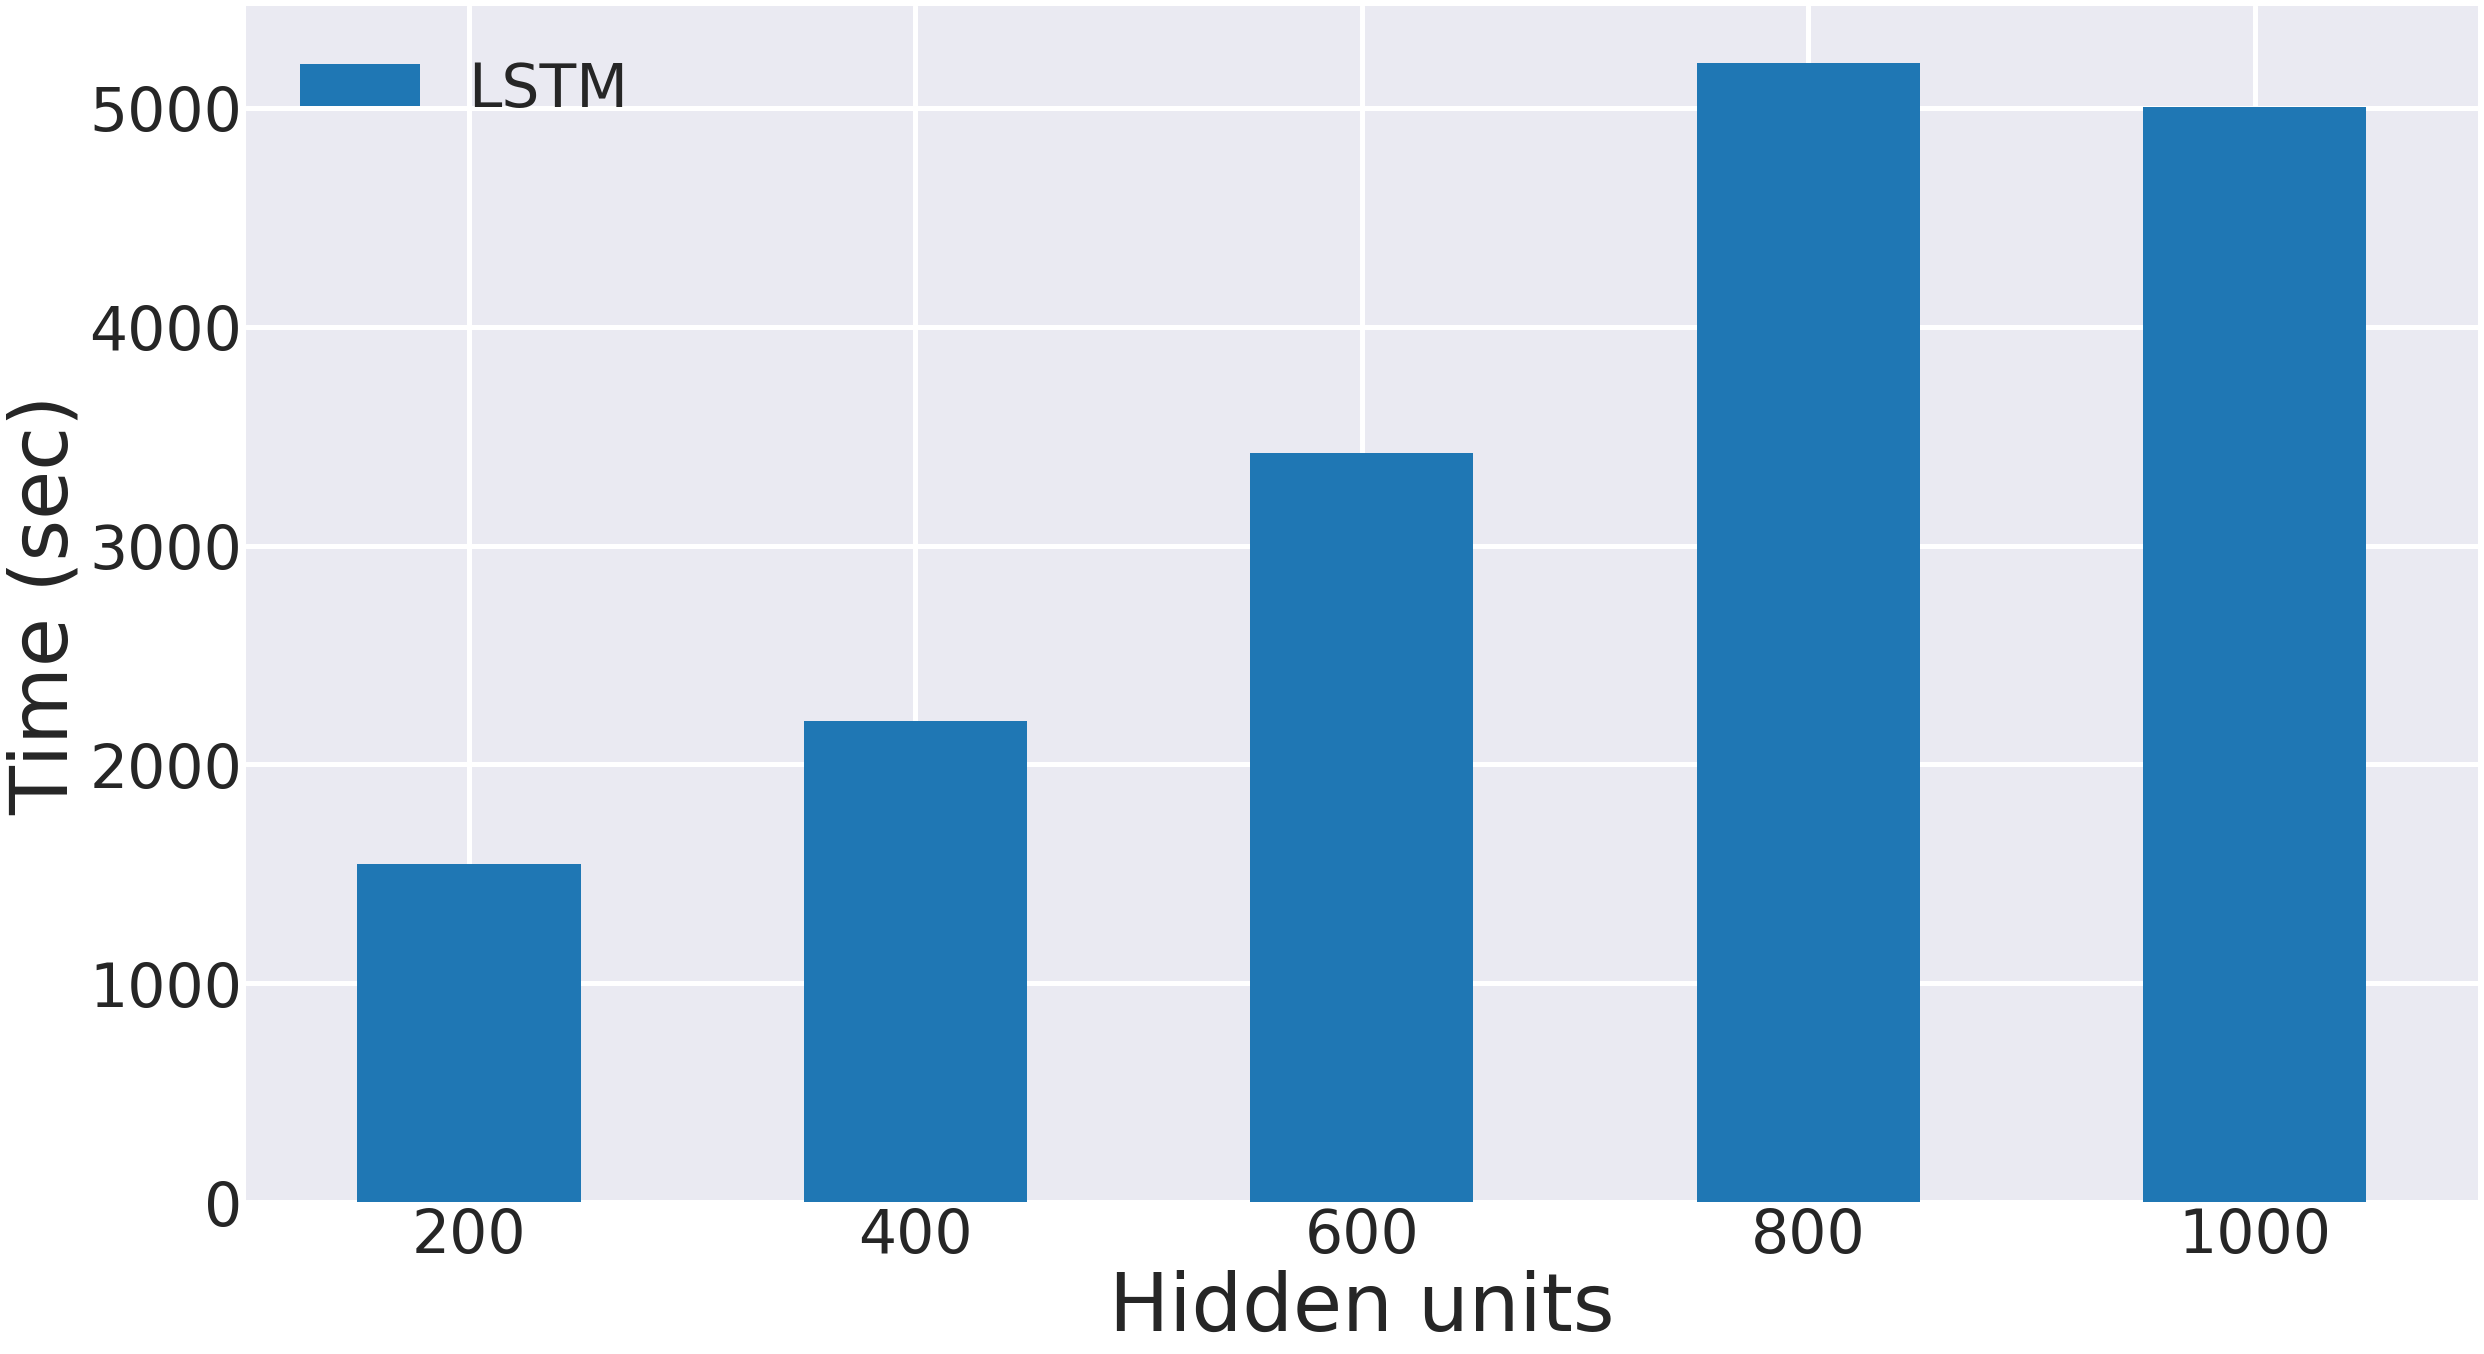

In [42]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_30min_plot = training_time_30min_df.set_index('index').plot.bar(figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0)
 
training_time_30min_plot.set_xlabel("Hidden units", {'size':xlabel_size})
training_time_30min_plot.set_ylabel("Time (sec)", {'size':ylabel_size})
training_time_30min_plot.grid(linewidth=5)

## Analyze Single Sensor Model Hyperparameter Tuning

In [57]:
single_tuning = [
    ["lstm", [50, 100, 500, 1000]]
]

losses = []
val_losses = []
training_times = []
labels = []

for t in single_tuning:
    for i in t[1]:
        losses.append(read_file(root_path + "single_sensor-" + t[0] + "_units_" + str(i) + "/loss.npy"))
        val_losses.append(read_file(root_path + "single_sensor-" + t[0] + "_units_" + str(i) + "/val_loss.npy"))
        training_times.append(read_file(root_path + "single_sensor-" + t[0] + "_units_" + str(i) + "/training_time.npy"))
        labels.append(str(i) + " " + t[0] + " units")
        
# Add none if lists are not equal in size
max_length = 0
for loss in losses:
    if len(loss) > max_length:
        max_length = len(loss)
for i in range(len(losses)):
    for p in range(max_length - len(losses[i])):
        losses[i] = np.append(losses[i], None)
        val_losses[i] = np.append(val_losses[i], None)

In [58]:
%%spark -o loss_single_df

loss_single_df = spark.createDataFrame(
    sc.parallelize(np.array(losses).transpose().tolist()), 
    np.array(labels).tolist()
)

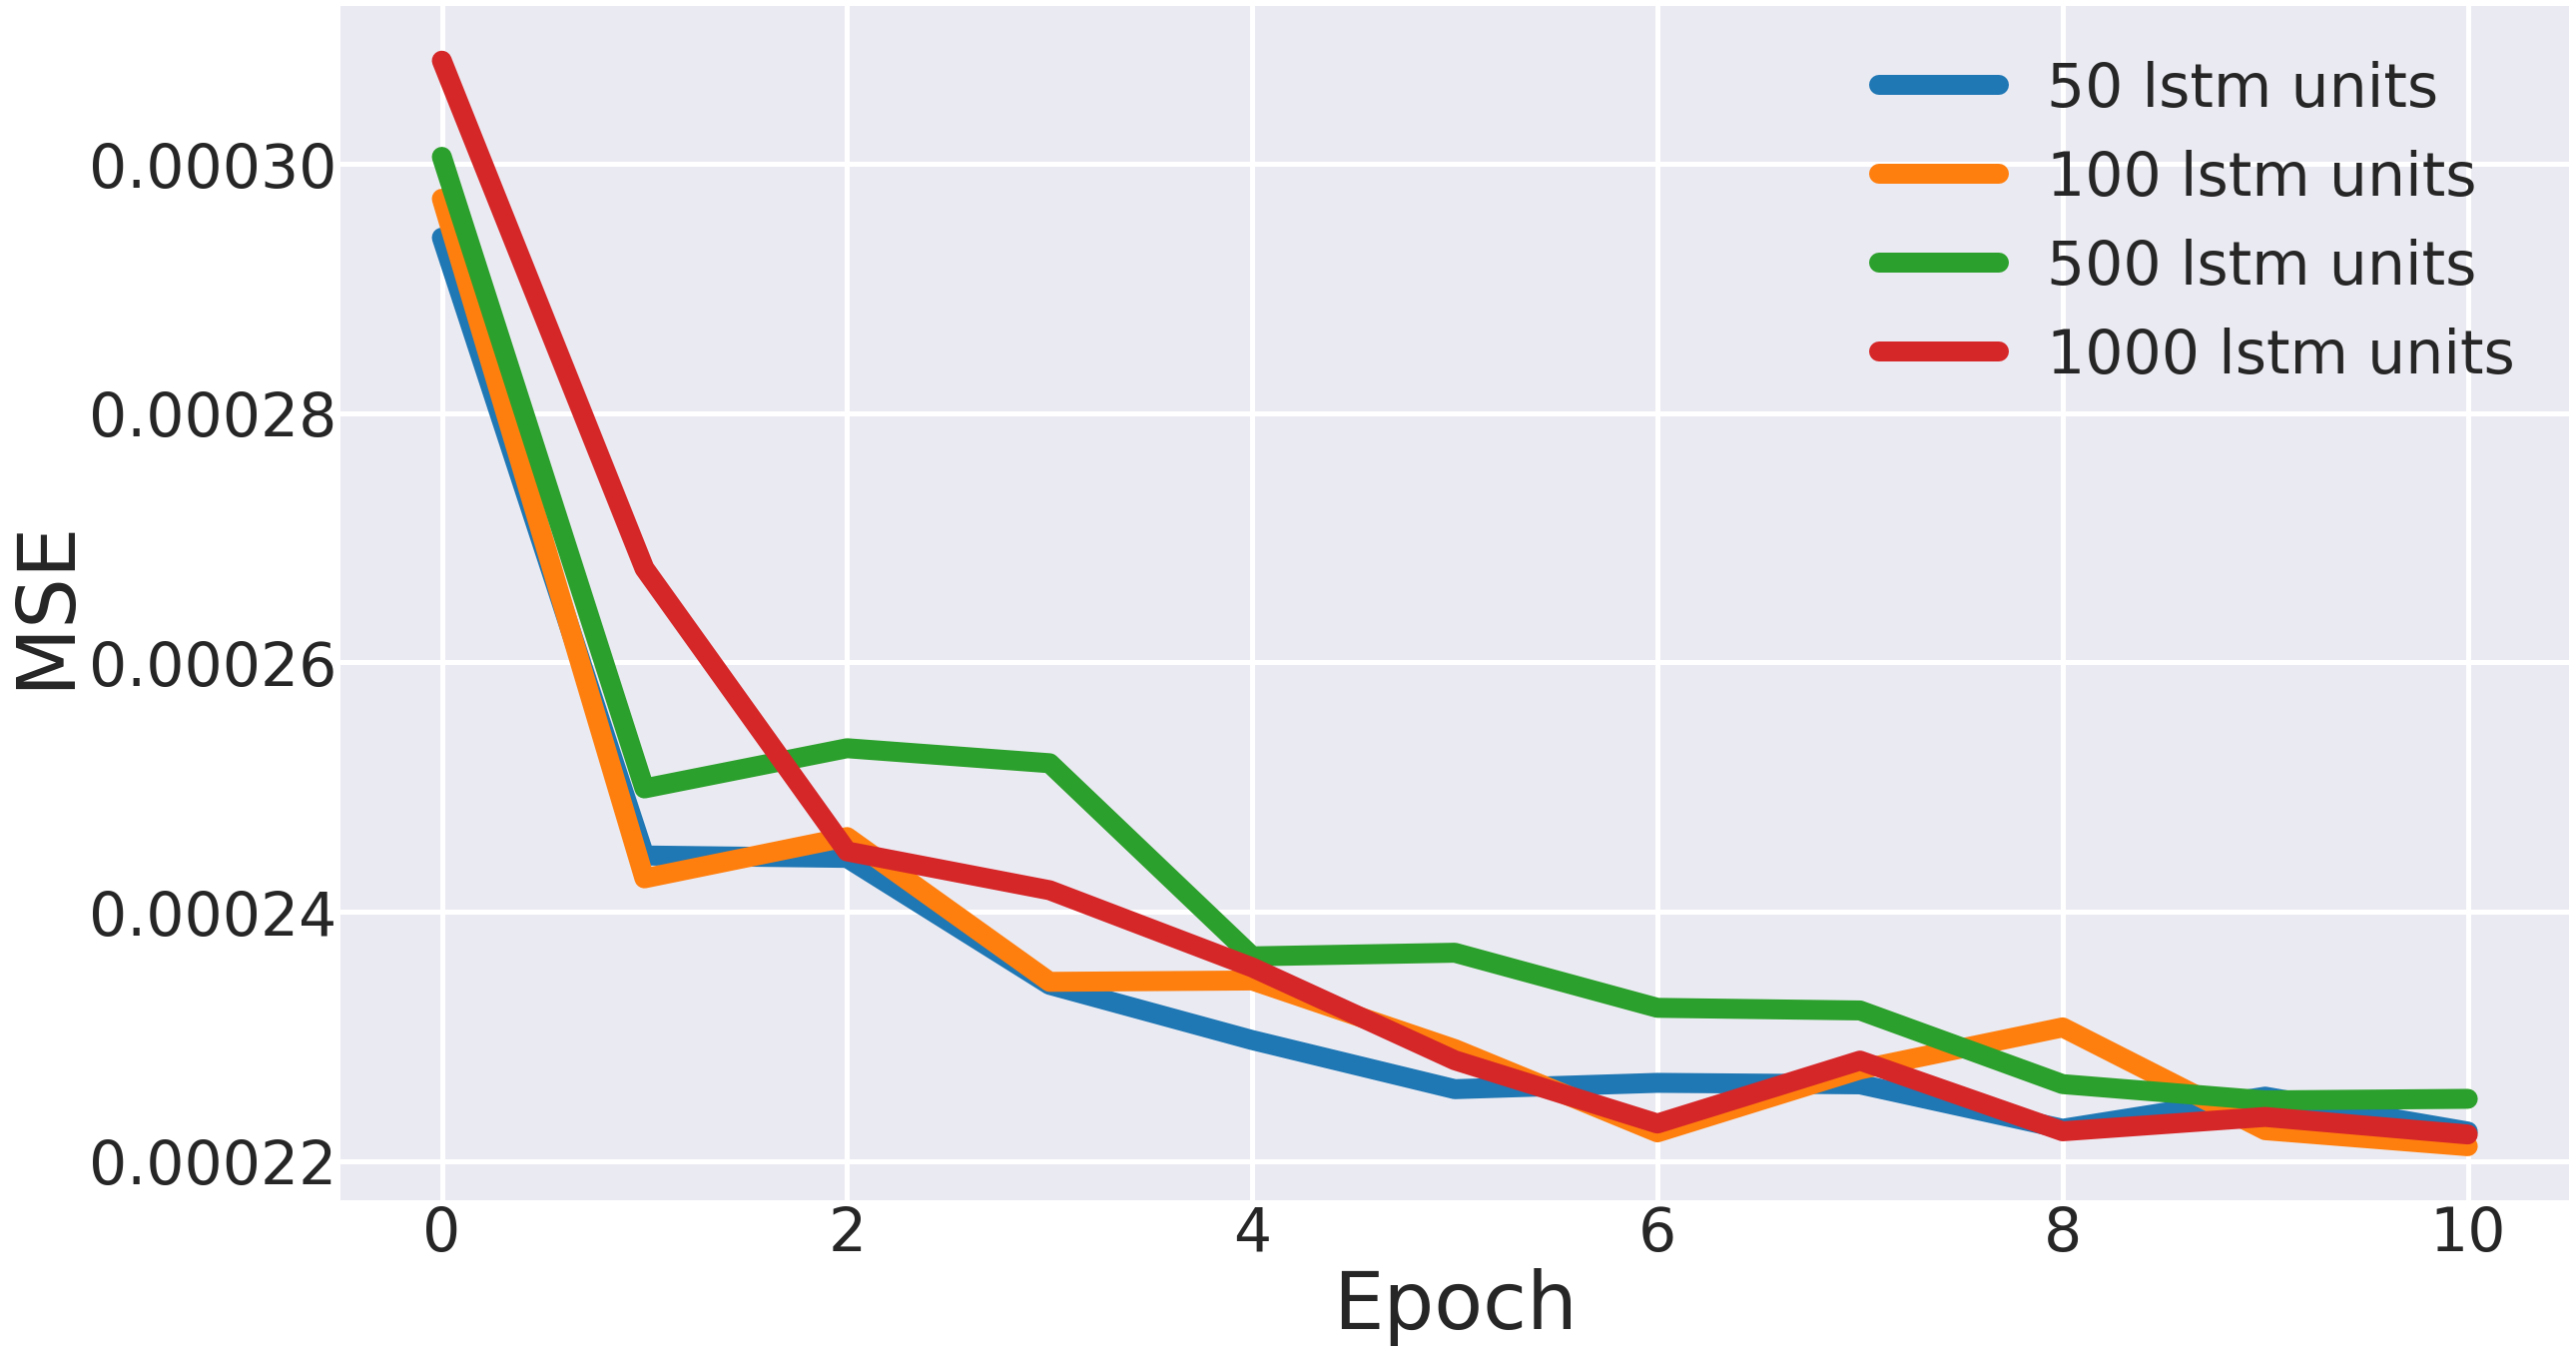

In [59]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
loss_single_plot = loss_single_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_single_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_single_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_single_plot.grid(linewidth=5)

In [60]:
%%spark -o val_loss_single_df

val_loss_single_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses).transpose().tolist()), 
    np.array(labels).tolist()
)

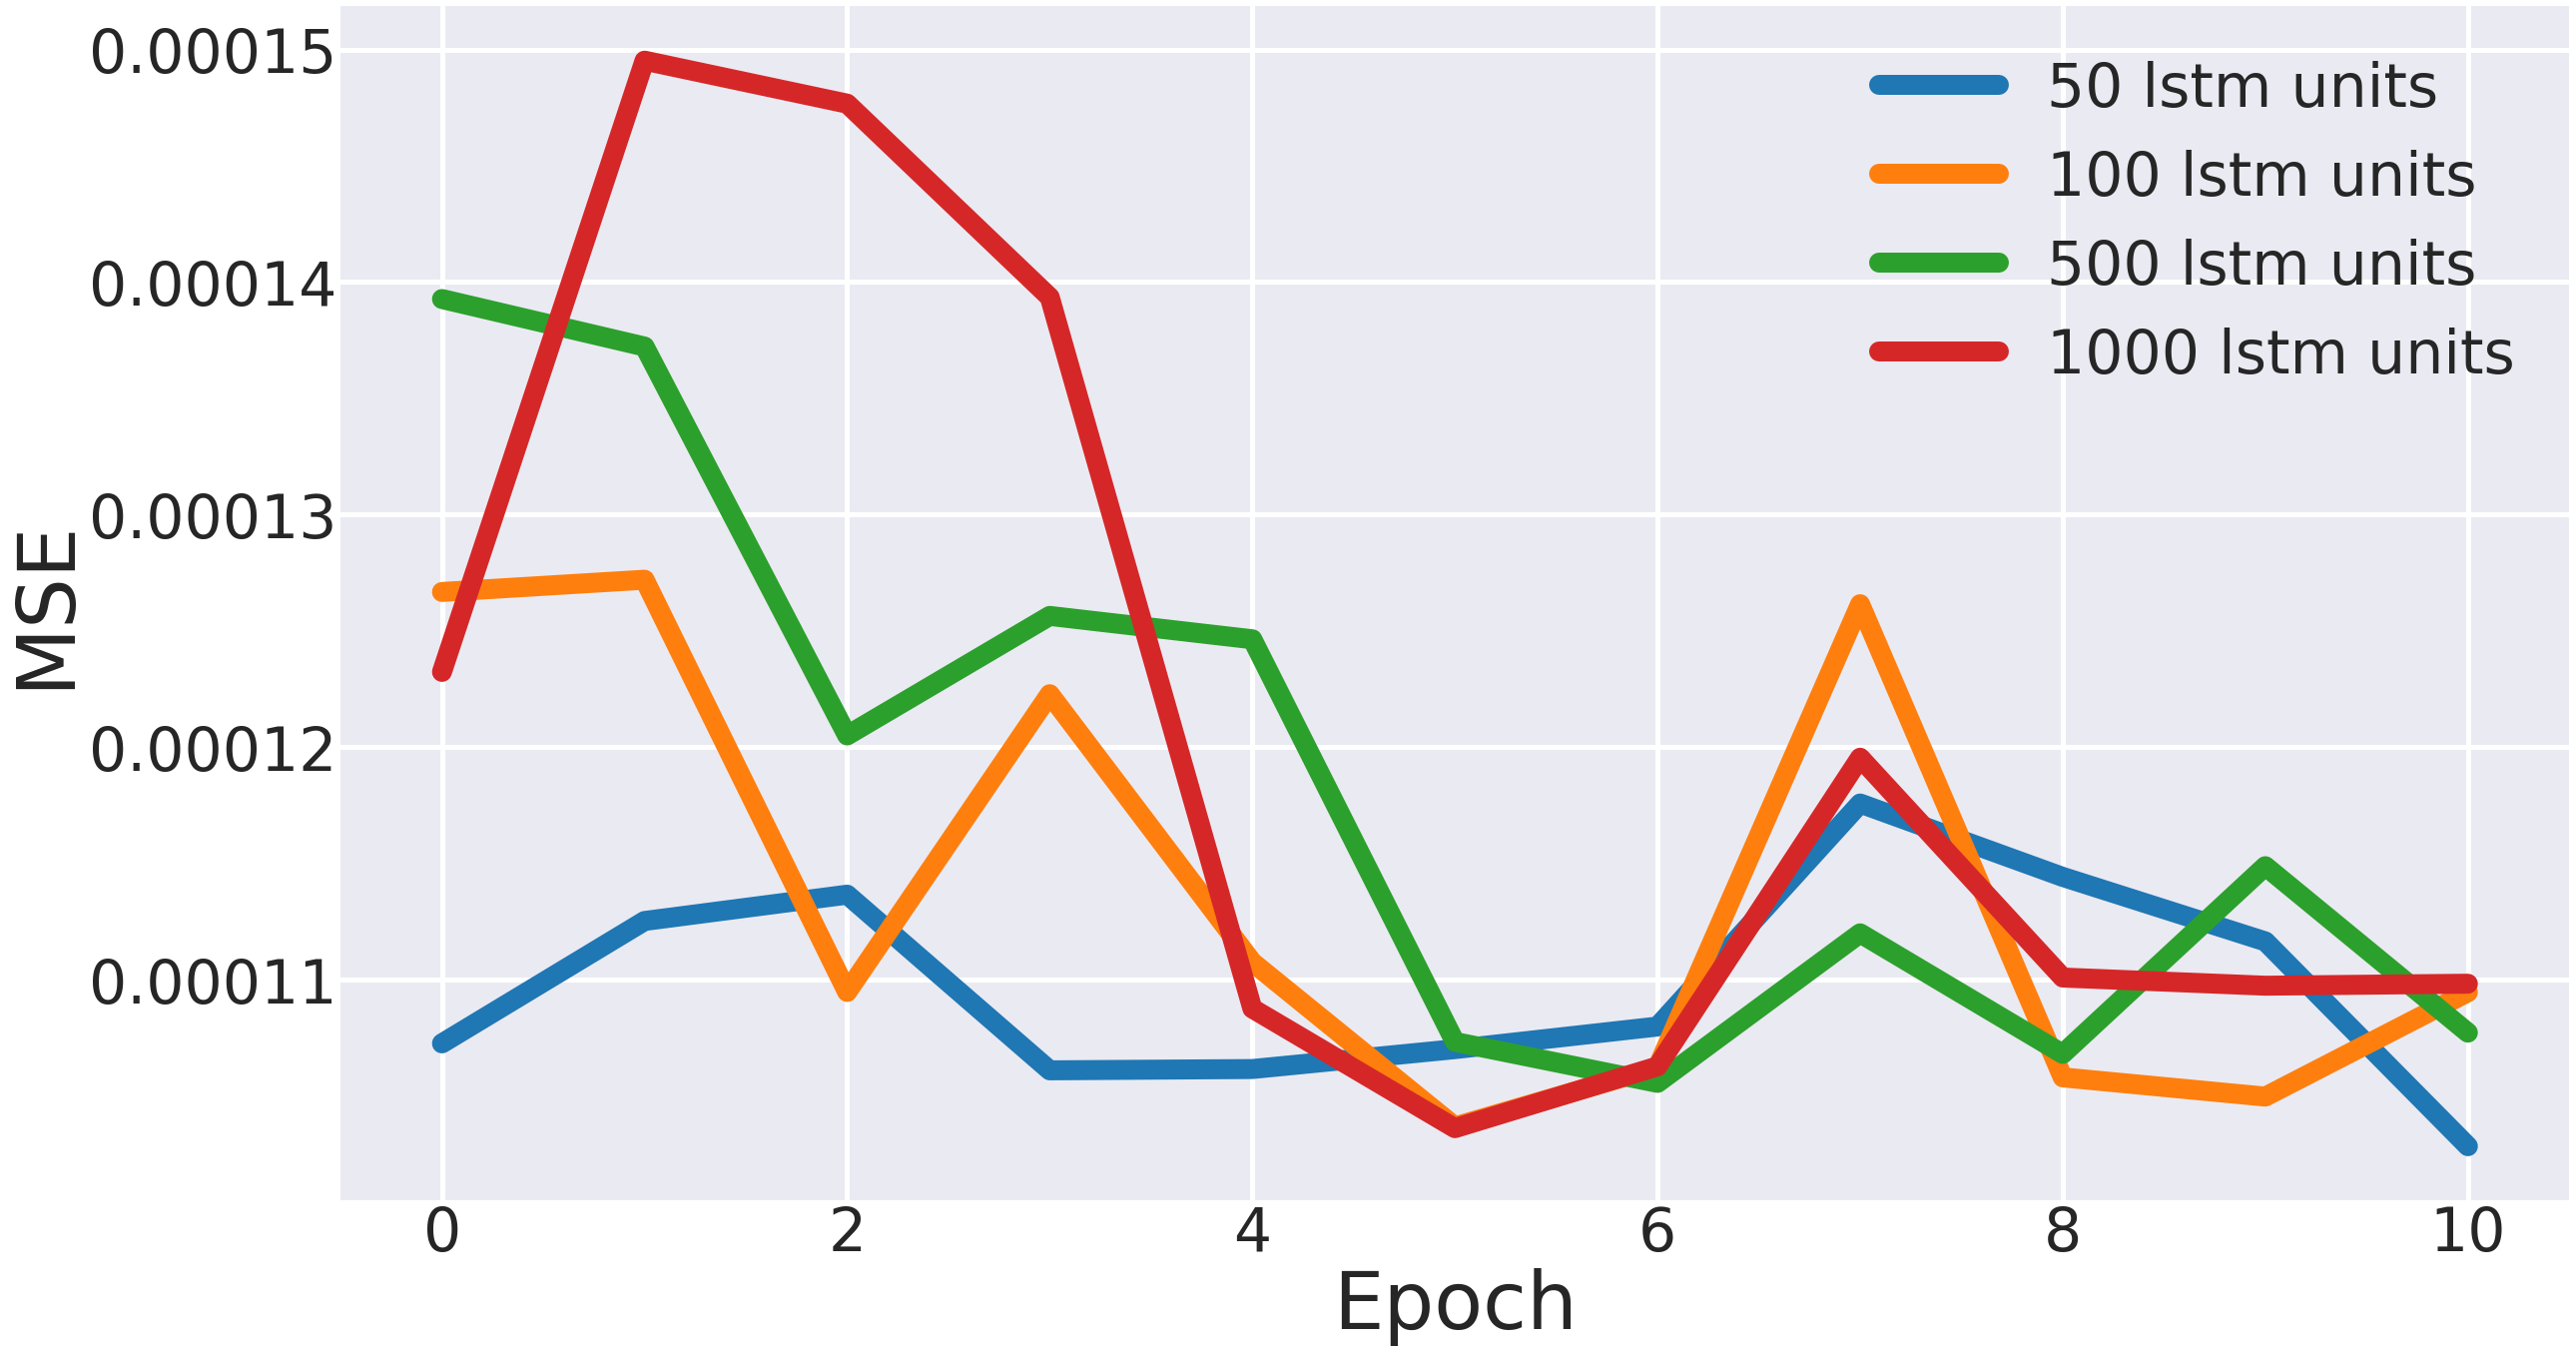

In [61]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
val_loss_single_plot = val_loss_single_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
val_loss_single_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_single_plot.set_ylabel("MSE", {'size':ylabel_size})
val_loss_single_plot.grid(linewidth=5)

In [62]:
%%spark -o training_time_single_df

training_time_single_df = spark.createDataFrame(
    sc.parallelize(zip(
        labels, 
        np.array(training_times).tolist()
    )),
    ("index", "LSTM")
)

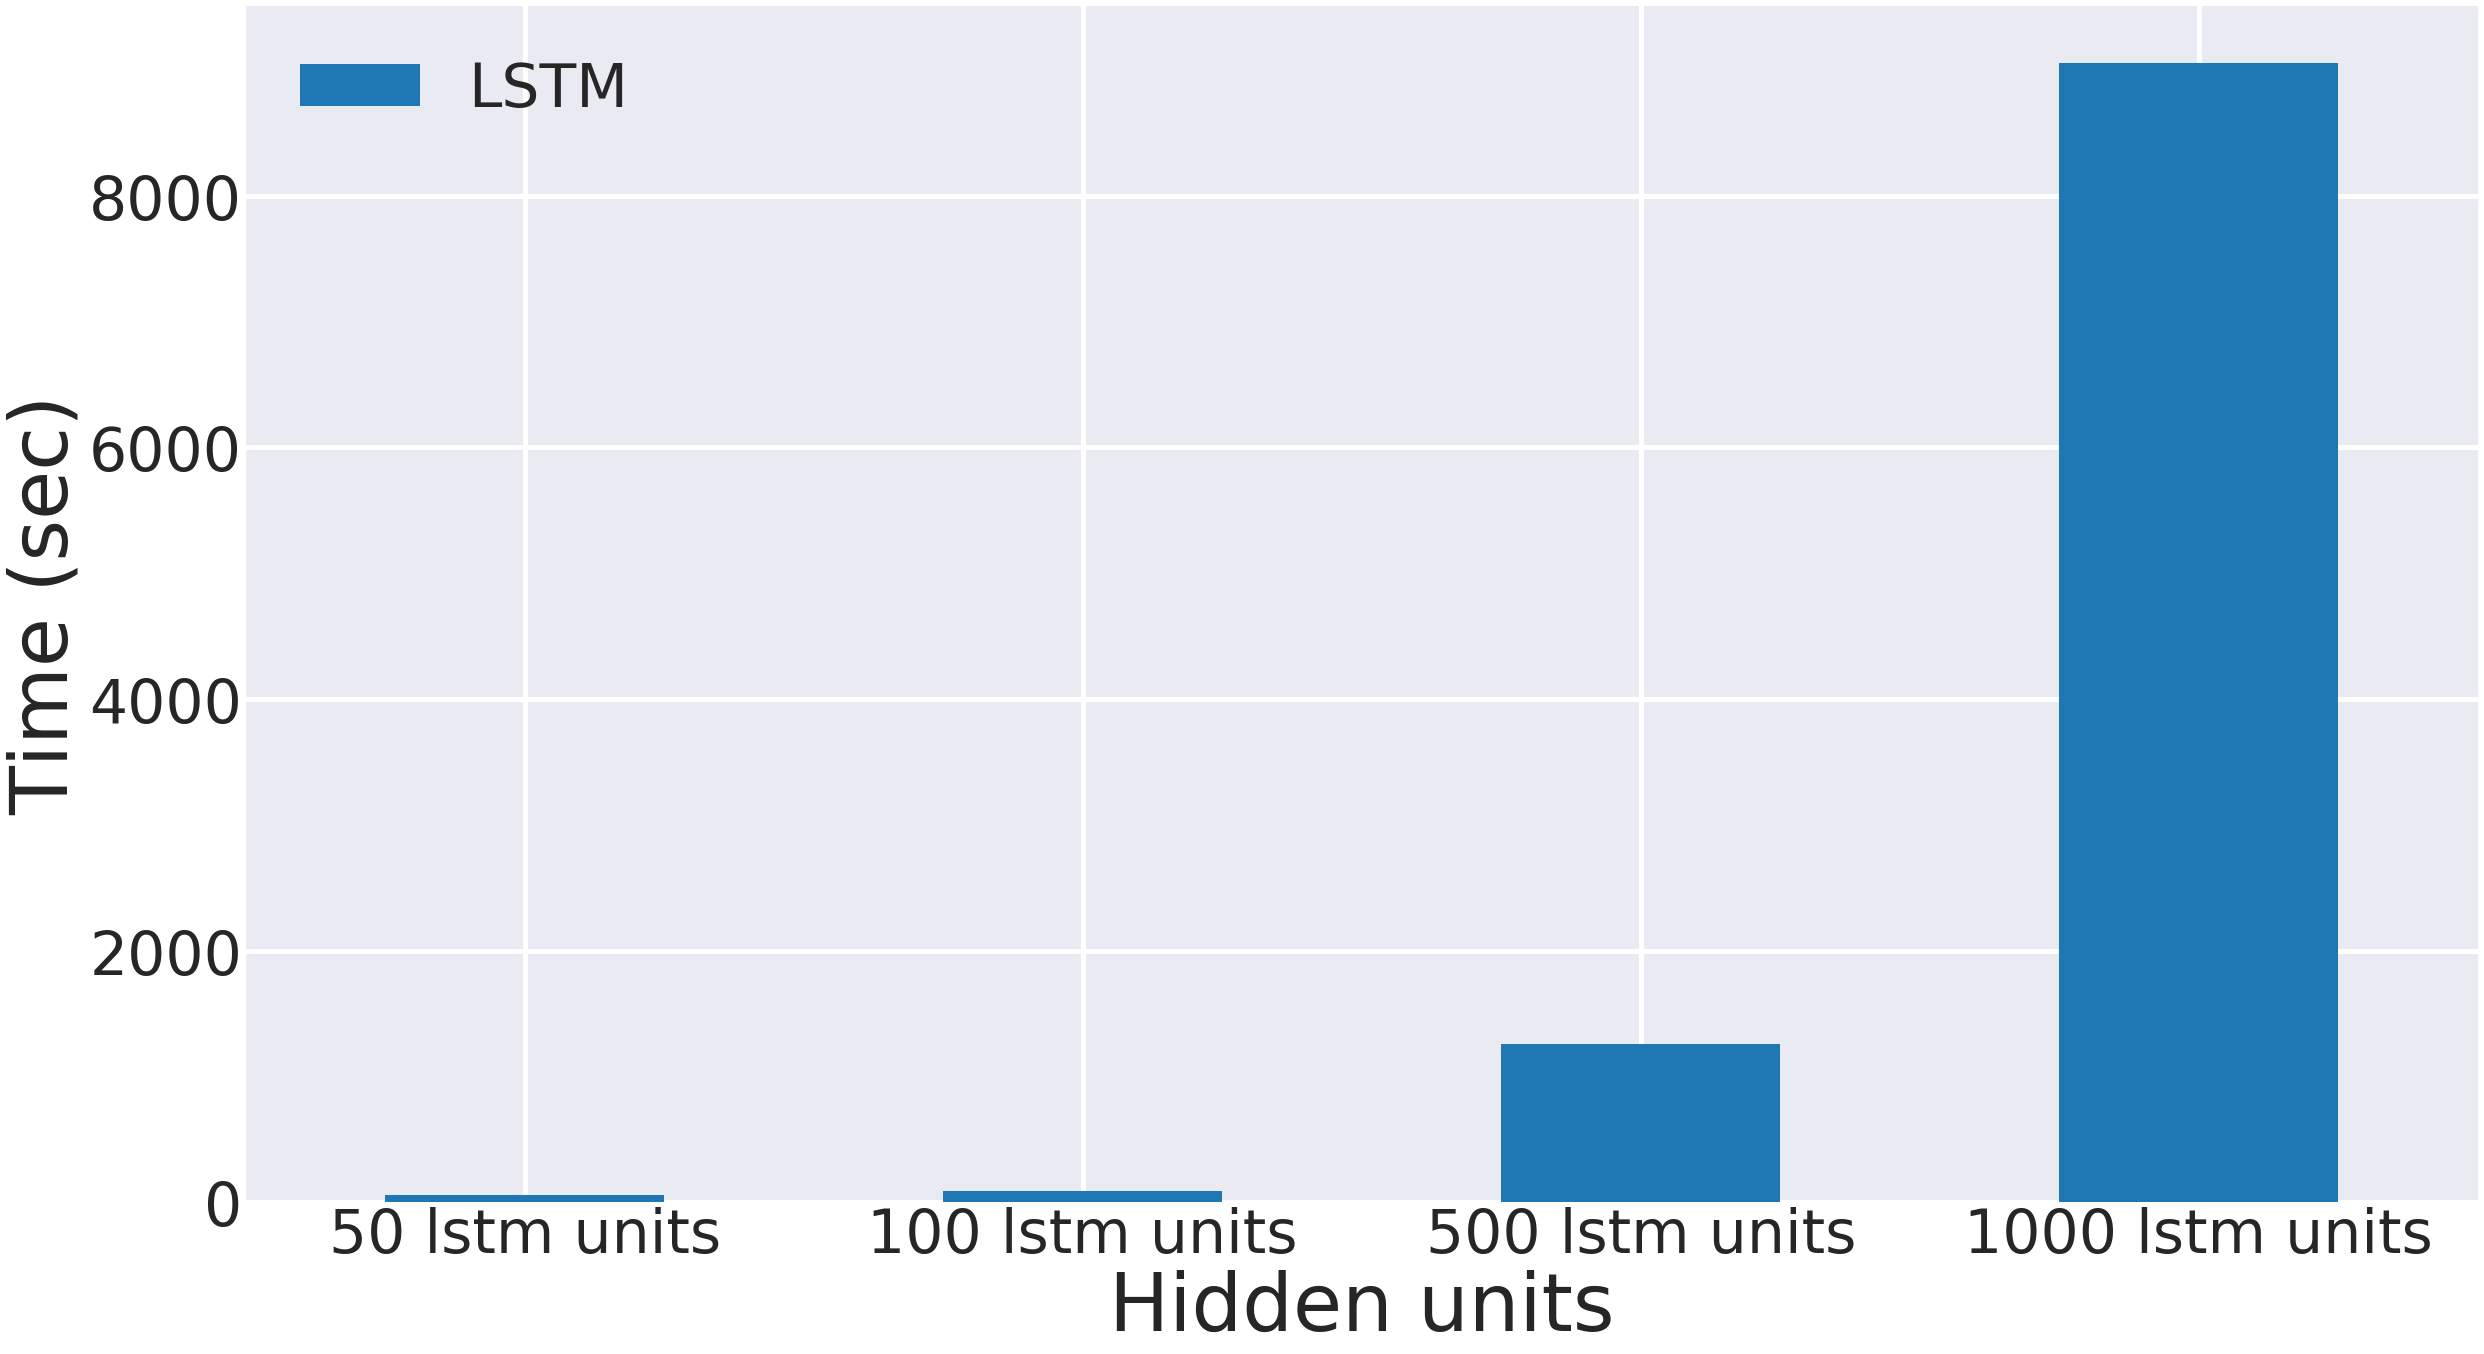

In [63]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_single_plot = training_time_single_df.set_index('index').plot.bar(
    figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0
)
 
training_time_single_plot.set_xlabel("Hidden units", {'size': xlabel_size})
training_time_single_plot.set_ylabel("Time (sec)", {'size': ylabel_size})
training_time_single_plot.grid(linewidth=5)

## GRU units

In [50]:
single_tuning = [
    ["gru", [50, 100, 500, 1000]]
]

losses = []
val_losses = []
training_times = []
labels = []
for t in single_tuning:
    for i in t[1]:
        losses.append(read_file(root_path + "single_sensor-" + t[0] + "_units_" + str(i) + "/loss.npy"))
        val_losses.append(read_file(root_path + "single_sensor-" + t[0] + "_units_" + str(i) + "/val_loss.npy"))
        training_times.append(read_file(root_path + "single_sensor-" + t[0] + "_units_" + str(i) + "/training_time.npy"))
        labels.append(str(i) + " " + t[0] + " units")
        
# Add none if lists are not equal in size
max_length = 0
for loss in losses:
    if len(loss) > max_length:
        max_length = len(loss)
for i in range(len(losses)):
    for p in range(max_length - len(losses[i])):
        losses[i] = np.append(losses[i], None)
        val_losses[i] = np.append(val_losses[i], None)

In [51]:
%%spark -o loss_single_df

loss_single_df = spark.createDataFrame(
    sc.parallelize(np.array(losses).transpose().tolist()), 
    np.array(labels).tolist()
)

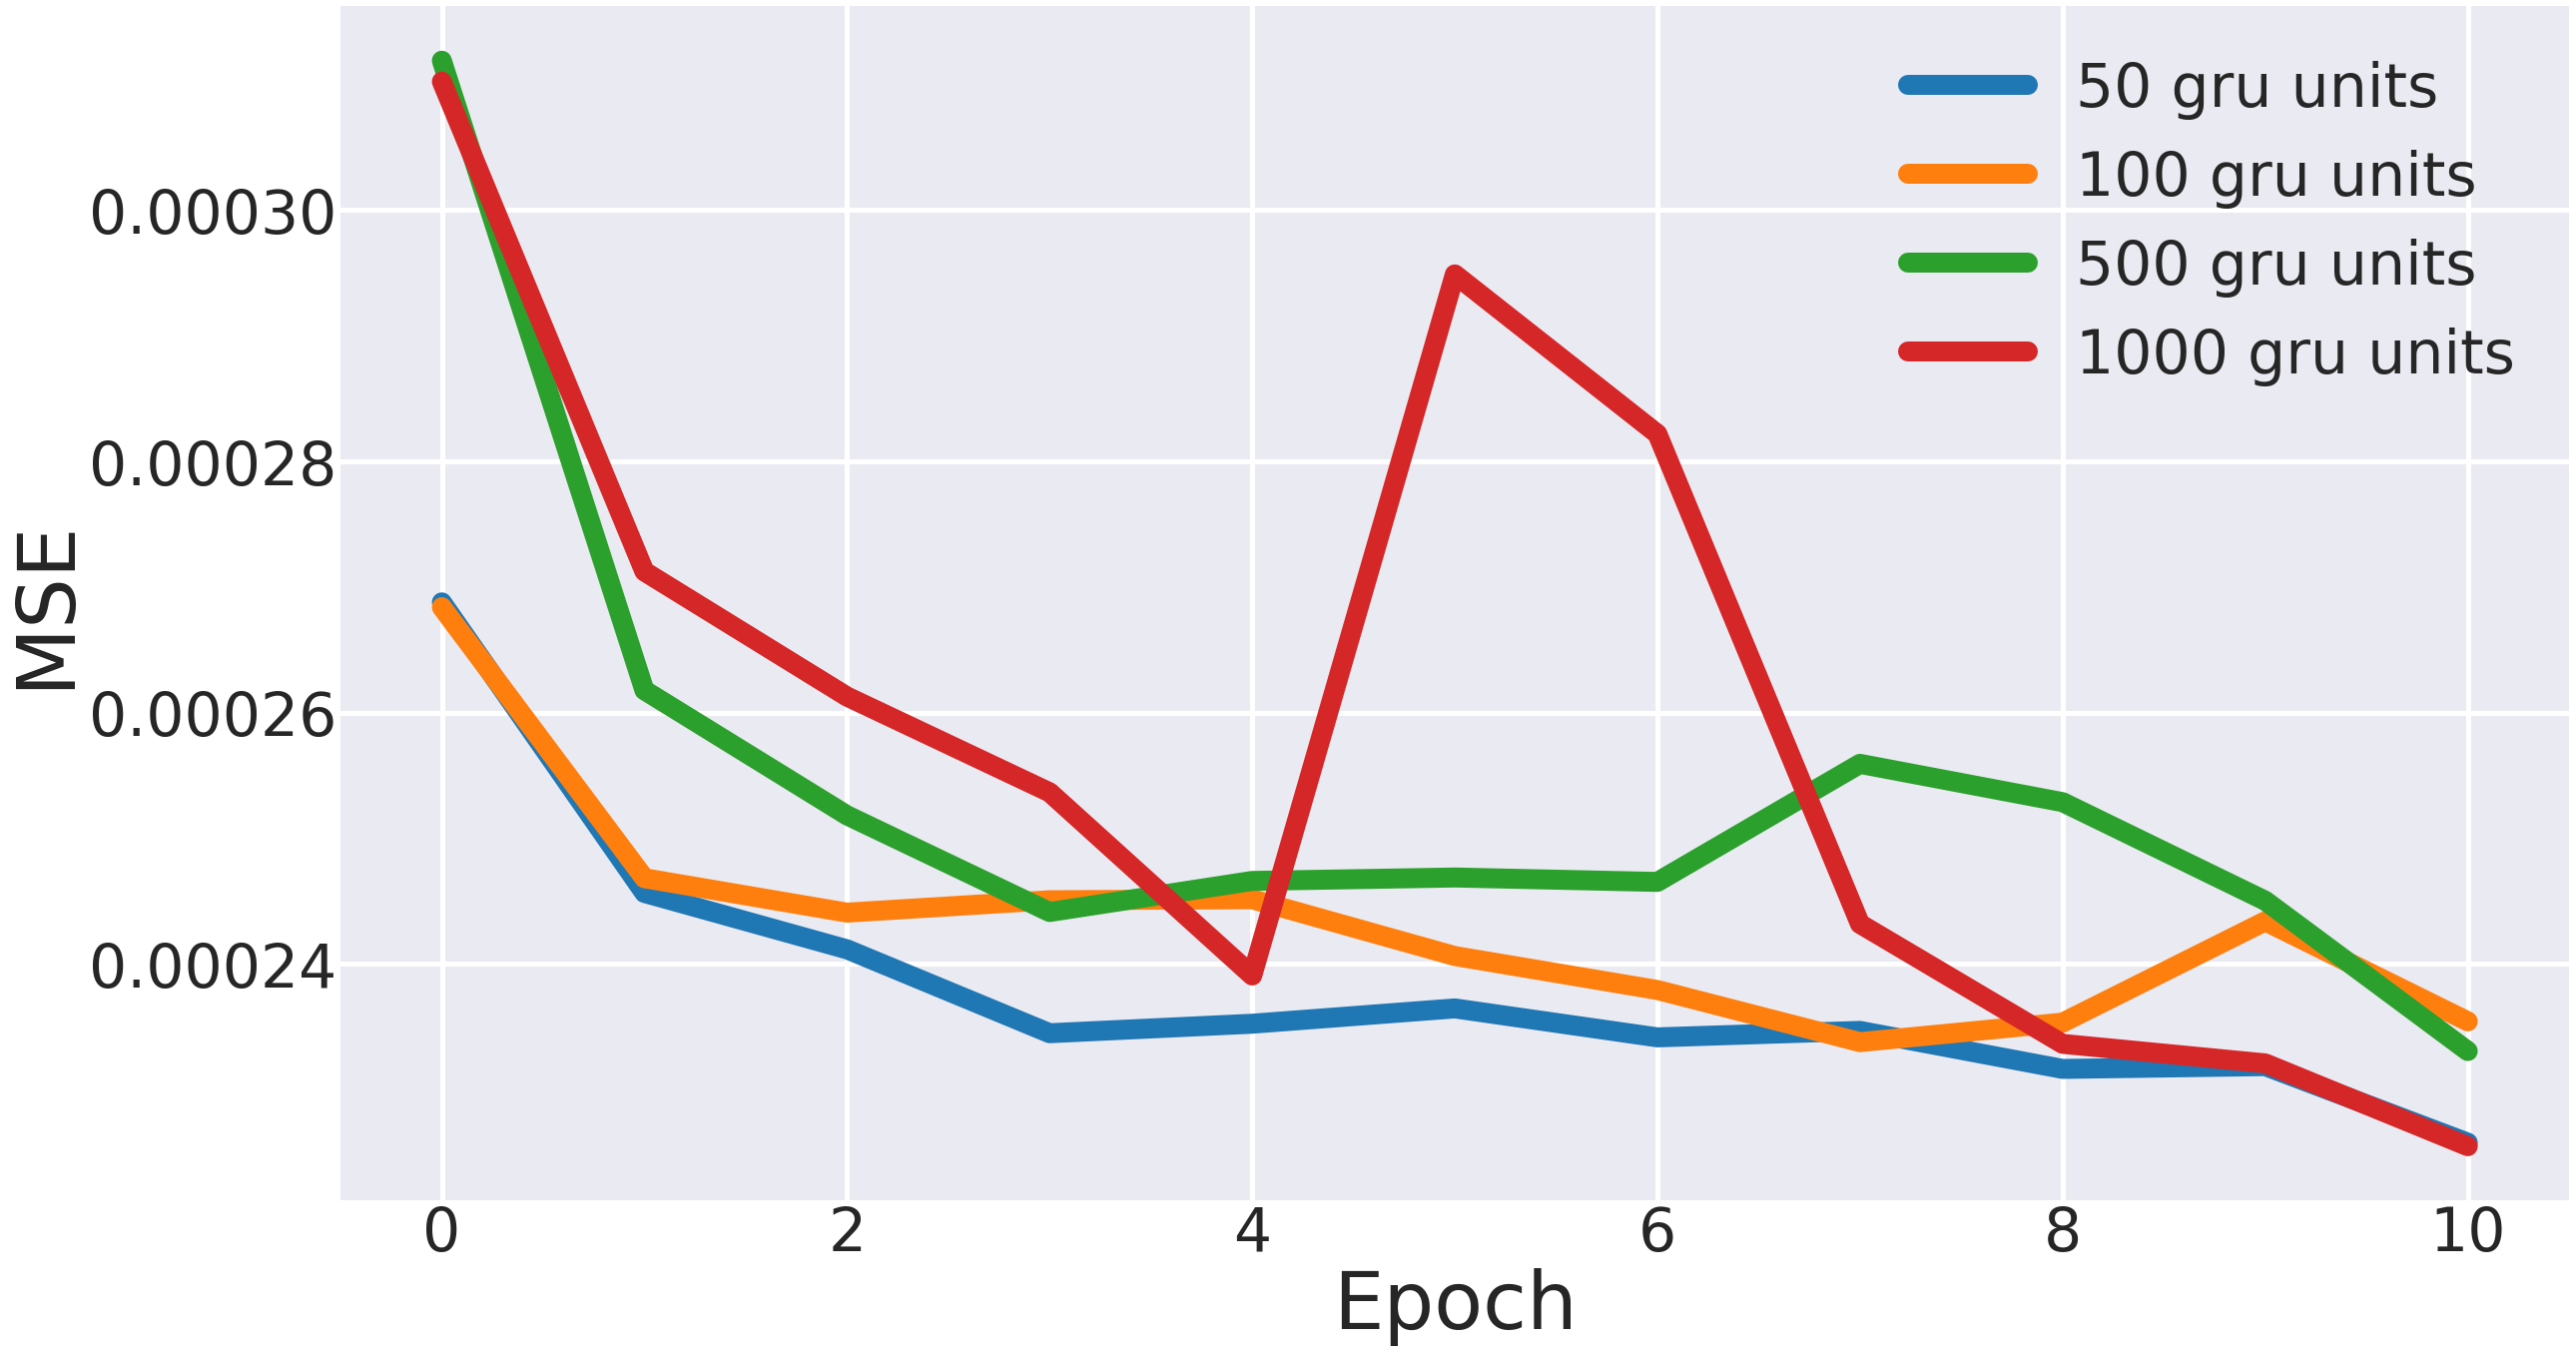

In [52]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
loss_single_plot = loss_single_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
loss_single_plot.set_xlabel("Epoch", {'size':xlabel_size})
loss_single_plot.set_ylabel("MSE", {'size':ylabel_size})
loss_single_plot.grid(linewidth=5)

In [53]:
%%spark -o val_loss_single_df

val_loss_single_df = spark.createDataFrame(
    sc.parallelize(np.array(val_losses).transpose().tolist()), 
    np.array(labels).tolist()
)

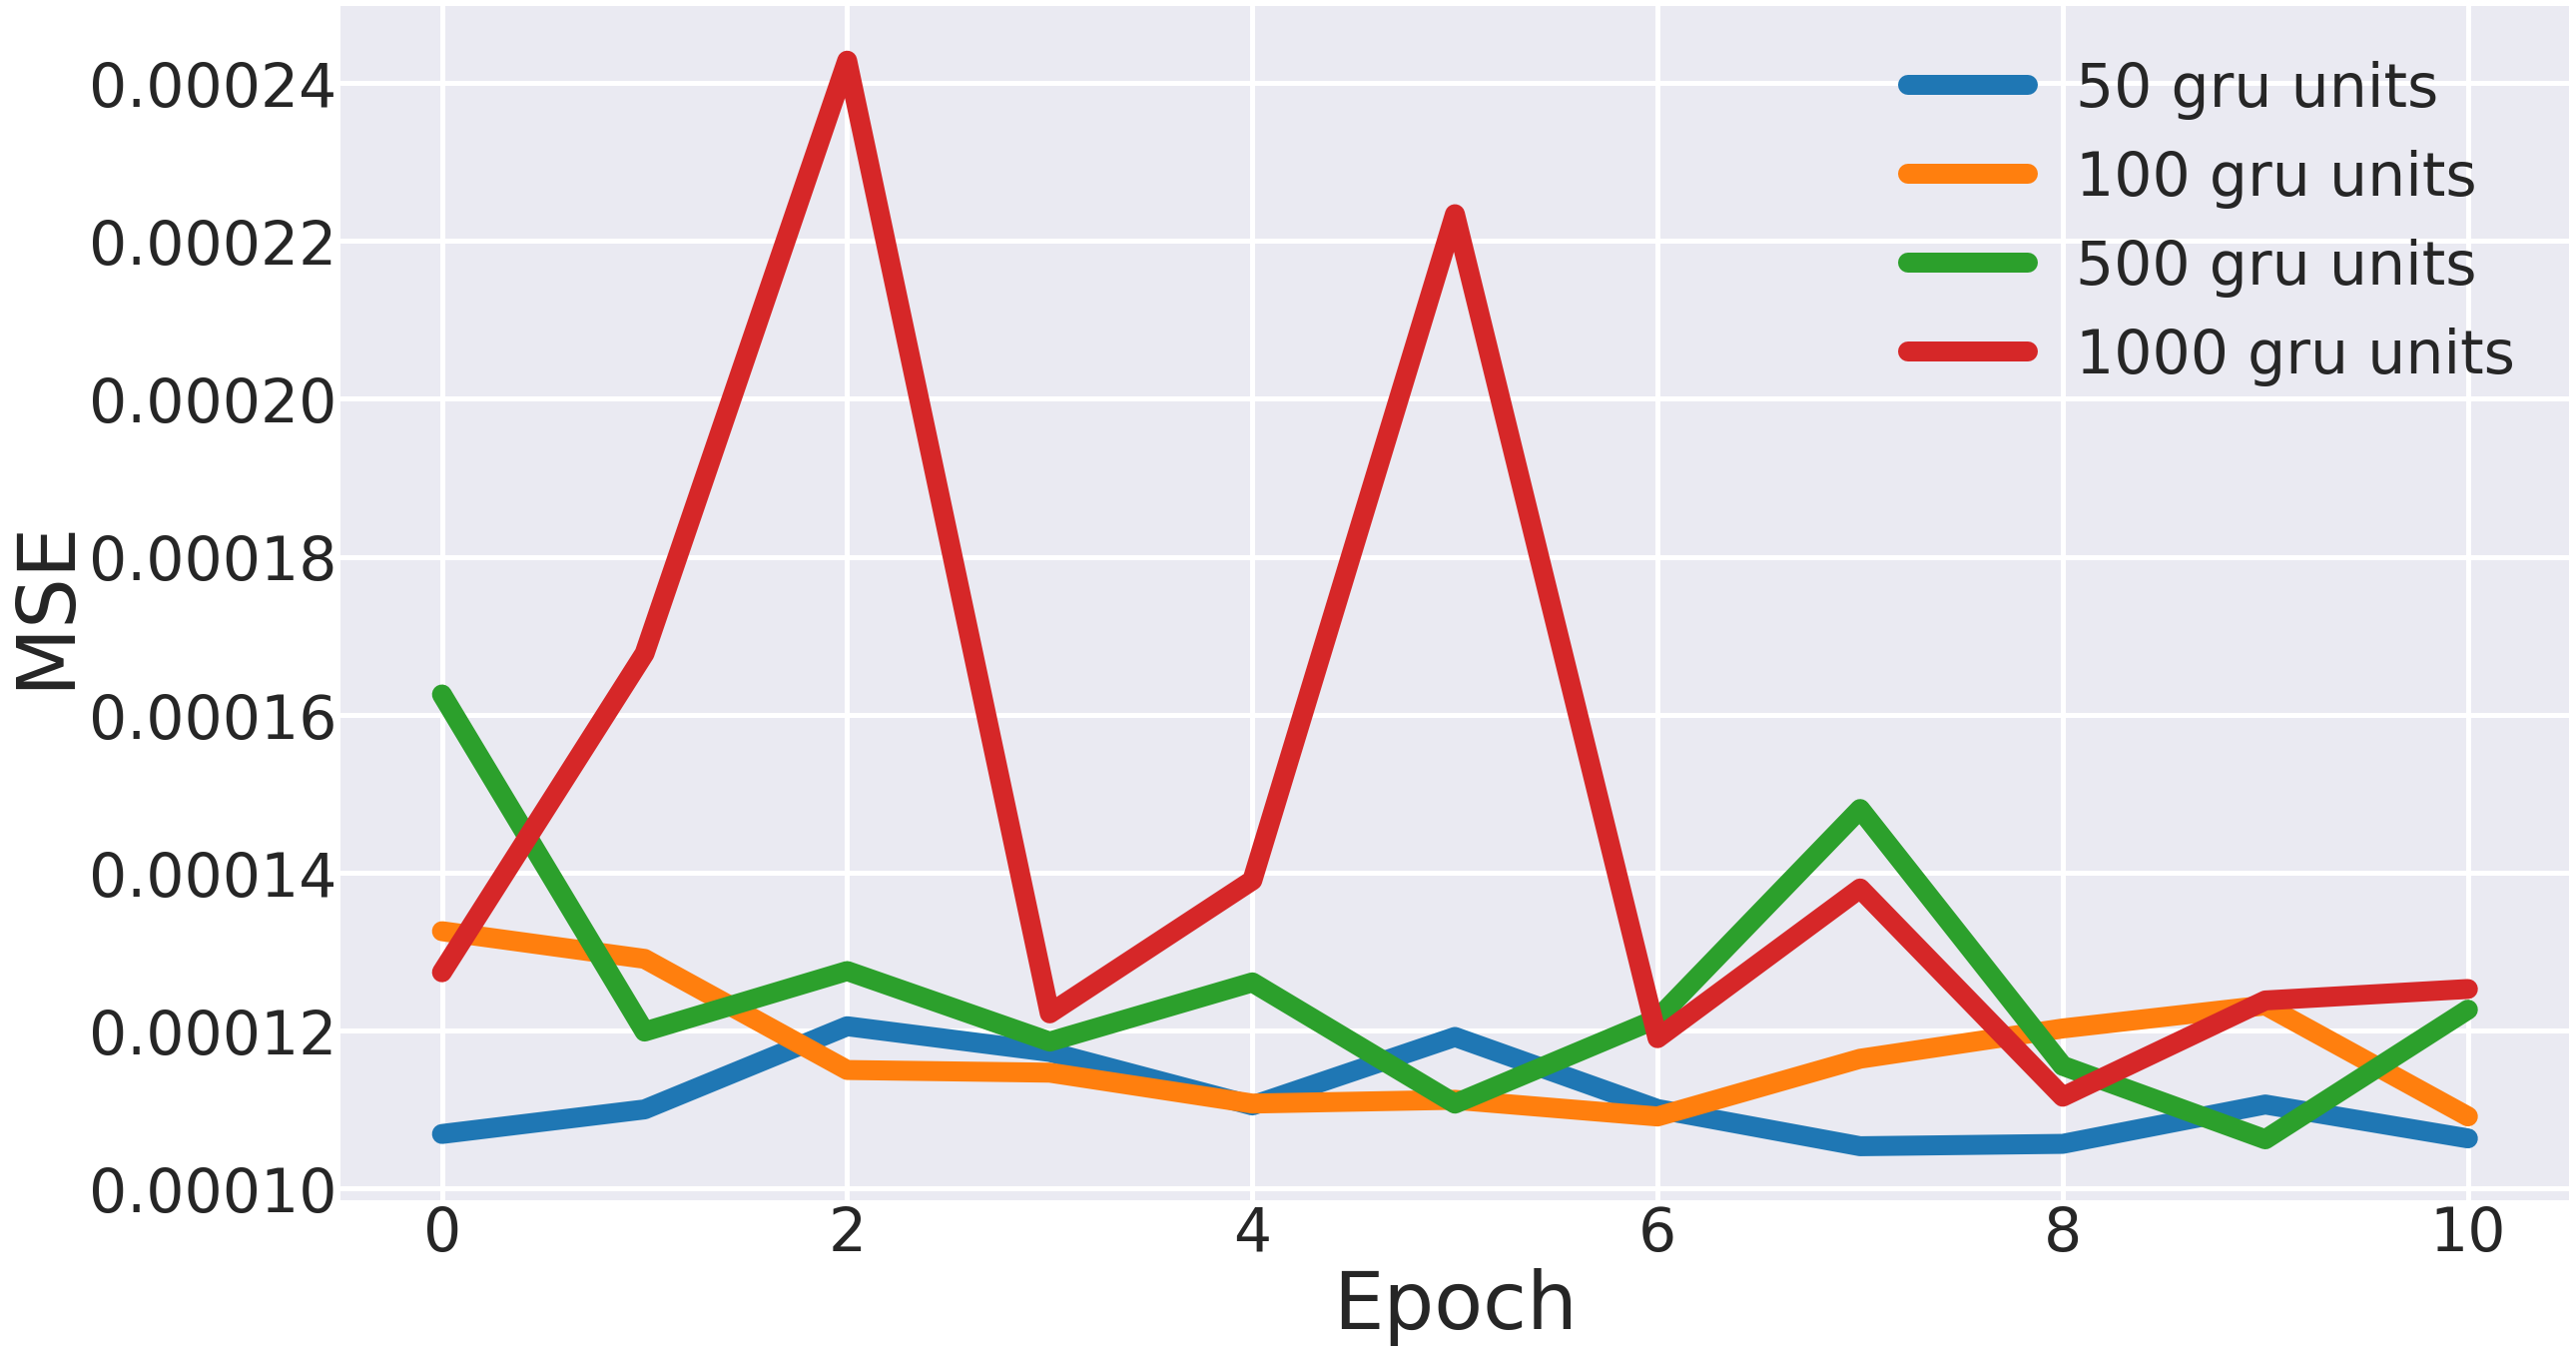

In [54]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
val_loss_single_plot = val_loss_single_df.plot.line(figsize=(40, 22), fontsize=tick_size, linewidth=line_width)
 
val_loss_single_plot.set_xlabel("Epoch", {'size':xlabel_size})
val_loss_single_plot.set_ylabel("MSE", {'size':ylabel_size})
val_loss_single_plot.grid(linewidth=5)

In [55]:
%%spark -o training_time_single_df

training_time_single_df = spark.createDataFrame(
    sc.parallelize(zip(
        labels, 
        np.array(training_times).tolist()
    )),
    ("index", "GRU")
)

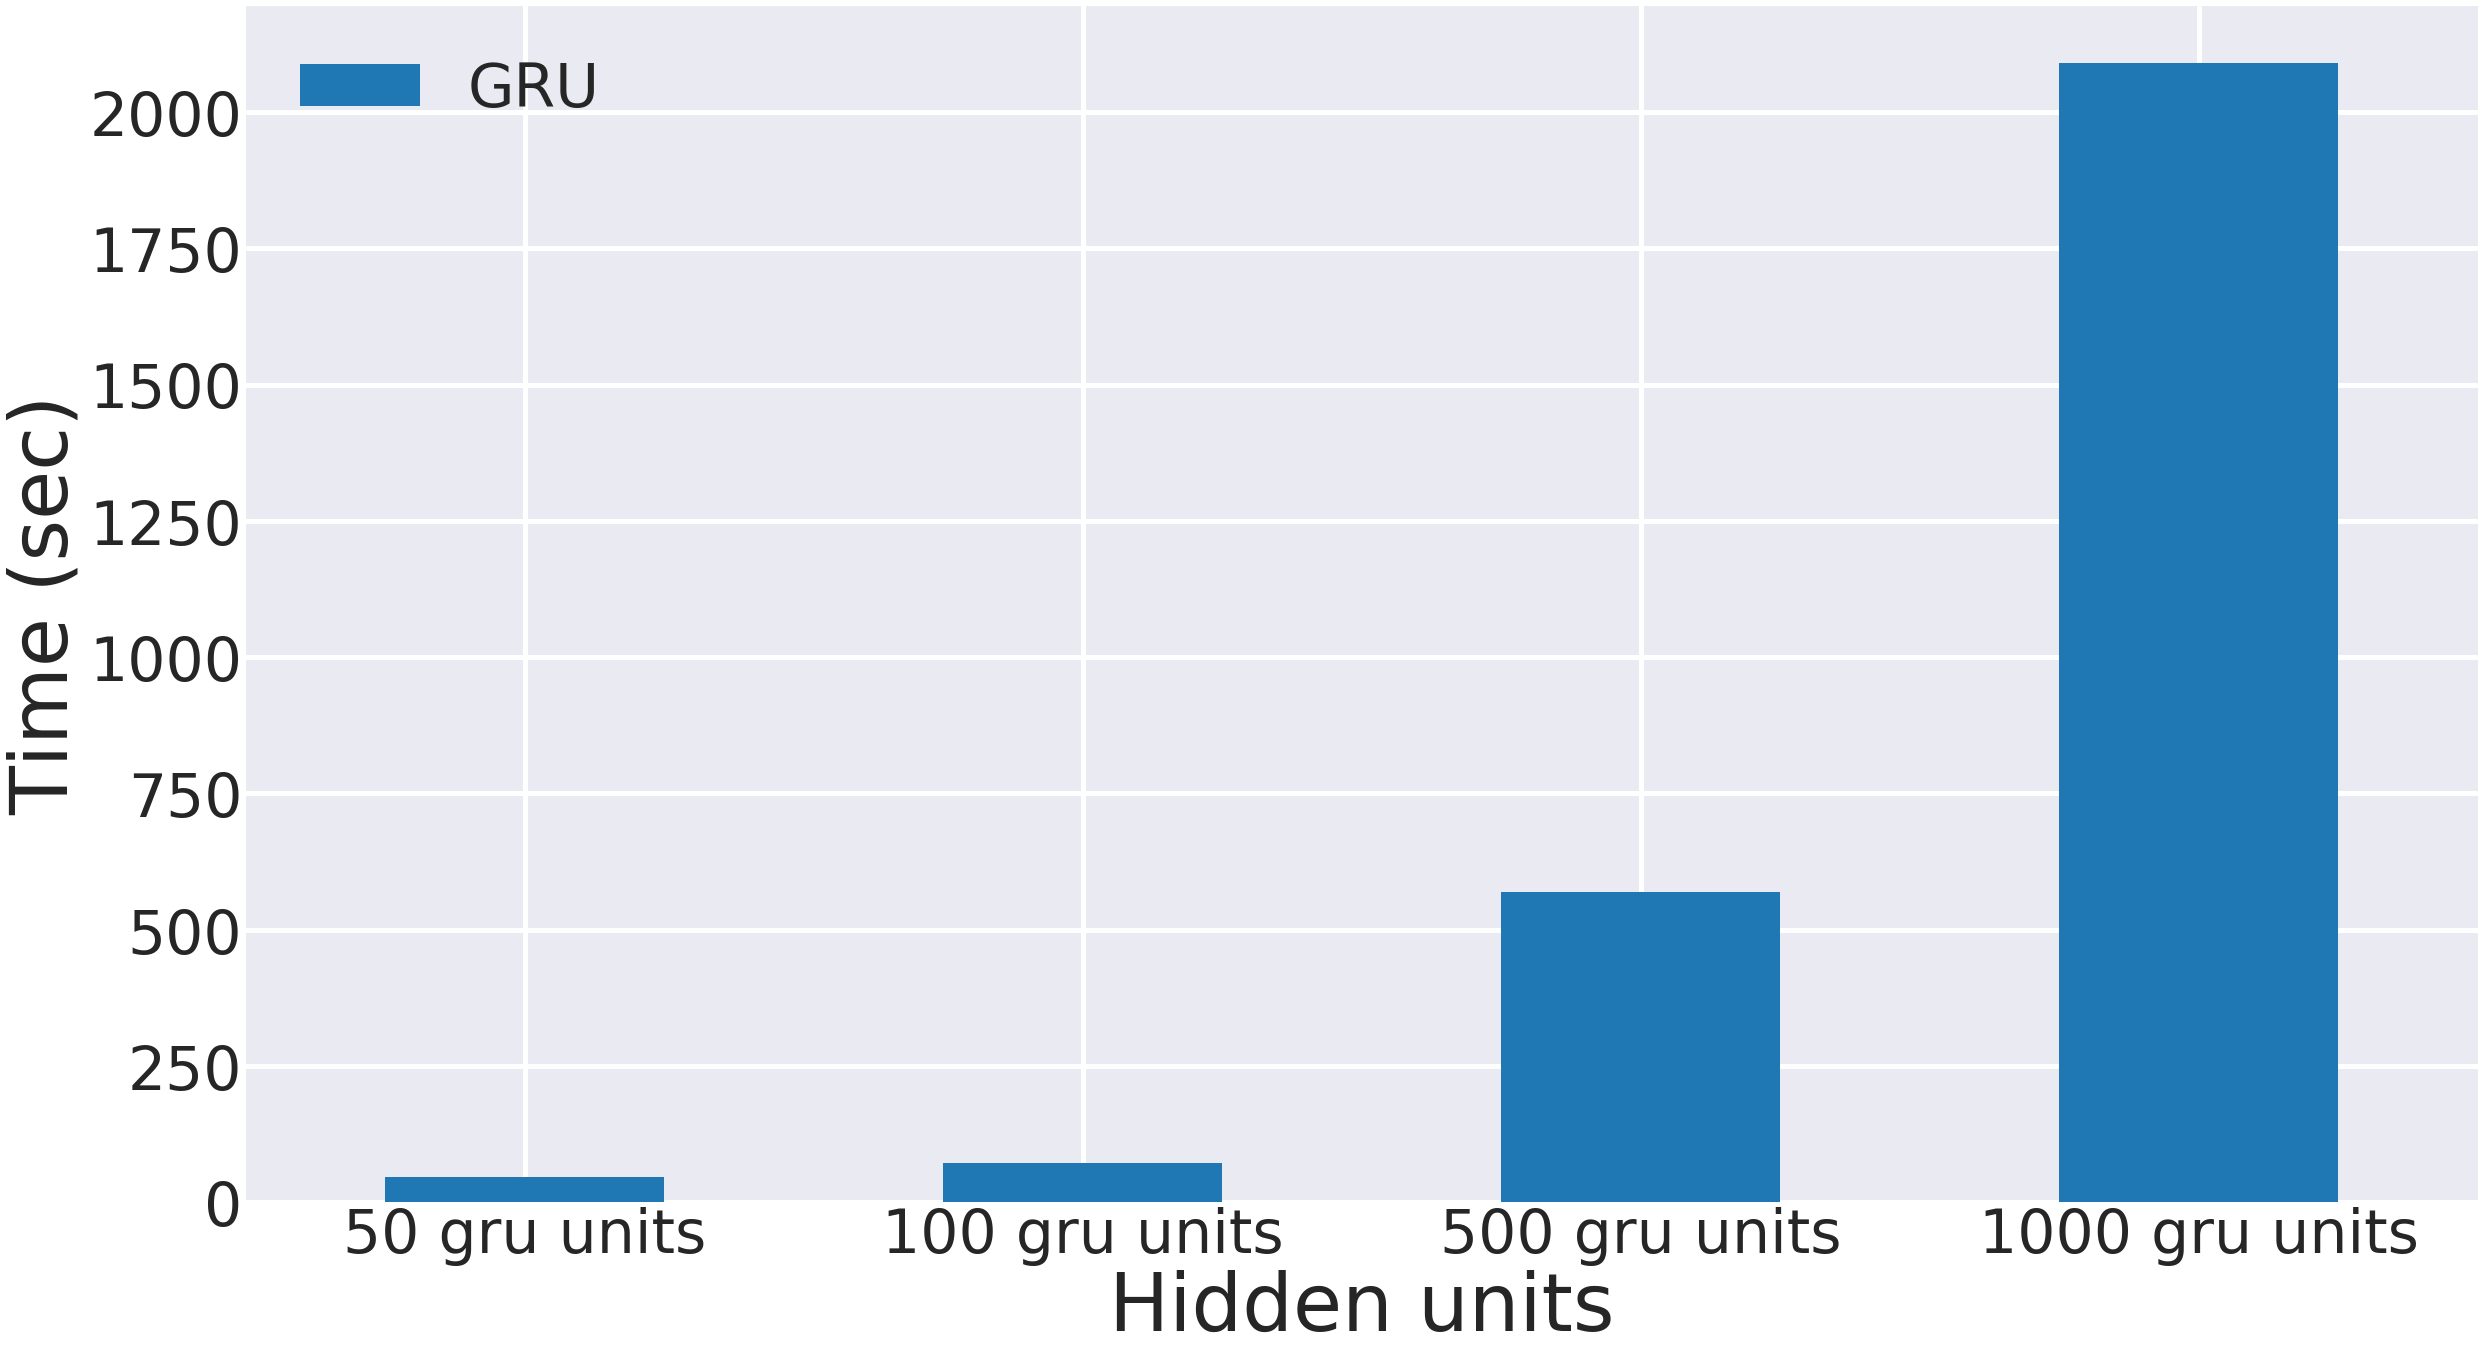

In [56]:
%%local
plt.rc('font', **{'weight' : 'normal','size'   : font_size})
training_time_single_plot = training_time_single_df.set_index('index').plot.bar(
    figsize=(40, 22), fontsize=tick_size, linewidth=line_width, rot=0
)
 
training_time_single_plot.set_xlabel("Hidden units", {'size': xlabel_size})
training_time_single_plot.set_ylabel("Time (sec)", {'size': ylabel_size})
training_time_single_plot.grid(linewidth=5)